In [1]:
from copy import deepcopy as dcopy
import matplotlib 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rc
%matplotlib inline
rc('text', usetex=True)
font = {'weight' : 'bold','size'   : 22}
matplotlib.rc('font', **font)
#############################################
import warnings
warnings.filterwarnings("ignore")
#############################################
import os,sys
import numpy as np
import healpy as hp
import healpy.newvisufunc as hpn
import astropy.io.fits as fits
import pysm3
import pysm3.units as u
import pymaster as nmt
#############################################
sys.path.insert(1, '/media/BINGODATA1/ComponentSeparation/beam_analyzes/scripts')
import beam_modelling         as model
import handling_data          as hdata
import parameters_and_setting as parset
import plot_setting           as pset
#############################################

In [2]:
#HImap-r0023-f1z15.fits
def nu_bins_vector(numin_=None, numax_=None, nbands_=None):
    nustep_ = (numax_-numin_)/nbands_
    nu_     = np.around(np.arange(numin_, numax_ + nustep_, nustep_),decimals=2)
    nbands  = nu_.size-1
    return {"min":numin_,"max":numax_,"bandwidth":nustep_,"nbands":nbands, "nu":nu_}

def get_info_from_directory(dirname_= None, kind="flask"):
    if kind=="flask":  #formatting: ../flask_maps_[NSIDE_NUMBER]
        nside  = int(dirname_.split("_")[-1])
        return {"NSIDE":nside}
    else: raise NameError
    
def get_info_from_filename(dirname_= None, filename_=None, numin_=980,numax_=1260,nbands_=30, kind="flask"):
    if kind=="flask":  #formatting: ../flask_maps_[NSIDE_NUMBER]/HImap-r[REALISATION]-f[FIELD_NUMBER]z[REDSHIFT_BIN].fits
        nudata = nu_bins_vector(numin_=numin_, numax_=numax_, nbands_=nbands_)
        nside  = int(dirname_.split("_")[-1])
        _,realization, zbin = filename_.split("-")
        realization = realization[1:]
        zbin  = int(zbin.split(".fits")[0].split("z")[1])
        nubin = np.flip(np.flip(nudata['nu'])[zbin-1:zbin+1])
        #zbin, nubin        
        return {"NSIDE":nside,
                "realization":realization,
                "frequency":{"min":nudata['min'],"max":nudata['max'], "bandwidth":nudata['bandwidth'], 'nbands':nudata['nbands'],"nu":nudata['nu']},
                "bin":{"numin":nubin[0],"numax":nubin[1],"z":zbin},
                'dirname':dirname_,"filename":filename_
               }
    else: raise NameError

In [3]:
def getmap(dirpath_=None, filename_=None, healpix_readingformat=True):
    if healpix_readingformat:
        maps = hp.read_map(os.path.join(dirpath_,filename_))
    else:
        import astropy.io.fits as fits
        with fits.open(os.path.join(dirpath_,filename_)) as h:
            maps = h[0].data
    return maps

In [4]:
def get_allfilenames(dirpath_=None):
    names = np.array([], dtype=np.str)
    for i,iname in enumerate(os.listdir(dirpath_)):
        if "fits"==iname.split(".")[1]:
            names = np.hstack((names,iname))
    return names        

def get_filenames(dirpath_=None):
    filenames = get_allfilenames(dirpath_=dirpath_)
    names = np.array([], dtype=np.str)
    for i,iname in enumerate(os.listdir(dirpath_)):
        if "fits"==iname.split(".")[1]:
            names = np.hstack((names,iname))
    return names     

def get_realization_id_from_filename(filename_=None):
    return filename_.split('-')[1].split('r')[1]

def get_all_realizations_id(filenames_=None):
    IDs = np.array([])
    for i,ifilename in enumerate(filenames_):
        _id_ =get_realization_id_from_filename(filename_=ifilename)
        IDs = np.append(IDs,_id_)
    return np.unique(IDs)

def get_filenames4realizations(filenames_=None,ids_=None): #ids_: all realization name index. Fex: ['0001', '0002', ..., '0100']
    for i,_id_ in enumerate(ids_):
        if not i:
            idic = {_id_:np.array([])}
        else:
            idic[_id_] = np.array([])
    for i,ifilename in enumerate(filenames_):
        _id_ = get_realization_id_from_filename(filename_=ifilename)
        idic[_id_] = np.hstack((idic[_id_],ifilename))
    for _id_ in idic.keys():
        idic[_id_] = np.sort(idic[_id_])
    return idic

In [5]:
path    = "/media/BINGODATA1/ComponentSeparation/MAPS/HI"
idir    = "flask_maps_512"#'HImap-r0023-f1z15.fits'#'512__980_1260MHz_30bins'
pathdir = os.path.join(path,idir)
ifile   = os.listdir(pathdir)[0]
ginfo   = get_info_from_filename(dirname_= idir, filename_=ifile)

In [6]:
print(ifile)
ginfo['frequency'].keys()

HImap-r0023-f1z15.fits


dict_keys(['min', 'max', 'bandwidth', 'nbands', 'nu'])

In [7]:
filenames = get_allfilenames(dirpath_=pathdir)
_ids_     = get_all_realizations_id(filenames)
randfile  = np.random.choice(filenames)
_rid_     = get_realization_id_from_filename(filename_=randfile)

In [8]:
print(_ids_)
print(randfile)
print(_rid_)

['0001' '0002' '0003' '0004' '0005' '0006' '0007' '0008' '0009' '0010'
 '0011' '0012' '0013' '0014' '0015' '0016' '0017' '0018' '0019' '0020'
 '0021' '0022' '0023' '0024' '0025' '0026' '0027' '0028' '0029' '0030'
 '0031' '0032' '0033' '0034' '0035' '0036' '0037' '0038' '0039' '0040'
 '0041' '0042' '0043' '0044' '0045' '0046' '0047' '0048' '0049' '0050'
 '0051' '0052' '0053' '0054' '0055' '0056' '0057' '0058' '0059' '0060'
 '0061' '0062' '0063' '0064' '0065' '0066' '0067' '0068' '0069' '0070'
 '0071' '0072' '0073' '0074' '0075' '0076' '0077' '0078' '0079' '0080'
 '0081' '0082' '0083' '0084' '0085' '0086' '0087' '0088' '0089' '0090'
 '0091' '0092' '0093' '0094' '0095' '0096' '0097' '0098' '0099' '0100']
HImap-r0042-f1z17.fits
0042


In [9]:
ginfo = get_info_from_filename(dirname_= idir, filename_=randfile)
ginfo

{'NSIDE': 512,
 'realization': '0042',
 'frequency': {'min': 980,
  'max': 1260,
  'bandwidth': 9.333333333333334,
  'nbands': 30,
  'nu': array([ 980.  ,  989.33,  998.67, 1008.  , 1017.33, 1026.67, 1036.  ,
         1045.33, 1054.67, 1064.  , 1073.33, 1082.67, 1092.  , 1101.33,
         1110.67, 1120.  , 1129.33, 1138.67, 1148.  , 1157.33, 1166.67,
         1176.  , 1185.33, 1194.67, 1204.  , 1213.33, 1222.67, 1232.  ,
         1241.33, 1250.67, 1260.  ])},
 'bin': {'numin': 1101.33, 'numax': 1110.67, 'z': 17},
 'dirname': 'flask_maps_512',
 'filename': 'HImap-r0042-f1z17.fits'}

building_cubemaps(pathdir_=path, dirname_ =idir, healpix_readingformat=True)

In [10]:
def building_cubemaps(pathdir_=None, dirname_=None, healpix_readingformat=True):
    from copy import deepcopy as dcopy
    filenames = get_allfilenames(dirpath_=pathdir_)
    _ids_     = get_all_realizations_id(filenames)
    idic      = get_filenames4realizations(ids_=_ids_)
    i  = np.random.choice(_ids_)por
    HI = building_cubemaps_from_realization(pathdir_=pathdir, filenames_=idic[i],)    

def building_cubemaps_from_realization(pathdir_=None, filenames_=None, healpix_readingformat=True):#this's for one id and not for all of them
    from copy import deepcopy as dcopy
    dirname_ = pathdir_.split("/")[-1]
    ginfo    = get_info_from_filename(dirname_= dirname_, filename_=filenames_[0])
    HImaps   = np.ones((ginfo['frequency']['nbands'],12*(ginfo['NSIDE'])**2))
    for i,ifilename in enumerate(filenames_):
        ifilename = os.path.join(pathdir_, ifilename)
        numname   = int(ifilename.split(".fits")[0].split('z')[1])-1 #names in z between 1-30, but cube between 0-29 numeration
        imap      = getmap(dirpath_=pathdir_, filename_=ifilename, healpix_readingformat=healpix_readingformat)
        HImaps[numname,:] = dcopy(imap)   
    return HImaps

In [11]:
pathdir

'/media/BINGODATA1/ComponentSeparation/MAPS/HI/flask_maps_512'

In [12]:
filenames.size

3000

In [13]:
filenames = get_allfilenames(dirpath_=pathdir)
_ids_     = get_all_realizations_id(filenames)
idic      = get_filenames4realizations(filenames_=filenames,ids_=_ids_)
HI        = building_cubemaps_from_realization(pathdir_=pathdir, filenames_=idic['0100'],)
HI

array([[ 0.02906217,  0.00729274,  0.22431837, ...,  0.0026751 ,
         0.00079916,  0.04069765],
       [ 0.01000084,  0.0031949 ,  0.01044813, ...,  0.00550903,
         0.01120859,  0.00627547],
       [-0.00458689,  0.01937331,  0.06184552, ...,  0.00210131,
        -0.00182344,  0.01094116],
       ...,
       [ 0.05076072,  0.39804465,  0.28931886, ...,  0.01289645,
         0.04294902,  0.07024486],
       [ 0.02354094,  0.11523544,  0.043694  , ..., -0.00146643,
         0.00255653,  0.00735769],
       [ 0.00338627,  0.06686396,  0.40749404, ...,  0.00612071,
         0.02526287,  0.06304943]])

In [14]:
testfile = idic['0040'][0]
ginfo = get_info_from_filename(dirname_= pathdir.split('/')[-1], filename_=testfile)
ginfo

{'NSIDE': 512,
 'realization': '0040',
 'frequency': {'min': 980,
  'max': 1260,
  'bandwidth': 9.333333333333334,
  'nbands': 30,
  'nu': array([ 980.  ,  989.33,  998.67, 1008.  , 1017.33, 1026.67, 1036.  ,
         1045.33, 1054.67, 1064.  , 1073.33, 1082.67, 1092.  , 1101.33,
         1110.67, 1120.  , 1129.33, 1138.67, 1148.  , 1157.33, 1166.67,
         1176.  , 1185.33, 1194.67, 1204.  , 1213.33, 1222.67, 1232.  ,
         1241.33, 1250.67, 1260.  ])},
 'bin': {'numin': 1250.67, 'numax': 1260.0, 'z': 1},
 'dirname': 'flask_maps_512',
 'filename': 'HImap-r0040-f1z1.fits'}

In [15]:
pathtestfile = os.path.join(pathdir,ginfo['filename'])
itestmap = hp.read_map(pathtestfile)
itestmap

array([ 0.0069457 ,  0.0502713 ,  0.01309548, ..., -0.00339368,
       -0.00551024,  0.00144219], dtype=float32)

In [16]:
HI[ginfo['bin']['z']-1,:]

array([0.02906217, 0.00729274, 0.22431837, ..., 0.0026751 , 0.00079916,
       0.04069765])

In [17]:
testname = 'test.fits'
hdu = fits.PrimaryHDU(HI)
hdul = fits.HDUList([hdu])
hdul.writeto(testname,overwrite=True)

with fits.open(testname) as h:
    maps = dcopy(h[0].data)
os.remove(testname)
maps.shape

(30, 3145728)

In [18]:
maps[ginfo['bin']['z']-1,:]

array([0.02906217, 0.00729274, 0.22431837, ..., 0.0026751 , 0.00079916,
       0.04069765])

amarins@cosmo0:/media/BINGODATA1/ComponentSeparation/PAPER$ ls INPUT | tail -1
- Cube_IWN_2d_1146_L9_M.fits

amarins@cosmo0:/media/BINGODATA1/ComponentSeparation/PAPER$ ls PRIOR | tail -1
- Cube_PWN_2d_1146_L9_M.fits

amarins@cosmo0:/media/BINGODATA1/ComponentSeparation/PAPER$ ls PURE | tail -1
- Cube_21cm_L9_M.fits

amarins@cosmo0:/media/BINGODATA1/ComponentSeparation/PAPER$ ls WN | tail -1
- Cube_WN2d_1146_256mK_L9M.fits

amarins@cosmo0:/media/BINGODATA1/ComponentSeparation/PAPER$ ls PSM_Components/ | tail -1
- psm_synch_rot_mK.fits


## New filename formatting:

#### INFOs necessaries to contain in the files:
    - type of field
    - type of STOKES parameter
    - field unit
    - NSIDE
    - realization
    - full or partial-sky
        - If partial 
            - some info describing the masking process
    - date of FITS creation
    - astronomical coordinate system
    - Convolved or not with a beam
        - If so 
            - [1] type of beam model
            - [2] FWHM
    - others

#### Necessary features to be in the filename:
    - type of field
    - type of STOKES parameter
    - NSIDE
    - realization
    - full/partial-sky
    - Convolved or not
    - frequency range


In [19]:
def new_formattingnames(F=None, S=None, NSIDE_=None, 
                        freq_min=None, freq_max=None,freq_unit="mhz",
                        Num_=None, C=None, Bres=None, Bmodel=None,
                        A=None, R=None):
    #STANDARD values:       #OBS: Read add pdf attached
    #F='HI'
    #S='I'
    #NSIDE_=512
    #freq_min=980
    #freq_max=1260
    #freq_unit="mhz"
    #Num_=30
    #C='partial'
    #Bres=40
    #Bmodel='G'
    #A=None
    #R='0001'    
    if Bres==None or Bmodel==None:
        if A==None:
            return "{}_{}_{}_{}{}{}{}_{}bins_{}_L{}.fits".format(F,S,NSIDE_,freq_min, freq_unit, freq_max, freq_unit,
                                                                       Num_, C, R)         
        else:
            return "{}_{}_{}_{}{}{}{}_{}bins_{}_{}_L{}.fits".format(F,S,NSIDE_,freq_min, freq_unit, freq_max, freq_unit,
                                                                       Num_, C,A, R)         
    else:    
        if A==None:
            return "{}_{}_{}_{}{}{}{}_{}bins_{}_{}arcmin{}beam_L{}.fits".format(F,S,NSIDE_,freq_min, freq_unit, freq_max, freq_unit,
                                                                       Num_, C, Bres, Bmodel, R)         
        else:
            return "{}_{}_{}_{}{}{}{}_{}bins_{}_{}arcmin{}beam_{}_L{}.fits".format(F,S,NSIDE_,freq_min, freq_unit, freq_max, freq_unit,
                                                                       Num_, C, Bres, Bmodel, A, R) 

In [21]:
new_formattingnames(F='HI', S='I', NSIDE_=512, 
                        freq_min=980, freq_max=1260,freq_unit="mhz",
                        Num_=30, C='partial', Bres=None, Bmodel="G",
                        A=None, R='0001')

'HI_I_512_980mhz1260mhz_30bins_partial_L0001.fits'

[WN] --> HI <--> WN

##### Formatting name
\[F\]\_[S\]\_\[NSIDE\]\_\[Freq\]\_\[Num\]bins\_\[C\]\_\[B\]beam\_\[A\]\_L\[R\].fits
 
Example: HI_I_512_980mhz1260mhz_30bins_partial_40arcminZNbeam_L0010.fits
 
- F: type of field. For instance: HI, FG, N, WN, ...
    - FG: each kind of astrophysical component should have the short name composing as follow:
        - [AME]: Anomalous Microwave Background
        - [CIB]: Cosmic Infrared Background
        - [CMB]: Cosmic Microwave Background
        - [SYN] : Synchrotron
        - [FRP]: Faint Radio Point sources
        - [FF] :  Free-Free emission
        - [SZ]: Sunyaev-Zeldovich emission
    
    - HI:  neutral hydrogen
    
    - N: Noise could be
        - [uWN]: uncorrelated White Noise
        - [cWN]: correlated White Noise
        - [1F]:  pink Noise or 1/f-noise
        - [PLK]: Polarization LeaKage
        - others
        PS.: if the component is a composition of many FG is necessary use onlu FG and specify on the FITS head each component
    
    - PRIOR: We will keep the same nomeclature come from the previous works and assume PRIOR as a composition of HI + N, where N could be uWN, cWN or other kind of 
        - PS.: it should be specified on the FITS head each component
    
    - INPUT or SKY: It'll be assumed as a composition of sky emissions + instrumental noises.
    
- S: Stokes parameters: It should be speficied which type of Stokes parameter the file represent 
    - I: intensity
    - Q: Q-pol parameter
    - U: U-pol parameter
    - W: W-pol parameter
    - P: P-pol parameter
    - p: p-pol parameter
    
- NSIDE: HealPix resolution. It should be used only the NSIDE number, nothing much.
    
- Freq: Frequency range. It must be write with the frequency followed by its unit. For this, if there is no specific range it only needs assume one specification.
    - Exemples: 980mhz1260mhz, 1100mhz, 1250mhz1260mhz,...
    
- Num: Number of frequency bins. It'll be specifying the number of slices on the matrix. The number of bins (frequency bands) should be written with the number followed by "bins"

- C: Type of covering: full or partial. If the map(s) is(are) masked then it's necessary to use "partial". Otherwise, if all sky, "full".

- B: Specification of the beam. If there is no beam convolution, it should be assumed the type NONE. If there is a convolution, first you need to include the number of resolution in arcmin followed by "arcmin". Then, the type of beam modelling followed by "beam". Acronynms of the beam are as follow:
    - [ZN] : Zernike Polynomial
    - [G] : Gaussian
    - [JC] : Spherical Bessel
    - [CO] : Cosine Polynomial
    - [LA] : Laguerre
    - [HM] : Hermite
    - [AI] : Airy 
    
- A: In this part, you can include any adictional info you want

- R: realization. Include the number of realization after the letter "L".

In [95]:
if 1:
    ipath = "/media/BINGODATA1/ComponentSeparation/building_dataset/outputs" 
    cmd   = "{}/*".format(ipath) 
    cmd = "rm -rf {}".format(cmd)
    #os.system(cmd)
    os.popen(cmd).readlines()

In [87]:
def get_beam_model(acron):
    if acron.upper() == "ZN":
        return "Zernike"
    elif acron.upper() == "G":
        return "Gaussian"
    elif acron.upper() == "JC":
        return "Spherical Bessel"
    elif acron.upper() == "CO":
        return "Cosine"
    elif acron.upper() == "LA":
        return "Laguerre"
    elif acron.upper() == "HM":
        return "Hermite"
    elif acron.upper() == "AI":
        return "Airy"
    else:
        return None
        
#HI_I_512_980mhz1260mhz_30bins_partial_40arcminZNbeam_L0010.fits
def get_info_from_output_filename(filename_=None):
    #HI_I_512_980mhz1260mhz_30bins_partial_40arcminZNbeam_L0010.fits
    iparts = filename_.split("_")
    field_info  = iparts[0]
    stokes_info = iparts[1]
    nside_info  = int(iparts[2])
    freq_info   = np.asarray(iparts[3].split("mhz")[:-1],dtype=np.float)
    nbins_info  = int(iparts[4].split("bins")[0])
    cover_info  = iparts[5]
    if len(iparts[6].split('beam'))>1:
        beam_info   = iparts[6]
        fwhm_info   = float(beam_info.split("arcmin")[0])
        type_of_beam = get_beam_model(beam_info.split("arcmin")[1].split("beam")[0])
    else:
        type_of_beam   = None
        fwhm_info      = None
    realiz_info = iparts[-1].split("L")[1]
    return {"field": field_info, "stokes":stokes_info, "NSIDE":nside_info, "freq":freq_info,
            "nbins":nbins_info, "coverage":cover_info, "beam":{"fwhm":fwhm_info, "model":type_of_beam}}

def creating_multimap_FITSheader(filename_=None, freq_unit="Mhz", stokes_unit="mk", fwhm_unit="arcmin",realization_=None):
    import datetime
    ginfo = get_info_from_output_filename(filename_)
    hdr = fits.Header()
    hdr['COMMENT'] = "THIS IS A NEW NAME FORMAT FOR THE BINGO PROJECT FITS FILES."
    hdr['COMMENT'] = "THESE FILES ARE USED FOR COMPONENT SEPARATION CODE CALLED --CHISEL--"
    hdr['COMMENT'] = "https://github.com/multinverse/CHISEL---signals-from-LIM"
    hdr['COMMENT'] = "ITS FORMAT ASSUME FLASK MAPS AS INPUT"
    hdr['COMMENT'] = "CREATED IN: {}".format(str(datetime.datetime.now()).split(".")[0])
    for i,ikey in enumerate(ginfo.keys()):
        if ikey=="field":
            hdr['field'] = ginfo['field']
            #hdr.comments['field'] = "{}".format("...")
        if ikey=="stokes":
            hdr["stokes"] = ginfo["stokes"]
            hdr.comments["stokes"] = "{}".format(stokes_unit)       
        if ikey=="coverage":
            hdr["coverage"] = ginfo["coverage"]
            hdr.comments["coverage"] = "{full- or partial-sky}"
        if ikey=="freq":
            if len(ginfo['freq'])==2:
                hdr["_".join((ikey,"min"))]=np.amin(ginfo['freq'])
                hdr["_".join((ikey,"max"))]=np.amax(ginfo['freq'])
                hdr.comments["_".join((ikey,"min"))]="in {}".format(freq_unit)
                hdr.comments["_".join((ikey,"max"))]="in {}".format(freq_unit)
        elif ikey=="beam":
            if ginfo[ikey]==None or ginfo[ikey]['fwhm']==None or ginfo[ikey]['model']==None:
                hdr["beam"]= 'NONE'
            else:
                hdr['fwhm'] = ginfo['beam']['fwhm']
                hdr['beam'] = ginfo['beam']['model']
                hdr.comments['fwhm']="{}".format(fwhm_unit)
        else:
            hdr[ikey]=ginfo[ikey]
    hdr['REALIZATION']=realization_
    return hdr

def creating_primary_FITSheader(output_info=None):
    hdr = fits.Header()
    hdr['COMMENT']="PRIMARY HDU CONTAIN THE REDSHIFT VECTOR"
    hdr['FREQ_MIN'] = output_info['frequency']['min']
    hdr['FREQ_MAX'] = output_info['frequency']['max']
    hdr['NBANDS'] = output_info['frequency']['nbands']
    return hdr
def return_new_FITSfilename(ginfo=None, output_info=None, add_info=None):
    #ginfo['NSIDE']
    #ginfo['realization']
    #ginfo['frequency']['min']
    #ginfo['frequency']['max']
    #ginfo['nbands']
    #output_info['field']
    #output_info['covering']
    #output_info['beam']['model']
    #output_info['beam']['FWHM']
    #output_info['stokes']    
    return new_formattingnames(F=output_info['field'], S=output_info['stokes'], 
                        NSIDE_  =ginfo['NSIDE'], 
                        freq_min=ginfo['frequency']['min'],   freq_max=ginfo['frequency']['max'],freq_unit="mhz",
                        Num_    =ginfo['frequency']['nbands'], C=output_info['coverage'], 
                        Bres    =output_info['beam']['fwhm'], Bmodel=output_info['beam']['model'],
                        R       =ginfo['realization'],
                        A       =add_info)

In [31]:
iname = "HI_I_512_980mhz1260mhz_30bins_partial_40arcminZNbeam_L0010.fits"
ginfo = get_info_from_output_filename(iname)
ginfo

{'field': 'HI',
 'stokes': 'I',
 'NSIDE': 512,
 'freq': array([ 980., 1260.]),
 'nbins': 30,
 'coverage': 'partial',
 'beam': {'fwhm': 40.0, 'model': 'Zernike'}}

In [35]:
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################
path        = "/media/BINGODATA1/ComponentSeparation/MAPS/HI"
idir        = "flask_maps_512"
output_info = {"field":"HI", 
               "frequency":{"min":980,"max":1260,'nbands':30},
               "coverage":'partial',
               'beam': {'model':'ZN', 'fwhm':10}, 
               'stokes':'I',
               "freq_unit":"MHz", "stokes_unit":"mk", "fwhm_unit":"arcmin",
               "realization":['0100']}

pathdir   = os.path.join(path,idir) #<-- path to diretories with all maps
filenames = get_allfilenames(dirpath_=pathdir) #all filenames in the directory
_ids_     = get_all_realizations_id(filenames) #all realization names
idic      = get_filenames4realizations(filenames_=filenames, ids_=_ids_) #all filenames for a specific realization
###########
ifile     = np.random.choice(idic[output_info['realization'][0]]) #Choice a specific realization name just to test
ginfo     = get_info_from_filename(dirname_= idir, filename_=ifile, 
                                   numin_ =output_info['frequency']['min'], 
                                   numax_ =output_info['frequency']['max'], 
                                   nbands_=output_info['frequency']['nbands']) #info from filenames
new_name  = return_new_FITSfilename(ginfo, output_info, add_info=None) #new FITS name for that map cube
###########
vec_hdu0  = ginfo['frequency']['nu']
hdr_hdu0  = creating_primary_FITSheader(output_info)
vec_hdu1  = building_cubemaps_from_realization(pathdir_=pathdir, filenames_=idic[output_info['realization'][0]]) #extracting all maps for a specific realization and building a cube
hdr_hdu1  = creating_multimap_FITSheader(new_name, 
                                         freq_unit  =output_info["freq_unit"], 
                                         stokes_unit=output_info["stokes_unit"], 
                                         fwhm_unit  =output_info["fwhm_unit"]) #Header to be used 

In [36]:
ginfo

{'NSIDE': 512,
 'realization': '0100',
 'frequency': {'min': 980,
  'max': 1260,
  'bandwidth': 9.333333333333334,
  'nbands': 30,
  'nu': array([ 980.  ,  989.33,  998.67, 1008.  , 1017.33, 1026.67, 1036.  ,
         1045.33, 1054.67, 1064.  , 1073.33, 1082.67, 1092.  , 1101.33,
         1110.67, 1120.  , 1129.33, 1138.67, 1148.  , 1157.33, 1166.67,
         1176.  , 1185.33, 1194.67, 1204.  , 1213.33, 1222.67, 1232.  ,
         1241.33, 1250.67, 1260.  ])},
 'bin': {'numin': 1250.67, 'numax': 1260.0, 'z': 1},
 'dirname': 'flask_maps_512',
 'filename': 'HImap-r0100-f1z1.fits'}

In [37]:
try:
    os.remove(new_name)
except: 
    pass
hdu0 = fits.PrimaryHDU(header=hdr_hdu0,data=vec_hdu0)
hdu1 = fits.ImageHDU(  header=hdr_hdu1,data=vec_hdu1, name="MULTIMAPS")
hdul = fits.HDUList([hdu0,hdu1])
hdul.writeto(new_name)

In [38]:
hdul[1].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =              3145728                                                  
NAXIS2  =                   30                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
FIELD   = 'HI      '                                                            
STOKES  = 'I       '           / mk                                             
NSIDE   =                  512                                                  
FREQ_MIN=                980.0 / in MHz                                         
FREQ_MAX=               1260.0 / in MHz                                         
NBINS   =                   

In [39]:
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################

In [40]:
#_ids_
idic['0100']

array(['HImap-r0100-f1z1.fits', 'HImap-r0100-f1z10.fits',
       'HImap-r0100-f1z11.fits', 'HImap-r0100-f1z12.fits',
       'HImap-r0100-f1z13.fits', 'HImap-r0100-f1z14.fits',
       'HImap-r0100-f1z15.fits', 'HImap-r0100-f1z16.fits',
       'HImap-r0100-f1z17.fits', 'HImap-r0100-f1z18.fits',
       'HImap-r0100-f1z19.fits', 'HImap-r0100-f1z2.fits',
       'HImap-r0100-f1z20.fits', 'HImap-r0100-f1z21.fits',
       'HImap-r0100-f1z22.fits', 'HImap-r0100-f1z23.fits',
       'HImap-r0100-f1z24.fits', 'HImap-r0100-f1z25.fits',
       'HImap-r0100-f1z26.fits', 'HImap-r0100-f1z27.fits',
       'HImap-r0100-f1z28.fits', 'HImap-r0100-f1z29.fits',
       'HImap-r0100-f1z3.fits', 'HImap-r0100-f1z30.fits',
       'HImap-r0100-f1z4.fits', 'HImap-r0100-f1z5.fits',
       'HImap-r0100-f1z6.fits', 'HImap-r0100-f1z7.fits',
       'HImap-r0100-f1z8.fits', 'HImap-r0100-f1z9.fits'], dtype='<U32')

# teste ---

In [46]:
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################
path        = "/media/BINGODATA1/ComponentSeparation/MAPS/HI"
idir        = "flask_maps_512"
output_info = {"field":"HI", 
               "frequency":{"min":980,"max":1260,'nbands':30},
               "coverage":'partial',
               'beam': {'model':'ZN', 'fwhm':10}, 
               'stokes':'I',
               "freq_unit":"MHz", "stokes_unit":"mk", "fwhm_unit":"arcmin",
               "realization":['0100']}# could be 'all' or None to be assumed all realizations

pathdir   = os.path.join(path,idir) #<-- path to diretories with all maps
filenames = get_allfilenames(dirpath_=pathdir) #all filenames in the directory
_ids_     = get_all_realizations_id(filenames) #all realization names
idic      = get_filenames4realizations(filenames_=filenames, ids_=_ids_) #all filenames for a specific realization
###########
ifile     = np.random.choice(idic[output_info['realization'][0]]) #Choice a specific realization name just to test
ginfo     = get_info_from_filename(dirname_= idir, filename_=ifile, 
                                   numin_ =output_info['frequency']['min'], 
                                   numax_ =output_info['frequency']['max'], 
                                   nbands_=output_info['frequency']['nbands']) #info from filenames
new_name  = return_new_FITSfilename(ginfo, output_info, add_info=None) #new FITS name for that map cube
###########
vec_hdu0  = ginfo['frequency']['nu']
hdr_hdu0  = creating_primary_FITSheader(output_info)
vec_hdu1  = building_cubemaps_from_realization(pathdir_=pathdir, filenames_=idic[output_info['realization'][0]]) #extracting all maps for a specific realization and building a cube
hdr_hdu1    = creating_multimap_FITSheader(new_name, 
                                         freq_unit  =output_info["freq_unit"], 
                                         stokes_unit=output_info["stokes_unit"], 
                                         fwhm_unit  =output_info["fwhm_unit"]) #Header to be used 

In [47]:
#pathdir   = os.path.join(path,idir) #<-- path to diretories with all maps
#filenames = get_allfilenames(dirpath_=pathdir) #all filenames in the directory
#_ids_     = get_all_realizations_id(filenames) #all realization names
#idic      = get_filenames4realizations(filenames_=filenames, ids_=_ids_) #all filenames for a specific realization
###########
#ifile     = np.random.choice(idic['0100']) #Choice a specific realization name just to test
#ginfo     = get_info_from_filename(dirname_= idir, filename_=ifile, numin_=980, numax_=1260, nbands_=30) #info from filenames
#HI        = building_cubemaps_from_realization(pathdir_=pathdir, filenames_=idic['0100'],) #extracting all maps for a specific realization and building a cube
#new_name  = return_new_FITSfilename(ginfo, output_info, add_info=None) Skip to left side bar
>
/
/ComponentSeparation/building_dataset/
Name
Last Modified

from copy import deepcopy as dcopy
import matplotlib 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rc
%matplotlib inline
rc('text', usetex=True)
font = {'weight' : 'bold','size'   : 22}
matplotlib.rc('font', **font)
#############################################
import warnings
warnings.filterwarnings("ignore")
#############################################
import os,sys
import numpy as np
import healpy as hp
import healpy.newvisufunc as hpn
import astropy.io.fits as fits
#import pandas as pd
import pymaster as nmt
#############################################
sys.path.insert(1, '/media/BINGODATA1/ComponentSeparation/beam_analyzes/scripts')
import handling_data          as hdata
#############################################
path        = "/media/BINGODATA1/ComponentSeparation/MAPS/HI"
idir        = "flask_maps_512"
output_info = {"field":"HI", 
               "frequency":{"min":980,"max":1260,'nbands':30},
               "coverage":'full',
               'beam': {'model':None, 'fwhm':10}, 
               'stokes':'I',
               "freq_unit":"MHz", "stokes_unit":"mk", "fwhm_unit":"arcmin",
               "realization":['0100','0010'],
               "output_dir":'/media/BINGODATA1/ComponentSeparation/building_dataset/dataset/HI512',
               "clear_output_dir":True}
Detailed Description - How to use
Variables used

    path: path to directory where the one containing all realizations is

    idir: the name os the directory with all realization FITS files

    field: type of field. For instance: HI, FG, N, WN, ...

        FG: each kind of astrophysical component should have the short name composing as follow:
            [AME]: Anomalous Microwave Background
            [CIB]: Cosmic Infrared Background
            [CMB]: Cosmic Microwave Background
            [SYN] : Synchrotron
            [FRP]: Faint Radio Point sources
            [FF] : Free-Free emission
            [SZ]: Sunyaev-Zeldovich emission

        HI: neutral hydrogen

        N: Noise could be
            [uWN]: uncorrelated White Noise
            [cWN]: correlated White Noise
            [1F]: pink Noise or 1/f-noise
            [PLK]: Polarization LeaKage
            others PS.: if the component is a composition of many FG is necessary use onlu FG and specify on the FITS head each component

        PRIOR: We will keep the same nomeclature come from the previous works and assume PRIOR as a composition of HI + N, where N could be uWN, cWN or other kind of
            PS.: it should be specified on the FITS head each component

        INPUT or SKY: It'll be assumed as a composition of sky emissions + instrumental noises.

    S: Stokes parameters: It should be speficied which type of Stokes parameter the file represent
        I: intensity
        Q: Q-pol parameter
        U: U-pol parameter
        W: W-pol parameter
        P: P-pol parameter
        p: p-pol parameter

    frequency: Informations related to frequancy properties, as minimum and maximum,as well as number of bands used

    coverage: Type of covering: full or partial. If the map(s) is(are) masked then it's necessary to use "partial". Otherwise, if all sky, "full".

    beam: Specification of the beam. If there is no beam convolution, it should be assumed the type NONE. If there is a convolution, first you need to include the full-width-at-half-maximum resolution in arcmin. Then, the type of beam model. Acronynms of the beam model are as follow:
        [ZN] : Zernike Polynomial
        [G] : Gaussian
        [JC] : Spherical Bessel
        [CO] : Cosine Polynomial
        [LA] : Laguerre
        [HM] : Hermite
        [AI] : Airy

    realization: the ID identification of the realization (for instance, '0001', '0210', ...). it could be put in a array (or list) or alone way. If you want to use more than one, you will need to use as a array (or list). If you want to use all realizations on the 'pathdir' directory, please, wheather use None or the string "all".

    output_dir: the complete path where will be saved all multimaps. If type None, it'll be saved in a standard directory (to be created or not)

    clear_output_dir: True: If the directory already exists, it'll be cleared

pathdir   = hdata.os.path.join(path,idir) #<-- path to diretories with all maps
filenames = hdata.get_allfilenames(dirpath_=pathdir) #all filenames in the directory
_ids_     = hdata.get_all_realizations_id(filenames) #all realization names
idic      = hdata.get_filenames4realizations(filenames_=filenames, ids_=_ids_) #all filenames for a specific realization
###########
ifile     = np.random.choice(idic[output_info['realization'][0]]) #Choice a specific realization name just to test
ginfo     = hdata.get_info_from_filename(dirname_= idir, filename_=ifile, 
                                         numin_ =output_info['frequency']['min'], 
                                         numax_ =output_info['frequency']['max'], 
                                         nbands_=output_info['frequency']['nbands']) #info from filenames
new_name  = hdata.return_new_FITSfilename(ginfo, output_info, add_info=None) #new FITS name for that map cube
###########
vec_hdu0  = ginfo['frequency']['nu']
hdr_hdu0  = hdata.creating_primary_FITSheader(output_info)
vec_hdu1  = hdata.building_cubemaps_from_realization(pathdir_=pathdir, filenames_=idic[output_info['realization'][0]]) #extracting all maps for a specific realization and building a cube
hdr_hdu1  = hdata.creating_multimap_FITSheader(new_name, 
                                               freq_unit  =output_info["freq_unit"], 
                                               stokes_unit=output_info["stokes_unit"], 
                                               fwhm_unit  =output_info["fwhm_unit"]) #Header to be used 
print("Each name of INPUT map looks like: {}".format(ifile) )
print("Multimaps new name: {}".format(new_name) )

Each name of INPUT map looks like: HImap-r0100-f1z26.fits
Multimaps new name: HI_I_512_980mhz1260mhz_30bins_full_L0100.fits

try:
    os.remove(new_name)
except: 
    pass
new_name = "".join(("test_",new_name)) #I'll change the 'new_name' just to show how this work. In another case, keep the same new_name, that's, doesn't change it
hdu0 = fits.PrimaryHDU(header=hdr_hdu0,data=vec_hdu0)
hdu1 = fits.ImageHDU(  header=hdr_hdu1,data=vec_hdu1, name="MULTIMAPS")
hdul = fits.HDUList([hdu0,hdu1])
hdul.writeto(new_name,overwrite=True)
hdul.close()
#General info
hdul.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   (31,)   float64   
  1  MULTIMAPS     1 ImageHDU        22   (3145728, 30)   float64   

#PRIMARY HDU -- HDU 0
#
# Here you'll see informations about redshift vector containing all intervals of redshifts
# Minimal and maximal frequencies used for and number of bands (or bins, which is the same here)
print('HEADER:\n')
print(repr(hdul[0].header))

HEADER:

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    1 / number of array dimensions                     
NAXIS1  =                   31                                                  
EXTEND  =                    T                                                  
FREQ_MIN=                  980                                                  
FREQ_MAX=                 1260                                                  
NBANDS  =                   30                                                  
COMMENT PRIMARY HDU CONTAIN THE REDSHIFT VECTOR                                 

hdul[0].data.size

31

print('DATA:\n')
print(repr(hdul[0].data))

DATA:

array([ 980.  ,  989.33,  998.67, 1008.  , 1017.33, 1026.67, 1036.  ,
       1045.33, 1054.67, 1064.  , 1073.33, 1082.67, 1092.  , 1101.33,
       1110.67, 1120.  , 1129.33, 1138.67, 1148.  , 1157.33, 1166.67,
       1176.  , 1185.33, 1194.67, 1204.  , 1213.33, 1222.67, 1232.  ,
       1241.33, 1250.67, 1260.  ])

#IMAGE HDU -- HDU 1 -- ALL MAPS IN A MATRIX REPRESENTATION
#
# HERE you can look at all information describing the multimaps (all maps in matrix representation)
# You can see which is the field, Stokes parameter, NSIDE HealPIX resolution, Project covering,
# If it's assumed a beam convolution or not, and if so which are FHWM and the Beam model assumed
print('HEADER:\n')
print(repr(hdul[1].header))

HEADER:

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =              3145728                                                  
NAXIS2  =                   30                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
FIELD   = 'HI      '                                                            
STOKES  = 'I       '           / mk                                             
NSIDE   =                  512                                                  
FREQ_MIN=                980.0 / in MHz                                         
FREQ_MAX=               1260.0 / in MHz                                         
NBINS   =                   30                                                  
COVERAGE= 'full    '           / {full- or partial-sky}                         
BEAM    = 'NONE    '                                                            
HIERARCH REALIZATION =                                                          
EXTNAME = 'MULTIMAPS'          / extension name                                 
COMMENT THIS IS A NEW NAME FORMAT FOR THE BINGO PROJECT FITS FILES.             
COMMENT THESE FILES ARE USED FOR COMPONENT SEPARATION CODE CALLED --CHISEL--    
COMMENT https://github.com/multinverse/CHISEL---signals-from-LIM                
COMMENT ITS FORMAT ASSUME FLASK MAPS AS INPUT                                   
COMMENT CREATED IN: 2023-09-04 00:31:01                                         

print('DATA:\n')
print(repr(hdul[1].data))

DATA:

array([[ 5.47993556e-02,  5.26039779e-01,  7.92899355e-02, ...,
         2.64430624e-02,  5.89685934e-03,  1.58316139e-02],
       [ 4.22787368e-02,  3.91779318e-02,  1.26857944e-02, ...,
        -2.82995519e-03,  2.04597483e-04,  2.65518706e-02],
       [-8.49895645e-03, -8.58006906e-03, -8.79507512e-03, ...,
         9.74427350e-03,  6.45814696e-03,  4.93700840e-02],
       ...,
       [ 6.39779419e-02,  2.39880243e-03,  4.90189530e-02, ...,
         2.07588315e-01,  9.86814350e-02,  1.12318106e-01],
       [ 2.07764413e-02,  1.73066240e-02,  3.31539735e-02, ...,
         4.55153510e-02,  7.51858950e-02, -9.54377232e-04],
       [-3.27165029e-03,  5.37990639e-03,  1.05088554e-01, ...,
         4.75355983e-03,  5.73629960e-02,  2.23025028e-02]])

print("Size of the FITS file: {}".format(os.popen("du -sh {}".format(new_name)).readlines()[0].split()[0]))

Size of the FITS file: 721M

iname = new_name
with fits.open(os.path.join(os.getcwd(),"",iname)) as h:
    hdul = dcopy(h)
hdul.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   (31,)   float64   
  1  MULTIMAPS     1 ImageHDU        22   (3145728, 30)   float64   

MASK

import matplotlib 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rc
%matplotlib inline
rc('text', usetex=True)
font = {'weight' : 'bold','size'   : 22}
matplotlib.rc('font', **font)
#############################################
import warnings
warnings.filterwarnings("ignore")
#############################################
import os,sys
import numpy as np
import healpy as hp
import healpy.newvisufunc as hpn
import astropy.io.fits as fits
import pysm3
import pysm3.units as u
#############################################
sys.path.insert(1, '/home/marins/HDext/Computer/Programmation/Codes/beam_analyzes/scripts')
import beam_modelling         as model
import handling_data          as hdata
import parameters_and_setting as parset
import plot_setting           as pset
#############################################
c = 2*['black', 'dimgray', 'dimgrey', 'gray', 'grey', 'darkgray',       'darkgrey', 'silver', 'lightgray', 'lightgrey', 'gainsboro',
       'whitesmoke', 'white', 'snow', 'rosybrown', 'lightcoral',       'indianred', 'brown', 'firebrick', 'maroon', 'darkred', 'red',
       'mistyrose', 'salmon', 'tomato', 'darksalmon', 'coral',       'orangered', 'lightsalmon', 'sienna', 'seashell', 'chocolate',
       'saddlebrown', 'sandybrown', 'peachpuff', 'peru', 'linen',       'bisque', 'darkorange', 'burlywood', 'antiquewhite', 'tan',
       'navajowhite', 'blanchedalmond', 'papayawhip', 'moccasin',       'orange', 'wheat', 'oldlace', 'floralwhite', 'darkgoldenrod',
       'goldenrod', 'cornsilk', 'gold', 'lemonchiffon', 'khaki',       'palegoldenrod', 'darkkhaki', 'ivory', 'beige', 'lightyellow',
       'lightgoldenrodyellow', 'olive', 'yellow', 'olivedrab',       'yellowgreen', 'darkolivegreen', 'greenyellow', 'chartreuse',
       'lawngreen', 'honeydew', 'darkseagreen', 'palegreen', 'lightgreen',       'forestgreen', 'limegreen', 'darkgreen', 'green', 'lime',
       'seagreen', 'mediumseagreen', 'springgreen', 'mintcream',       'mediumspringgreen', 'mediumaquamarine', 'aquamarine', 'turquoise',
       'lights2727eagreen', 'mediumturquoise', 'azure', 'lightcyan',       'paleturquoise', 'darkslategray', 'darkslategrey', 'teal',
       'darkcyan', 'aqua', 'cyan', 'darkturquoise', 'cadetblue',       'powderblue', 'lightblue', 'deepskyblue', 'skyblue',
       'lightskyblue', 'steelblue', 'aliceblue', 'dodgerblue',       'lightslategray', 'lightslategrey', 'slategray', 'slategrey',
       'lightsteelblue', 'cornflowerblue', 'royalblue', 'ghostwhite',       'lavender', 'midnightblue', 'navy', 'darkblue', 'mediumblue',
       'blue', 'slateblue', 'darkslateblue', 'mediumslateblue',       'mediumpurple', 'rebeccapurple', 'blueviolet', 'indigo',
       'darkorchid', 'darkviolet', 'mediumorchid', 'thistle', 'plum',       'violet', 'purple', 'darkmagenta', 'fuchsia', 'magenta', 'orchid',
       'mediumvioletred', 'deeppink', 'hotpink', 'lavenderblush',       'palevioletred', 'crimson', 'pink', 'lightpink']
markers_ = 2*[".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","x","X","D","d",0,1,2,3,4,5,6,7,8,9,10,11]
nbands = 30
nu_max = 1260
nu_min = 980
nu_step = (nu_max-nu_min)/nbands
nu = np.around(np.arange(nu_min,nu_max,nu_step),decimals=2)
path_HI = "/home/marins/HDext/Computer/Programmation/BINGO/Component Separation/maps/HImaps"
dir_HI  = "512__980_1260MHz_30bins"
HI      = hdata.building_cubemaps(dirpath_=path_HI, dirname_=dir_HI, healpix_readingformat=True)
i = -1
nside = hp.get_nside(HI[i])
lmax  = 3*nside
l     = np.arange(lmax+1)
theta = np.arange(0,10,0.01)
fwhm  = model.fwhm_modelling(nu=nu[i],type_='smooth', D=40, in_degree=True)
blg   = model.bl_function(type_="gaussian", fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
blc   = model.bl_function(type_="cosine"  , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
blj   = model.bl_function(type_="jinc"    , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")

cl = hp.anafast(HI[i],lmax=lmax, pol=False)
grid = plt.GridSpec(1,1,top=1.,right=1.5,wspace=0.03)
ax = plt.subplot(grid[0,0])
fact = l*(l+1)/(2*np.pi)
plt.plot(l,fact*cl,          label="HI input"   , linewidth=4, color=c[0])
plt.plot(l,fact*cl*(blg**2), label="Gauss" , linewidth=3,      color=c[122])
plt.plot(l,fact*cl*(blc**2), label="Cosine"  , linewidth=2,    color=c[194])
plt.plot(l,fact*cl*(blj**2), label="Jinc" , linewidth=2,       color=c[145])
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend(fontsize="small");
i = -1
nside = hp.get_nside(HI[i])
lmax  = 3*nside
l     = np.arange(lmax+1)
theta = np.arange(0,10,0.01)
type_fwhm = ['ripple', 'smooth','constant','carucci2020']
grid = plt.GridSpec(2,2,top=2*1.,right=2*1.5,wspace=0.0,hspace=0.0)
pos = {0:[0,0],1:[0,1], 2:[1,0],3:[1,1]}
for i,itype in enumerate(type_fwhm):
    fwhm  = model.fwhm_modelling(nu=nu[-1],type_=itype, D=40, in_degree=True)
    blg   = model.bl_function(type_="gaussian", fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
    blc   = model.bl_function(type_="cosine"  , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
    blj   = model.bl_function(type_="jinc"    , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")

    ax = plt.subplot(grid[pos[i][0],pos[i][1]])
    fact = l*(l+1)/(2*np.pi)
    plt.plot(l,fact*cl,          label="HI input"   , linewidth=4, color=c[0])
    plt.plot(l,fact*cl*(blg**2), label="Gauss" , linewidth=3,      color=c[122])
    plt.plot(l,fact*cl*(blc**2), label="Cosine"  , linewidth=2,    color=c[194])
    plt.plot(l,fact*cl*(blj**2), label="Jinc" , linewidth=2,       color=c[145])    
    #if params["disable_ytick"]: ax.set_yticks([])    
    ax.set_ylim(1e-13,3e-2)
    ax.set_xscale('log')
    ax.set_yscale('log')
    if i==0:
        #ax.spines['right'].set_visible(False)
        ax.xaxis.tick_top()
    elif i==1:
        #ax.spines['left'].set_visible(False)
        #ax.spines['bottom'].set_visible(False)
        ax.xaxis.tick_top()
        ax.yaxis.tick_right()
    elif i==2:
        #ax.spines['right'].set_visible(False)
        pass
    elif i==3:
        #ax.spines['top'].set_visible(False)
        #ax.spines['left'].set_visible(False)
        ax.yaxis.tick_right()
    else:
        pass
    #if i in [0,1]: ax.set_xticks([])
    #if i in [1,3]: ax.set_xticks([])
    plt.legend(fontsize="small");
def pyPSM_multires(nu_min=None,nu_max=None,nbands=None,sky_model=None):
    stepf = (nu_max-nu_min)/nbands
    freq = np.around(np.arange(nu_min,nu_max+stepf,stepf),decimals=4) * u.MHz
    for i in range(nbands):
        print(i+1,freq[i:i+2])
        iFG = sky.get_emission(freq[i:i+2]).value #muK
        iFG = hp.Rotator(coord=['G','C']).rotate_map_pixel(iFG)
        #iFG = hp.Rotator(coord=['G','C']).rotate_map_alms(m=iFG,use_pixel_weights=False)  <---it's accurater
        qFG = iFG[1]/1e3
        uFG = iFG[2]/1e3
        iFG = iFG[0]/1e3
        if not i:
            IFG = iFG
            QFG = qFG
            UFG = uFG
        else:
            IFG = np.vstack((IFG,iFG))
            QFG = np.vstack((QFG,qFG))
            UFG = np.vstack((UFG,uFG))
    return {"I":IFG,"Q":QFG,"U":UFG}
from copy import deepcopy as dcopy
sky = pysm3.Sky(nside=512, preset_strings=["s1"])#,"a1","f1","c1"])
FGs = pyPSM_multires(nu_min=980,nu_max=1260,nbands=30,sky_model=sky)
FG = dcopy(FGs)
FG.keys()

1 [980.     989.3333] MHz
2 [989.3333 998.6667] MHz
3 [ 998.6667 1008.    ] MHz
4 [1008.     1017.3333] MHz
5 [1017.3333 1026.6667] MHz
6 [1026.6667 1036.    ] MHz
7 [1036.     1045.3333] MHz
8 [1045.3333 1054.6667] MHz
9 [1054.6667 1064.    ] MHz
10 [1064.     1073.3333] MHz
11 [1073.3333 1082.6667] MHz
12 [1082.6667 1092.    ] MHz
13 [1092.     1101.3333] MHz
14 [1101.3333 1110.6667] MHz
15 [1110.6667 1120.    ] MHz
16 [1120.     1129.3333] MHz
17 [1129.3333 1138.6667] MHz
18 [1138.6667 1148.    ] MHz
19 [1148.     1157.3333] MHz
20 [1157.3333 1166.6667] MHz
21 [1166.6667 1176.    ] MHz
22 [1176.     1185.3333] MHz
23 [1185.3333 1194.6667] MHz
24 [1194.6667 1204.    ] MHz
25 [1204.     1213.3333] MHz
26 [1213.3333 1222.6667] MHz
27 [1222.6667 1232.    ] MHz
28 [1232.     1241.3333] MHz
29 [1241.3333 1250.6667] MHz
30 [1250.6667 1260.    ] MHz

dict_keys(['I', 'Q', 'U'])

plt.figure(figsize=(8,6))
hpn.projview(FG['U'][0], norm="hist", cmap="planck")

<matplotlib.collections.QuadMesh at 0x7f5529cc65e0>

<Figure size 800x600 with 0 Axes>

def polarization_leakage(m=None, eps_Q=None,eps_U=None):
    return eps_Q*m['Q']+eps_U*m['U']
def Li_Yang_Gao_coeffs(): #高丽阳2022
    eQ = np.array([0.0, 0.5, 1.0, 2.0, 0.0, 0.5, 1.0, 2.0])/100
    eU = np.array([0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0])/100
    return {"Q":eQ,"U":eU}
LYGcoeff = Li_Yang_Gao_coeffs()
FGpl     = polarization_leakage(m=FG, eps_Q=LYGcoeff['Q'][-1],eps_U=LYGcoeff['U'][-1])
nside_=256
theta_p = np.array([ 100, 100, 100, 247.24, -100, -120, -120, 257.279, -130])#, 100, 0, 30, 45, 80,137,100])      #horizontal
phi_p   = np.array([  40, -40,   0, -49.21, -40,    30,  -30,  -59.58,    0 ])#,  80, 9])#,  0, 90, 10, -10,18]) #vertical
pixs    = np.array([])
for i, (it,ip) in enumerate(zip(theta_p,phi_p)):
    if not i:
        pixs = hp.ang2pix(nside=nside_, theta=it ,phi=ip  ,lonlat=True)
    else:
        pixs = np.vstack((pixs,hp.ang2pix(nside=nside_, theta=it ,phi=ip  ,lonlat=True)))
pixs = np.unique(pixs)
pixs.size

9

ind  = np.where(FGpl[0]>50)[0]
inds = np.arange(12*nside**2)
ind0 = np.setdiff1d(inds,ind)
FG0 = dcopy(FGpl[0])
FG0[ind0]=0
hpn.projview(FG0,norm="hist",cmap="wmap", unit='mK')

<matplotlib.collections.QuadMesh at 0x7f55b4be77c0>

plt.figure(figsize=(16,10))
p = pixs[:]
for k in range(LYGcoeff['Q'].size):
    FGpl = polarization_leakage(m=FG, eps_Q=LYGcoeff['Q'][k],eps_U=LYGcoeff['U'][k])
    hpn.projview(FGpl[0],norm="hist",cmap="wmap", unit='mK', 
                 title=" = ".join((r"$(\epsilon_{\textrm{Q}},\epsilon_{\textrm{U}})$","({}\%,{}\%)".format(100*LYGcoeff["Q"][k],100*LYGcoeff["U"][k]))),
                 min=0,max=30,
                 sub=int("33{}".format(k+1)))
#plt.savefig("/home/marins/HDext/Computer/Programmation/Codes/beam_analyzes/outputs/{}.jpg".format("Pol_leakage_maps"), dpi=100, bbox_inches='tight')            ;
LYGcoeff = Li_Yang_Gao_coeffs()
params = parset.params_standard()
bands  = np.arange(30)+1
def plot_add_text(x=None,y=None,text=None):
    font = {'family': 'serif',
            'color':  "grey", 
            'weight': 'normal', 
            'size':    16}    
    plt.text(x, y,text, fontdict=font)
    #horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
c        = ['black','gray','darkorange','forestgreen','dodgerblue','blueviolet','rebeccapurple','firebrick','orangered']
pos = {0:[0,0],1:[0,1], 2:[0,2],3:[1,0],4:[1,1],5:[1,2],6:[2,0],7:[2,1],8:[2,2]}
p = pixs[:]

grid = plt.GridSpec(3,3,top=3*0.8,right=3*1.,wspace=0.0, hspace=0.0)
for k , ipix in enumerate(p):
    ax = plt.subplot(grid[pos[k][0],pos[k][1]])
    for i,(ieQ,ieU) in enumerate(zip(LYGcoeff['Q'],LYGcoeff['U'])):
        FGpl = polarization_leakage(m=FG, eps_Q=ieQ,eps_U=ieU)
        plt.plot(bands ,FGpl[:,ipix], color=c[i], label=" = ".join((r"$(\epsilon_{\textrm{Q}},\epsilon_{\textrm{U}})$","({}\%,{}\%)".format(100*LYGcoeff["Q"][i],100*LYGcoeff["U"][i]))))#,label="{:.2f}".format(fwhm[i]))    
        ax.set_ylim(-10,25)
        plot_add_text(x=15,y=-8,text="(ra, dec) = ({},{})".format(theta_p[k],phi_p[k]))
        if not k: plt.legend(frameon=False, ncol=3, prop={'size': 9})
        if   k==0:
            ax.xaxis.tick_top()
        elif k==1:
            ax.xaxis.tick_top()
            ax.set_yticks([]) 
        elif k==2:
            ax.xaxis.tick_top()
            ax.yaxis.tick_right()
        elif k==3:
            ax.set_xticks([]) 
            ax.set_ylabel(r'$\textrm{Pol. Leakage}\ [\textrm{mK}]$')
        elif k==4:
            ax.set_yticks([])                
            ax.set_xticks([])             
        elif k==5:
            ax.set_xticks([]) 
            ax.yaxis.tick_right()
        elif k==6:
            pass
        elif k==7:
            ax.set_yticks([])
            ax.set_xlabel(r'$\textrm{Bands}$')
        elif k==8:
k = -1
nside = hp.get_nside(HI[i])
lmax  = 3*nside
l     = np.arange(lmax+1)
theta = np.arange(0,10,0.01)

fwhm  = model.fwhm_modelling(nu=nu[k],type_='smooth', D=40, in_degree=True)
blg   = model.bl_function(type_="gaussian", fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
blc   = model.bl_function(type_="cosine"  , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
blj   = model.bl_function(type_="jinc"    , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")

cl    = hp.anafast(FG['I'][k],lmax=lmax, pol=False)

FGpl  = polarization_leakage(m=FG, eps_Q=LYGcoeff['Q'][-1],eps_U=LYGcoeff['U'][-1])
clpol = hp.anafast(FGpl[k],lmax=lmax, pol=False)
clhi  = hp.anafast(HI[0],lmax=lmax, pol=False)
type_fwhm = ['ripple', 'smooth','constant','carucci2020']
grid = plt.GridSpec(1,1,top=1*1.,right=1*1.5,wspace=0.0,hspace=0.0)
ax = plt.subplot(grid[0,0])
fact = l*(l+1)/(2*np.pi)
plt.plot(l,fact*cl,          label="Synch input"   , linewidth=4,)
plt.plot(l,fact*clpol,          label="Synch Pol Leakage"   , linewidth=3, )
plt.plot(l,fact*cl*(blg**2), label="Synch x Gauss" , linewidth=3,      )
plt.plot(l,fact*cl*(blc**2), label="Synch x Cosine"  , linewidth=2,    )
plt.plot(l,fact*cl*(blj**2), label="Synch x Jinc" , linewidth=2,       )  

plt.plot(l,fact*clhi,          label="HI input"   , linewidth=4,)
plt.plot(l,fact*clhi*(blg**2), label="HI x Gauss" , linewidth=3,      )
plt.plot(l,fact*clhi*(blc**2), label="HI x Cosine"  , linewidth=2,    )
plt.plot(l,fact*clhi*(blj**2), label="HI x Jinc" , linewidth=2,       )  
    #if params["disable_ytick"]: ax.set_yticks([])    
#ax.set_ylim(1e-13,3e-2)
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend(fontsize="small", ncol=4);
def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    import matplotlib as mpl
    import numpy as np
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)
#pset.colorFader(c1=c1,c2=c2)
c01='lightgrey' #blue
c02='black' #green

c11='lightblue' #blue
c12='black' #green

c21='bisque' #blue
c22='black' #green

c31='lightcyan' #blue
c32='black' #green
grid = plt.GridSpec(1,1,top=1*1.,right=1*1.5,wspace=0.0,hspace=0.0)
ax   = plt.subplot(grid[0,0])
nside = hp.get_nside(HI[0])
lmax  = 3*nside
l     = np.arange(lmax+1)
fact = l*(l+1)/(2*np.pi)
theta = np.arange(0,10,0.01)
for k in range(30):
    fwhm  = model.fwhm_modelling(nu=nu[k],type_='smooth', D=40, in_degree=True)
    blg   = model.bl_function(type_="gaussian", fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
    blc   = model.bl_function(type_="cosine"  , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
    blj   = model.bl_function(type_="jinc"    , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
    cl    = hp.anafast(FG['I'][k],lmax=lmax, pol=False)
    #FGpl  = polarization_leakage(m=FG, eps_Q=LYGcoeff['Q'][-1],eps_U=LYGcoeff['U'][-1])
    #clpol = hp.anafast(FGpl[k],lmax=lmax, pol=False)    
    plt.plot(l,fact*cl,          label="Synch input"   , linewidth=4, color = pset.colorFader(c01,c02,k/30))
    plt.plot(l,fact*cl*(blg**2), label="Synch x Gauss" , linewidth=3, color = pset.colorFader(c11,c12,k/30))
    plt.plot(l,fact*cl*(blc**2), label="Synch x Gauss" , linewidth=3, color = pset.colorFader(c21,c22,k/30))
    plt.plot(l,fact*cl*(blj**2), label="Synch x Gauss" , linewidth=3, color = pset.colorFader(c31,c32,k/30))
ax.set_xlim(1e2,1e3)
ax.set_ylim(1e-2,1e6)
ax.set_xscale('log')
ax.set_yscale('log');
grid = plt.GridSpec(1,1,top=1*1.,right=1*1.5,wspace=0.0,hspace=0.0)
for i,inu in enumerate(nu):
    fwhm  = model.fwhm_modelling(nu=inu,type_='smooth', D=40, in_degree=True)
    if not i:
        Blg = model.bl_function(type_="gaussian", fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
        Blc = model.bl_function(type_="cosine"  , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
        Blj = model.bl_function(type_="jinc"    , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
        Cl  = hp.anafast(FG['I'][i],lmax=lmax, pol=False)    
    else:
        Blg = np.vstack((Blg,model.bl_function(type_="gaussian", fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")))
        Blc = np.vstack((Blc,model.bl_function(type_="cosine"  , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")))
        Blj = np.vstack((Blj,model.bl_function(type_="jinc"    , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")))
        Cl  = np.vstack((Cl,hp.anafast(FG['I'][i],lmax=lmax, pol=False)))
grid  = plt.GridSpec(1,1,top=1*1.,right=1*2,wspace=0.0,hspace=0.0)
ax    = plt.subplot(grid[0,0])
nside = hp.get_nside(HI[0])
lmax  = 3*nside
l     = np.arange(lmax+1)
fact  = l*(l+1)/(2*np.pi)
theta = np.arange(0,10,0.01)


len_  = 30
params = parset.params_standard()    
nu_ = nu[:len_]
params['xlims'] = [2e2,1e3]
params['ylims'] = [1e0,1e6]
params['cbar_ticks_scale_invert'] = False
params['cbar_ticks_decimals']     = 1
params['cbar_ticks_length']        = nu_.size 
params['cbar_label'] = np.array(2*[None])
params['fwhm']       = nu_
params['ylabel']     = np.array([None,None,None])
params['xlabel']     = np.array(3*[None])
params['cmap_list']  = ['Blues','Reds', 'Greens', 'Purples']
params['plot_add_text_true'] = False
params['n_lines']    = nu_.size
params['ticks_size'] = nu_.size  


for j, (jcmap,jloc,jshrink) in enumerate(zip(params['cmap_list'],['top','right','bottom','left'],[0.5,1.0,0.7,1.0])):
    params['cmap']         = jcmap    
    params['cbar_location']= jloc
    #params['cbar_shrink']  = jshrink
    pset.colorbar_setting(params)            
    for k in range(len_): 
        params['k']= 0#BRGP
        if not j:
            params['cbar_pad'] = 0.01


0
8
Python 3 (ipykernel) | Idle
0
Untitled.ipynb
Ln 1, Col 1
Mode: Command
Rename File
File Path
Untitled.ipynb
New Name
#new FITS name for that map cube
#hdr       = get_new_FITSheader(new_name) #Header to be used 

In [65]:
def file_verification(path,filename,directory):
    if type(directory)==int or type(directory)==float:
        directory = str(directory)
    elif type(directory)==str:
        pass
    else:
        raise(sys.exc_info()[0])
    if os.path.isdir(path):
        path = os.path.join(path,directory) 
        if os.path.isdir(path):
            path = os.path.join(path,filename)
            if os.path.isfile(path):
                os.remove(path)        
        else:
            os.mkdir(path)
    else:
        os.mkdir(path)
        os.mkdir(os.path.join(path,directory))

        
def save_FITS_newformat(pathdir_=None, output_info=None):
    idir      = pathdir_.split('/')[-1]
    filenames = get_allfilenames(dirpath_=pathdir_) #all filenames in the directory
    _ids_     = get_all_realizations_id(filenames) #all realization names
    idic      = get_filenames4realizations(filenames_=filenames, ids_=_ids_) #all filenames for a specific realization
    ###########
    if not (output_info['realization']==None and output_info['realization']=='all'):
        if output_info['realization']==str:
            output_info['realization'] = np.array([output_info['realization']])
        if (type(output_info['realization'])==list or type(output_info['realization'])==np.ndarray):
            reals = output_info['realization']
        else:
            reals = _ids_
        reals = np.sort(reals)
        print("Realizations to be saved: {}\n\n".format(reals))
        for i, ireal in enumerate(reals):
            print("Realization {}".format(ireal))
            ifile     = np.random.choice(idic[ireal]) #Choice a specific realization name just to test
            ginfo     = get_info_from_filename(dirname_= idir, filename_=ifile, 
                                                   numin_ =output_info['frequency']['min'], 
                                                   numax_ =output_info['frequency']['max'], 
                                                   nbands_=output_info['frequency']['nbands']) #info from filenames
            new_name  = return_new_FITSfilename(ginfo, output_info, add_info=None) #new FITS name for that map cube
            print("Filename: {}".format(new_name))
            vec_hdu0  = ginfo['frequency']['nu']
            hdr_hdu0  = creating_primary_FITSheader(output_info)
            vec_hdu1  = building_cubemaps_from_realization(pathdir_=pathdir, filenames_=idic[ireal]) #extracting all maps for a specific realization and building a cube
            hdr_hdu1  = creating_multimap_FITSheader(new_name, 
                                                           freq_unit   = output_info["freq_unit"], 
                                                           stokes_unit = output_info["stokes_unit"], 
                                                           fwhm_unit   = output_info["fwhm_unit"],
                                                           realization_= ireal) #Header to be used 
            hdu0 = fits.PrimaryHDU(header=hdr_hdu0,data=vec_hdu0)
            hdu1 = fits.ImageHDU(  header=hdr_hdu1,data=vec_hdu1, name="MULTIMAPS")
            hdul = fits.HDUList([hdu0,hdu1])
            
            if output_info['output_dir']==None:
                file_verification(os.getcwd(),"","outputs")
                pathout = os.path.join(os.getcwd(),"outputs")
            else:
                pathout = output_info['output_dir']
            new_name = os.path.join(pathout, new_name)
            print("Saving in {},,,".format(new_name))
            hdul.writeto(new_name,overwrite=True)                
            print("Saved.\n")
            #print('not',hdul.info(),new_name)
            del new_name, hdu0, hdu1, hdul, vec_hdu0,vec_hdu1, hdr_hdu0,hdr_hdu1, ifile, ginfo, pathout            
    else:
        print("FALL2")
    print("Completed.")
def savemaps(M=None, HDR=None, filename_=None):
    hder = fits.PrimaryHDU(header=HDR)
    hdu  = fits.PrimaryHDU(M)
    #fits.writeto(filename_, M, HDR)
    hdul = fits.HDUList([hder, hdu])    
    #hdul.writeto(filename_)

In [84]:
path        = "/media/BINGODATA1/ComponentSeparation/MAPS/HI"
idir        = "flask_maps_512"
output_info = {"field":"HI", 
               "frequency":{"min":980,"max":1260,'nbands':30},
               "coverage":'partial',
               'beam': {'model':'ZN', 'fwhm':10}, 
               'stokes':'I',
               "freq_unit":"MHz", "stokes_unit":"mk", "fwhm_unit":"arcmin",
               "realization":['0001'],
               "output_dir":None}
#Realization = could be 'all' or None to be assumed all realizations
#output_dir = where it'll be saved. If None, it'll be saved in a standard directory
hdl = save_FITS_newformat(pathdir, output_info)

Realizations to be saved: ['0001']


Realization 0001
Filename: HI_I_512_980mhz1260mhz_30bins_partial_10arcminZNbeam_L0001.fits
Saving in /media/BINGODATA1/ComponentSeparation/building_dataset/outputs/HI_I_512_980mhz1260mhz_30bins_partial_10arcminZNbeam_L0001.fits,,,
Saved.

Completed.


In [85]:
iname = "HI_I_512_980mhz1260mhz_30bins_partial_10arcminZNbeam_L{}.fits".format(output_info['realization'][0])
with fits.open(os.path.join(os.getcwd(),"outputs",iname)) as h:
    hdul = dcopy(h)

In [86]:
hdul[1].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =              3145728                                                  
NAXIS2  =                   30                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
FIELD   = 'HI      '                                                            
STOKES  = 'I       '           / mk                                             
NSIDE   =                  512                                                  
FREQ_MIN=                980.0 / in MHz                                         
FREQ_MAX=               1260.0 / in MHz                                         
NBINS   =                   

### MASK TESTS

In [8]:
def getmaps_simple(pathmaps, mapsname):
    pathmaps = os.path.join(pathmaps, mapsname)
    with fits.open(pathmaps) as h:
        maps = h[0].data
    return maps

def getmaps_foregrounds(dir_foregrounds = None, bin_= None):
    if bin_!=None:
        AME  = getmaps_simple(dir_foregrounds,"psm_ame_rot_mK.fits")[bin_]
        CMB  = getmaps_simple(dir_foregrounds,"psm_cmb_rot_mK.fits")[bin_]
        FRPS = getmaps_simple(dir_foregrounds,"psm_frps_rot_mK.fits")[bin_]
        FREE = getmaps_simple(dir_foregrounds,"psm_free_rot_mK.fits")[bin_]
        SYNC = getmaps_simple(dir_foregrounds,"psm_synch_rot_mK.fits")[bin_]
    else:
        AME  = getmaps_simple(dir_foregrounds,"psm_ame_rot_mK.fits")
        CMB  = getmaps_simple(dir_foregrounds,"psm_cmb_rot_mK.fits")
        FRPS = getmaps_simple(dir_foregrounds,"psm_frps_rot_mK.fits")
        FREE = getmaps_simple(dir_foregrounds,"psm_free_rot_mK.fits")
        SYNC = getmaps_simple(dir_foregrounds,"psm_synch_rot_mK.fits")
    TOTAL = AME+CMB+FRPS+FREE+SYNC
    FG   = {"total": TOTAL,
            "cmb":   CMB,
            "frps":  FRPS,
            "ame":   AME,
            "ff":  FREE,
            "synch": SYNC
            }    
    return FG

#### Load general info and foreground templates from the freq range desired

In [54]:

def getforegrounds(dirpath=None):
    from copy import deepcopy as dcopy
    namesFG = os.listdir(dirpath)
    for i,iname in enumerate(namesFG):
        mapsiFG = hdata.getmap(dir_foregrounds,iname,False)
        iFG = iname.split("_")[1]        
        if i==0:
            maps_iFG   = {iFG:mapsiFG}
            maps_iFG["total"] = dcopy(mapsiFG)
        else:
            maps_iFG[iFG] = mapsiFG
            maps_iFG["total"] += dcopy(mapsiFG)  
    return maps_iFG

In [55]:
FG = getforegrounds(dir_foregrounds)
FG.keys()

dict_keys(['synch', 'total', 'frps', 'cmb', 'ame', 'free'])

In [9]:
### parameters
dec_min    = -25.48
dec_max    = -10.17
nside      = 256

galactic_cut    = True
dir_foregrounds = "/media/BINGODATA1/ComponentSeparation/MAPS/PAPER/PSM_Components"
perc_fg_excl    = 0.20 #percentage of more intense pixels removed

apodization = True
apod_scale  = 5      #boundary apodization degree
apod_type   = 'C2'

In [10]:
output_info = {'type':'mask', 
                'nside': 256,
               'dec':{'min': -25.48, 'max': -10.17},
               'foreground_cut':True,
               'foreground_dirpath': "/media/BINGODATA1/ComponentSeparation/MAPS/PAPER/PSM_Components",
               'perc_foreground_cut': 0.2,
               'apodization':True,
               'apod_scale':5,
               'apod_type':'C2',
               'output_dir':None
              }

#### Build the new mask

In [59]:
# first mask -- BINGO sky region
def building_mask(output_info=None):
    npix       = 12*nside**2 
    ra,dec     = hp.pix2ang(nside, lonlat=True,ipix=np.arange(npix))
    pixs       = np.where((dec<dec_max)*(dec>dec_min))[0]Skip to left side bar
>
/
/ComponentSeparation/building_dataset/
Name
Last Modified

from copy import deepcopy as dcopy
import matplotlib 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rc
%matplotlib inline
rc('text', usetex=True)
font = {'weight' : 'bold','size'   : 22}
matplotlib.rc('font', **font)
#############################################
import warnings
warnings.filterwarnings("ignore")
#############################################
import os,sys
import numpy as np
import healpy as hp
import healpy.newvisufunc as hpn
import astropy.io.fits as fits
#import pandas as pd
import pymaster as nmt
#############################################
sys.path.insert(1, '/media/BINGODATA1/ComponentSeparation/beam_analyzes/scripts')
import handling_data          as hdata
#############################################
path        = "/media/BINGODATA1/ComponentSeparation/MAPS/HI"
idir        = "flask_maps_512"
output_info = {"field":"HI", 
               "frequency":{"min":980,"max":1260,'nbands':30},
               "coverage":'full',
               'beam': {'model':None, 'fwhm':10}, 
               'stokes':'I',
               "freq_unit":"MHz", "stokes_unit":"mk", "fwhm_unit":"arcmin",
               "realization":['0100','0010'],
               "output_dir":'/media/BINGODATA1/ComponentSeparation/building_dataset/dataset/HI512',
               "clear_output_dir":True}
Detailed Description - How to use
Variables used

    path: path to directory where the one containing all realizations is

    idir: the name os the directory with all realization FITS files

    field: type of field. For instance: HI, FG, N, WN, ...

        FG: each kind of astrophysical component should have the short name composing as follow:
            [AME]: Anomalous Microwave Background
            [CIB]: Cosmic Infrared Background
            [CMB]: Cosmic Microwave Background
            [SYN] : Synchrotron
            [FRP]: Faint Radio Point sources
            [FF] : Free-Free emission
            [SZ]: Sunyaev-Zeldovich emission

        HI: neutral hydrogen

        N: Noise could be
            [uWN]: uncorrelated White Noise
            [cWN]: correlated White Noise
            [1F]: pink Noise or 1/f-noise
            [PLK]: Polarization LeaKage
            others PS.: if the component is a composition of many FG is necessary use onlu FG and specify on the FITS head each component

        PRIOR: We will keep the same nomeclature come from the previous works and assume PRIOR as a composition of HI + N, where N could be uWN, cWN or other kind of
            PS.: it should be specified on the FITS head each component

        INPUT or SKY: It'll be assumed as a composition of sky emissions + instrumental noises.

    S: Stokes parameters: It should be speficied which type of Stokes parameter the file represent
        I: intensity
        Q: Q-pol parameter
        U: U-pol parameter
        W: W-pol parameter
        P: P-pol parameter
        p: p-pol parameter

    frequency: Informations related to frequancy properties, as minimum and maximum,as well as number of bands used

    coverage: Type of covering: full or partial. If the map(s) is(are) masked then it's necessary to use "partial". Otherwise, if all sky, "full".

    beam: Specification of the beam. If there is no beam convolution, it should be assumed the type NONE. If there is a convolution, first you need to include the full-width-at-half-maximum resolution in arcmin. Then, the type of beam model. Acronynms of the beam model are as follow:
        [ZN] : Zernike Polynomial
        [G] : Gaussian
        [JC] : Spherical Bessel
        [CO] : Cosine Polynomial
        [LA] : Laguerre
        [HM] : Hermite
        [AI] : Airy

    realization: the ID identification of the realization (for instance, '0001', '0210', ...). it could be put in a array (or list) or alone way. If you want to use more than one, you will need to use as a array (or list). If you want to use all realizations on the 'pathdir' directory, please, wheather use None or the string "all".

    output_dir: the complete path where will be saved all multimaps. If type None, it'll be saved in a standard directory (to be created or not)

    clear_output_dir: True: If the directory already exists, it'll be cleared

pathdir   = hdata.os.path.join(path,idir) #<-- path to diretories with all maps
filenames = hdata.get_allfilenames(dirpath_=pathdir) #all filenames in the directory
_ids_     = hdata.get_all_realizations_id(filenames) #all realization names
idic      = hdata.get_filenames4realizations(filenames_=filenames, ids_=_ids_) #all filenames for a specific realization
###########
ifile     = np.random.choice(idic[output_info['realization'][0]]) #Choice a specific realization name just to test
ginfo     = hdata.get_info_from_filename(dirname_= idir, filename_=ifile, 
                                         numin_ =output_info['frequency']['min'], 
                                         numax_ =output_info['frequency']['max'], 
                                         nbands_=output_info['frequency']['nbands']) #info from filenames
new_name  = hdata.return_new_FITSfilename(ginfo, output_info, add_info=None) #new FITS name for that map cube
###########
vec_hdu0  = ginfo['frequency']['nu']
hdr_hdu0  = hdata.creating_primary_FITSheader(output_info)
vec_hdu1  = hdata.building_cubemaps_from_realization(pathdir_=pathdir, filenames_=idic[output_info['realization'][0]]) #extracting all maps for a specific realization and building a cube
hdr_hdu1  = hdata.creating_multimap_FITSheader(new_name, 
                                               freq_unit  =output_info["freq_unit"], 
                                               stokes_unit=output_info["stokes_unit"], 
                                               fwhm_unit  =output_info["fwhm_unit"]) #Header to be used 
print("Each name of INPUT map looks like: {}".format(ifile) )
print("Multimaps new name: {}".format(new_name) )

Each name of INPUT map looks like: HImap-r0100-f1z26.fits
Multimaps new name: HI_I_512_980mhz1260mhz_30bins_full_L0100.fits

try:
    os.remove(new_name)
except: 
    pass
new_name = "".join(("test_",new_name)) #I'll change the 'new_name' just to show how this work. In another case, keep the same new_name, that's, doesn't change it
hdu0 = fits.PrimaryHDU(header=hdr_hdu0,data=vec_hdu0)
hdu1 = fits.ImageHDU(  header=hdr_hdu1,data=vec_hdu1, name="MULTIMAPS")
hdul = fits.HDUList([hdu0,hdu1])
hdul.writeto(new_name,overwrite=True)
hdul.close()
#General info
hdul.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   (31,)   float64   
  1  MULTIMAPS     1 ImageHDU        22   (3145728, 30)   float64   

#PRIMARY HDU -- HDU 0
#
# Here you'll see informations about redshift vector containing all intervals of redshifts
# Minimal and maximal frequencies used for and number of bands (or bins, which is the same here)
print('HEADER:\n')
print(repr(hdul[0].header))

HEADER:

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    1 / number of array dimensions                     
NAXIS1  =                   31                                                  
EXTEND  =                    T                                                  
FREQ_MIN=                  980                                                  
FREQ_MAX=                 1260                                                  
NBANDS  =                   30                                                  
COMMENT PRIMARY HDU CONTAIN THE REDSHIFT VECTOR                                 

hdul[0].data.size

31

print('DATA:\n')
print(repr(hdul[0].data))

DATA:

array([ 980.  ,  989.33,  998.67, 1008.  , 1017.33, 1026.67, 1036.  ,
       1045.33, 1054.67, 1064.  , 1073.33, 1082.67, 1092.  , 1101.33,
       1110.67, 1120.  , 1129.33, 1138.67, 1148.  , 1157.33, 1166.67,
       1176.  , 1185.33, 1194.67, 1204.  , 1213.33, 1222.67, 1232.  ,
       1241.33, 1250.67, 1260.  ])

#IMAGE HDU -- HDU 1 -- ALL MAPS IN A MATRIX REPRESENTATION
#
# HERE you can look at all information describing the multimaps (all maps in matrix representation)
# You can see which is the field, Stokes parameter, NSIDE HealPIX resolution, Project covering,
# If it's assumed a beam convolution or not, and if so which are FHWM and the Beam model assumed
print('HEADER:\n')
print(repr(hdul[1].header))

HEADER:

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =              3145728                                                  
NAXIS2  =                   30                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
FIELD   = 'HI      '                                                            
STOKES  = 'I       '           / mk                                             
NSIDE   =                  512                                                  
FREQ_MIN=                980.0 / in MHz                                         
FREQ_MAX=               1260.0 / in MHz                                         
NBINS   =                   30                                                  
COVERAGE= 'full    '           / {full- or partial-sky}                         
BEAM    = 'NONE    '                                                            
HIERARCH REALIZATION =                                                          
EXTNAME = 'MULTIMAPS'          / extension name                                 
COMMENT THIS IS A NEW NAME FORMAT FOR THE BINGO PROJECT FITS FILES.             
COMMENT THESE FILES ARE USED FOR COMPONENT SEPARATION CODE CALLED --CHISEL--    
COMMENT https://github.com/multinverse/CHISEL---signals-from-LIM                
COMMENT ITS FORMAT ASSUME FLASK MAPS AS INPUT                                   
COMMENT CREATED IN: 2023-09-04 00:31:01                                         

print('DATA:\n')
print(repr(hdul[1].data))

DATA:

array([[ 5.47993556e-02,  5.26039779e-01,  7.92899355e-02, ...,
         2.64430624e-02,  5.89685934e-03,  1.58316139e-02],
       [ 4.22787368e-02,  3.91779318e-02,  1.26857944e-02, ...,
        -2.82995519e-03,  2.04597483e-04,  2.65518706e-02],
       [-8.49895645e-03, -8.58006906e-03, -8.79507512e-03, ...,
         9.74427350e-03,  6.45814696e-03,  4.93700840e-02],
       ...,
       [ 6.39779419e-02,  2.39880243e-03,  4.90189530e-02, ...,
         2.07588315e-01,  9.86814350e-02,  1.12318106e-01],
       [ 2.07764413e-02,  1.73066240e-02,  3.31539735e-02, ...,
         4.55153510e-02,  7.51858950e-02, -9.54377232e-04],
       [-3.27165029e-03,  5.37990639e-03,  1.05088554e-01, ...,
         4.75355983e-03,  5.73629960e-02,  2.23025028e-02]])

print("Size of the FITS file: {}".format(os.popen("du -sh {}".format(new_name)).readlines()[0].split()[0]))

Size of the FITS file: 721M

iname = new_name
with fits.open(os.path.join(os.getcwd(),"",iname)) as h:
    hdul = dcopy(h)
hdul.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   (31,)   float64   
  1  MULTIMAPS     1 ImageHDU        22   (3145728, 30)   float64   

MASK

import matplotlib 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rc
%matplotlib inline
rc('text', usetex=True)
font = {'weight' : 'bold','size'   : 22}
matplotlib.rc('font', **font)
#############################################
import warnings
warnings.filterwarnings("ignore")
#############################################
import os,sys
import numpy as np
import healpy as hp
import healpy.newvisufunc as hpn
import astropy.io.fits as fits
import pysm3
import pysm3.units as u
#############################################
sys.path.insert(1, '/home/marins/HDext/Computer/Programmation/Codes/beam_analyzes/scripts')
import beam_modelling         as model
import handling_data          as hdata
import parameters_and_setting as parset
import plot_setting           as pset
#############################################
c = 2*['black', 'dimgray', 'dimgrey', 'gray', 'grey', 'darkgray',       'darkgrey', 'silver', 'lightgray', 'lightgrey', 'gainsboro',
       'whitesmoke', 'white', 'snow', 'rosybrown', 'lightcoral',       'indianred', 'brown', 'firebrick', 'maroon', 'darkred', 'red',
       'mistyrose', 'salmon', 'tomato', 'darksalmon', 'coral',       'orangered', 'lightsalmon', 'sienna', 'seashell', 'chocolate',
       'saddlebrown', 'sandybrown', 'peachpuff', 'peru', 'linen',       'bisque', 'darkorange', 'burlywood', 'antiquewhite', 'tan',
       'navajowhite', 'blanchedalmond', 'papayawhip', 'moccasin',       'orange', 'wheat', 'oldlace', 'floralwhite', 'darkgoldenrod',
       'goldenrod', 'cornsilk', 'gold', 'lemonchiffon', 'khaki',       'palegoldenrod', 'darkkhaki', 'ivory', 'beige', 'lightyellow',
       'lightgoldenrodyellow', 'olive', 'yellow', 'olivedrab',       'yellowgreen', 'darkolivegreen', 'greenyellow', 'chartreuse',
       'lawngreen', 'honeydew', 'darkseagreen', 'palegreen', 'lightgreen',       'forestgreen', 'limegreen', 'darkgreen', 'green', 'lime',
       'seagreen', 'mediumseagreen', 'springgreen', 'mintcream',       'mediumspringgreen', 'mediumaquamarine', 'aquamarine', 'turquoise',
       'lights2727eagreen', 'mediumturquoise', 'azure', 'lightcyan',       'paleturquoise', 'darkslategray', 'darkslategrey', 'teal',
       'darkcyan', 'aqua', 'cyan', 'darkturquoise', 'cadetblue',       'powderblue', 'lightblue', 'deepskyblue', 'skyblue',
       'lightskyblue', 'steelblue', 'aliceblue', 'dodgerblue',       'lightslategray', 'lightslategrey', 'slategray', 'slategrey',
       'lightsteelblue', 'cornflowerblue', 'royalblue', 'ghostwhite',       'lavender', 'midnightblue', 'navy', 'darkblue', 'mediumblue',
       'blue', 'slateblue', 'darkslateblue', 'mediumslateblue',       'mediumpurple', 'rebeccapurple', 'blueviolet', 'indigo',
       'darkorchid', 'darkviolet', 'mediumorchid', 'thistle', 'plum',       'violet', 'purple', 'darkmagenta', 'fuchsia', 'magenta', 'orchid',
       'mediumvioletred', 'deeppink', 'hotpink', 'lavenderblush',       'palevioletred', 'crimson', 'pink', 'lightpink']
markers_ = 2*[".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","x","X","D","d",0,1,2,3,4,5,6,7,8,9,10,11]
nbands = 30
nu_max = 1260
nu_min = 980
nu_step = (nu_max-nu_min)/nbands
nu = np.around(np.arange(nu_min,nu_max,nu_step),decimals=2)
path_HI = "/home/marins/HDext/Computer/Programmation/BINGO/Component Separation/maps/HImaps"
dir_HI  = "512__980_1260MHz_30bins"
HI      = hdata.building_cubemaps(dirpath_=path_HI, dirname_=dir_HI, healpix_readingformat=True)
i = -1
nside = hp.get_nside(HI[i])
lmax  = 3*nside
l     = np.arange(lmax+1)
theta = np.arange(0,10,0.01)
fwhm  = model.fwhm_modelling(nu=nu[i],type_='smooth', D=40, in_degree=True)
blg   = model.bl_function(type_="gaussian", fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
blc   = model.bl_function(type_="cosine"  , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
blj   = model.bl_function(type_="jinc"    , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")

cl = hp.anafast(HI[i],lmax=lmax, pol=False)
grid = plt.GridSpec(1,1,top=1.,right=1.5,wspace=0.03)
ax = plt.subplot(grid[0,0])
fact = l*(l+1)/(2*np.pi)
plt.plot(l,fact*cl,          label="HI input"   , linewidth=4, color=c[0])
plt.plot(l,fact*cl*(blg**2), label="Gauss" , linewidth=3,      color=c[122])
plt.plot(l,fact*cl*(blc**2), label="Cosine"  , linewidth=2,    color=c[194])
plt.plot(l,fact*cl*(blj**2), label="Jinc" , linewidth=2,       color=c[145])
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend(fontsize="small");
i = -1
nside = hp.get_nside(HI[i])
lmax  = 3*nside
l     = np.arange(lmax+1)
theta = np.arange(0,10,0.01)
type_fwhm = ['ripple', 'smooth','constant','carucci2020']
grid = plt.GridSpec(2,2,top=2*1.,right=2*1.5,wspace=0.0,hspace=0.0)
pos = {0:[0,0],1:[0,1], 2:[1,0],3:[1,1]}
for i,itype in enumerate(type_fwhm):
    fwhm  = model.fwhm_modelling(nu=nu[-1],type_=itype, D=40, in_degree=True)
    blg   = model.bl_function(type_="gaussian", fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
    blc   = model.bl_function(type_="cosine"  , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
    blj   = model.bl_function(type_="jinc"    , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")

    ax = plt.subplot(grid[pos[i][0],pos[i][1]])
    fact = l*(l+1)/(2*np.pi)
    plt.plot(l,fact*cl,          label="HI input"   , linewidth=4, color=c[0])
    plt.plot(l,fact*cl*(blg**2), label="Gauss" , linewidth=3,      color=c[122])
    plt.plot(l,fact*cl*(blc**2), label="Cosine"  , linewidth=2,    color=c[194])
    plt.plot(l,fact*cl*(blj**2), label="Jinc" , linewidth=2,       color=c[145])    
    #if params["disable_ytick"]: ax.set_yticks([])    
    ax.set_ylim(1e-13,3e-2)
    ax.set_xscale('log')
    ax.set_yscale('log')
    if i==0:
        #ax.spines['right'].set_visible(False)
        ax.xaxis.tick_top()
    elif i==1:
        #ax.spines['left'].set_visible(False)
        #ax.spines['bottom'].set_visible(False)
        ax.xaxis.tick_top()
        ax.yaxis.tick_right()
    elif i==2:
        #ax.spines['right'].set_visible(False)
        pass
    elif i==3:
        #ax.spines['top'].set_visible(False)
        #ax.spines['left'].set_visible(False)
        ax.yaxis.tick_right()
    else:
        pass
    #if i in [0,1]: ax.set_xticks([])
    #if i in [1,3]: ax.set_xticks([])
    plt.legend(fontsize="small");
def pyPSM_multires(nu_min=None,nu_max=None,nbands=None,sky_model=None):
    stepf = (nu_max-nu_min)/nbands
    freq = np.around(np.arange(nu_min,nu_max+stepf,stepf),decimals=4) * u.MHz
    for i in range(nbands):
        print(i+1,freq[i:i+2])
        iFG = sky.get_emission(freq[i:i+2]).value #muK
        iFG = hp.Rotator(coord=['G','C']).rotate_map_pixel(iFG)
        #iFG = hp.Rotator(coord=['G','C']).rotate_map_alms(m=iFG,use_pixel_weights=False)  <---it's accurater
        qFG = iFG[1]/1e3
        uFG = iFG[2]/1e3
        iFG = iFG[0]/1e3
        if not i:
            IFG = iFG
            QFG = qFG
            UFG = uFG
        else:
            IFG = np.vstack((IFG,iFG))
            QFG = np.vstack((QFG,qFG))
            UFG = np.vstack((UFG,uFG))
    return {"I":IFG,"Q":QFG,"U":UFG}
from copy import deepcopy as dcopy
sky = pysm3.Sky(nside=512, preset_strings=["s1"])#,"a1","f1","c1"])
FGs = pyPSM_multires(nu_min=980,nu_max=1260,nbands=30,sky_model=sky)
FG = dcopy(FGs)
FG.keys()

1 [980.     989.3333] MHz
2 [989.3333 998.6667] MHz
3 [ 998.6667 1008.    ] MHz
4 [1008.     1017.3333] MHz
5 [1017.3333 1026.6667] MHz
6 [1026.6667 1036.    ] MHz
7 [1036.     1045.3333] MHz
8 [1045.3333 1054.6667] MHz
9 [1054.6667 1064.    ] MHz
10 [1064.     1073.3333] MHz
11 [1073.3333 1082.6667] MHz
12 [1082.6667 1092.    ] MHz
13 [1092.     1101.3333] MHz
14 [1101.3333 1110.6667] MHz
15 [1110.6667 1120.    ] MHz
16 [1120.     1129.3333] MHz
17 [1129.3333 1138.6667] MHz
18 [1138.6667 1148.    ] MHz
19 [1148.     1157.3333] MHz
20 [1157.3333 1166.6667] MHz
21 [1166.6667 1176.    ] MHz
22 [1176.     1185.3333] MHz
23 [1185.3333 1194.6667] MHz
24 [1194.6667 1204.    ] MHz
25 [1204.     1213.3333] MHz
26 [1213.3333 1222.6667] MHz
27 [1222.6667 1232.    ] MHz
28 [1232.     1241.3333] MHz
29 [1241.3333 1250.6667] MHz
30 [1250.6667 1260.    ] MHz

dict_keys(['I', 'Q', 'U'])

plt.figure(figsize=(8,6))
hpn.projview(FG['U'][0], norm="hist", cmap="planck")

<matplotlib.collections.QuadMesh at 0x7f5529cc65e0>

<Figure size 800x600 with 0 Axes>

def polarization_leakage(m=None, eps_Q=None,eps_U=None):
    return eps_Q*m['Q']+eps_U*m['U']
def Li_Yang_Gao_coeffs(): #高丽阳2022
    eQ = np.array([0.0, 0.5, 1.0, 2.0, 0.0, 0.5, 1.0, 2.0])/100
    eU = np.array([0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0])/100
    return {"Q":eQ,"U":eU}
LYGcoeff = Li_Yang_Gao_coeffs()
FGpl     = polarization_leakage(m=FG, eps_Q=LYGcoeff['Q'][-1],eps_U=LYGcoeff['U'][-1])
nside_=256
theta_p = np.array([ 100, 100, 100, 247.24, -100, -120, -120, 257.279, -130])#, 100, 0, 30, 45, 80,137,100])      #horizontal
phi_p   = np.array([  40, -40,   0, -49.21, -40,    30,  -30,  -59.58,    0 ])#,  80, 9])#,  0, 90, 10, -10,18]) #vertical
pixs    = np.array([])
for i, (it,ip) in enumerate(zip(theta_p,phi_p)):
    if not i:
        pixs = hp.ang2pix(nside=nside_, theta=it ,phi=ip  ,lonlat=True)
    else:
        pixs = np.vstack((pixs,hp.ang2pix(nside=nside_, theta=it ,phi=ip  ,lonlat=True)))
pixs = np.unique(pixs)
pixs.size

9

ind  = np.where(FGpl[0]>50)[0]
inds = np.arange(12*nside**2)
ind0 = np.setdiff1d(inds,ind)
FG0 = dcopy(FGpl[0])
FG0[ind0]=0
hpn.projview(FG0,norm="hist",cmap="wmap", unit='mK')Skip to left side bar
>
/
/ComponentSeparation/building_dataset/
Name
Last Modified

from copy import deepcopy as dcopy
import matplotlib 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rc
%matplotlib inline
rc('text', usetex=True)
font = {'weight' : 'bold','size'   : 22}
matplotlib.rc('font', **font)
#############################################
import warnings
warnings.filterwarnings("ignore")
#############################################
import os,sys
import numpy as np
import healpy as hp
import healpy.newvisufunc as hpn
import astropy.io.fits as fits
#import pandas as pd
import pymaster as nmt
#############################################
sys.path.insert(1, '/media/BINGODATA1/ComponentSeparation/beam_analyzes/scripts')
import handling_data          as hdata
#############################################
path        = "/media/BINGODATA1/ComponentSeparation/MAPS/HI"
idir        = "flask_maps_512"
output_info = {"field":"HI", 
               "frequency":{"min":980,"max":1260,'nbands':30},
               "coverage":'full',
               'beam': {'model':None, 'fwhm':10}, 
               'stokes':'I',
               "freq_unit":"MHz", "stokes_unit":"mk", "fwhm_unit":"arcmin",
               "realization":['0100','0010'],
               "output_dir":'/media/BINGODATA1/ComponentSeparation/building_dataset/dataset/HI512',
               "clear_output_dir":True}
Detailed Description - How to use
Variables used

    path: path to directory where the one containing all realizations is

    idir: the name os the directory with all realization FITS files

    field: type of field. For instance: HI, FG, N, WN, ...

        FG: each kind of astrophysical component should have the short name composing as follow:
            [AME]: Anomalous Microwave Background
            [CIB]: Cosmic Infrared Background
            [CMB]: Cosmic Microwave Background
            [SYN] : Synchrotron
            [FRP]: Faint Radio Point sources
            [FF] : Free-Free emission
            [SZ]: Sunyaev-Zeldovich emission

        HI: neutral hydrogen

        N: Noise could be
            [uWN]: uncorrelated White Noise
            [cWN]: correlated White Noise
            [1F]: pink Noise or 1/f-noise
            [PLK]: Polarization LeaKage
            others PS.: if the component is a composition of many FG is necessary use onlu FG and specify on the FITS head each component

        PRIOR: We will keep the same nomeclature come from the previous works and assume PRIOR as a composition of HI + N, where N could be uWN, cWN or other kind of
            PS.: it should be specified on the FITS head each component

        INPUT or SKY: It'll be assumed as a composition of sky emissions + instrumental noises.

    S: Stokes parameters: It should be speficied which type of Stokes parameter the file represent
        I: intensity
        Q: Q-pol parameter
        U: U-pol parameter
        W: W-pol parameter
        P: P-pol parameter
        p: p-pol parameter

    frequency: Informations related to frequancy properties, as minimum and maximum,as well as number of bands used

    coverage: Type of covering: full or partial. If the map(s) is(are) masked then it's necessary to use "partial". Otherwise, if all sky, "full".

    beam: Specification of the beam. If there is no beam convolution, it should be assumed the type NONE. If there is a convolution, first you need to include the full-width-at-half-maximum resolution in arcmin. Then, the type of beam model. Acronynms of the beam model are as follow:
        [ZN] : Zernike Polynomial
        [G] : Gaussian
        [JC] : Spherical Bessel
        [CO] : Cosine Polynomial
        [LA] : Laguerre
        [HM] : Hermite
        [AI] : Airy

    realization: the ID identification of the realization (for instance, '0001', '0210', ...). it could be put in a array (or list) or alone way. If you want to use more than one, you will need to use as a array (or list). If you want to use all realizations on the 'pathdir' directory, please, wheather use None or the string "all".

    output_dir: the complete path where will be saved all multimaps. If type None, it'll be saved in a standard directory (to be created or not)

    clear_output_dir: True: If the directory already exists, it'll be cleared

pathdir   = hdata.os.path.join(path,idir) #<-- path to diretories with all maps
filenames = hdata.get_allfilenames(dirpath_=pathdir) #all filenames in the directory
_ids_     = hdata.get_all_realizations_id(filenames) #all realization names
idic      = hdata.get_filenames4realizations(filenames_=filenames, ids_=_ids_) #all filenames for a specific realization
###########
ifile     = np.random.choice(idic[output_info['realization'][0]]) #Choice a specific realization name just to test
ginfo     = hdata.get_info_from_filename(dirname_= idir, filename_=ifile, 
                                         numin_ =output_info['frequency']['min'], 
                                         numax_ =output_info['frequency']['max'], 
                                         nbands_=output_info['frequency']['nbands']) #info from filenames
new_name  = hdata.return_new_FITSfilename(ginfo, output_info, add_info=None) #new FITS name for that map cube
###########
vec_hdu0  = ginfo['frequency']['nu']
hdr_hdu0  = hdata.creating_primary_FITSheader(output_info)
vec_hdu1  = hdata.building_cubemaps_from_realization(pathdir_=pathdir, filenames_=idic[output_info['realization'][0]]) #extracting all maps for a specific realization and building a cube
hdr_hdu1  = hdata.creating_multimap_FITSheader(new_name, 
                                               freq_unit  =output_info["freq_unit"], 
                                               stokes_unit=output_info["stokes_unit"], 
                                               fwhm_unit  =output_info["fwhm_unit"]) #Header to be used 
print("Each name of INPUT map looks like: {}".format(ifile) )
print("Multimaps new name: {}".format(new_name) )

Each name of INPUT map looks like: HImap-r0100-f1z26.fits
Multimaps new name: HI_I_512_980mhz1260mhz_30bins_full_L0100.fits

try:
    os.remove(new_name)
except: 
    pass
new_name = "".join(("test_",new_name)) #I'll change the 'new_name' just to show how this work. In another case, keep the same new_name, that's, doesn't change it
hdu0 = fits.PrimaryHDU(header=hdr_hdu0,data=vec_hdu0)
hdu1 = fits.ImageHDU(  header=hdr_hdu1,data=vec_hdu1, name="MULTIMAPS")
hdul = fits.HDUList([hdu0,hdu1])
hdul.writeto(new_name,overwrite=True)
hdul.close()
#General info
hdul.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   (31,)   float64   
  1  MULTIMAPS     1 ImageHDU        22   (3145728, 30)   float64   

#PRIMARY HDU -- HDU 0
#
# Here you'll see informations about redshift vector containing all intervals of redshifts
# Minimal and maximal frequencies used for and number of bands (or bins, which is the same here)
print('HEADER:\n')
print(repr(hdul[0].header))

HEADER:

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    1 / number of array dimensions                     
NAXIS1  =                   31                                                  
EXTEND  =                    T                                                  
FREQ_MIN=                  980                                                  
FREQ_MAX=                 1260                                                  
NBANDS  =                   30                                                  
COMMENT PRIMARY HDU CONTAIN THE REDSHIFT VECTOR                                 

hdul[0].data.size

31

print('DATA:\n')
print(repr(hdul[0].data))

DATA:

array([ 980.  ,  989.33,  998.67, 1008.  , 1017.33, 1026.67, 1036.  ,
       1045.33, 1054.67, 1064.  , 1073.33, 1082.67, 1092.  , 1101.33,
       1110.67, 1120.  , 1129.33, 1138.67, 1148.  , 1157.33, 1166.67,
       1176.  , 1185.33, 1194.67, 1204.  , 1213.33, 1222.67, 1232.  ,
       1241.33, 1250.67, 1260.  ])

#IMAGE HDU -- HDU 1 -- ALL MAPS IN A MATRIX REPRESENTATION
#
# HERE you can look at all information describing the multimaps (all maps in matrix representation)
# You can see which is the field, Stokes parameter, NSIDE HealPIX resolution, Project covering,
# If it's assumed a beam convolution or not, and if so which are FHWM and the Beam model assumed
print('HEADER:\n')
print(repr(hdul[1].header))

HEADER:

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =              3145728                                                  
NAXIS2  =                   30                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
FIELD   = 'HI      '                                                            
STOKES  = 'I       '           / mk                                             
NSIDE   =                  512                                                  
FREQ_MIN=                980.0 / in MHz                                         
FREQ_MAX=               1260.0 / in MHz                                         
NBINS   =                   30                                                  
COVERAGE= 'full    '           / {full- or partial-sky}                         
BEAM    = 'NONE    '                                                            
HIERARCH REALIZATION =                                                          
EXTNAME = 'MULTIMAPS'          / extension name                                 
COMMENT THIS IS A NEW NAME FORMAT FOR THE BINGO PROJECT FITS FILES.             
COMMENT THESE FILES ARE USED FOR COMPONENT SEPARATION CODE CALLED --CHISEL--    
COMMENT https://github.com/multinverse/CHISEL---signals-from-LIM                
COMMENT ITS FORMAT ASSUME FLASK MAPS AS INPUT                                   
COMMENT CREATED IN: 2023-09-04 00:31:01                                         

print('DATA:\n')
print(repr(hdul[1].data))

DATA:

array([[ 5.47993556e-02,  5.26039779e-01,  7.92899355e-02, ...,
         2.64430624e-02,  5.89685934e-03,  1.58316139e-02],
       [ 4.22787368e-02,  3.91779318e-02,  1.26857944e-02, ...,
        -2.82995519e-03,  2.04597483e-04,  2.65518706e-02],
       [-8.49895645e-03, -8.58006906e-03, -8.79507512e-03, ...,
         9.74427350e-03,  6.45814696e-03,  4.93700840e-02],
       ...,
       [ 6.39779419e-02,  2.39880243e-03,  4.90189530e-02, ...,
         2.07588315e-01,  9.86814350e-02,  1.12318106e-01],
       [ 2.07764413e-02,  1.73066240e-02,  3.31539735e-02, ...,
         4.55153510e-02,  7.51858950e-02, -9.54377232e-04],
       [-3.27165029e-03,  5.37990639e-03,  1.05088554e-01, ...,
         4.75355983e-03,  5.73629960e-02,  2.23025028e-02]])

print("Size of the FITS file: {}".format(os.popen("du -sh {}".format(new_name)).readlines()[0].split()[0]))

Size of the FITS file: 721M

iname = new_name
with fits.open(os.path.join(os.getcwd(),"",iname)) as h:
    hdul = dcopy(h)
hdul.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   (31,)   float64   
  1  MULTIMAPS     1 ImageHDU        22   (3145728, 30)   float64   

MASK

import matplotlib 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rc
%matplotlib inline
rc('text', usetex=True)
font = {'weight' : 'bold','size'   : 22}
matplotlib.rc('font', **font)
#############################################
import warnings
warnings.filterwarnings("ignore")
#############################################
import os,sys
import numpy as np
import healpy as hp
import healpy.newvisufunc as hpn
import astropy.io.fits as fits
import pysm3
import pysm3.units as u
#############################################
sys.path.insert(1, '/home/marins/HDext/Computer/Programmation/Codes/beam_analyzes/scripts')
import beam_modelling         as model
import handling_data          as hdata
import parameters_and_setting as parset
import plot_setting           as pset
#############################################
c = 2*['black', 'dimgray', 'dimgrey', 'gray', 'grey', 'darkgray',       'darkgrey', 'silver', 'lightgray', 'lightgrey', 'gainsboro',
       'whitesmoke', 'white', 'snow', 'rosybrown', 'lightcoral',       'indianred', 'brown', 'firebrick', 'maroon', 'darkred', 'red',
       'mistyrose', 'salmon', 'tomato', 'darksalmon', 'coral',       'orangered', 'lightsalmon', 'sienna', 'seashell', 'chocolate',
       'saddlebrown', 'sandybrown', 'peachpuff', 'peru', 'linen',       'bisque', 'darkorange', 'burlywood', 'antiquewhite', 'tan',
       'navajowhite', 'blanchedalmond', 'papayawhip', 'moccasin',       'orange', 'wheat', 'oldlace', 'floralwhite', 'darkgoldenrod',
       'goldenrod', 'cornsilk', 'gold', 'lemonchiffon', 'khaki',       'palegoldenrod', 'darkkhaki', 'ivory', 'beige', 'lightyellow',
       'lightgoldenrodyellow', 'olive', 'yellow', 'olivedrab',       'yellowgreen', 'darkolivegreen', 'greenyellow', 'chartreuse',
       'lawngreen', 'honeydew', 'darkseagreen', 'palegreen', 'lightgreen',       'forestgreen', 'limegreen', 'darkgreen', 'green', 'lime',
       'seagreen', 'mediumseagreen', 'springgreen', 'mintcream',       'mediumspringgreen', 'mediumaquamarine', 'aquamarine', 'turquoise',
       'lights2727eagreen', 'mediumturquoise', 'azure', 'lightcyan',       'paleturquoise', 'darkslategray', 'darkslategrey', 'teal',
       'darkcyan', 'aqua', 'cyan', 'darkturquoise', 'cadetblue',       'powderblue', 'lightblue', 'deepskyblue', 'skyblue',
       'lightskyblue', 'steelblue', 'aliceblue', 'dodgerblue',       'lightslategray', 'lightslategrey', 'slategray', 'slategrey',
       'lightsteelblue', 'cornflowerblue', 'royalblue', 'ghostwhite',       'lavender', 'midnightblue', 'navy', 'darkblue', 'mediumblue',
       'blue', 'slateblue', 'darkslateblue', 'mediumslateblue',       'mediumpurple', 'rebeccapurple', 'blueviolet', 'indigo',
       'darkorchid', 'darkviolet', 'mediumorchid', 'thistle', 'plum',       'violet', 'purple', 'darkmagenta', 'fuchsia', 'magenta', 'orchid',
       'mediumvioletred', 'deeppink', 'hotpink', 'lavenderblush',       'palevioletred', 'crimson', 'pink', 'lightpink']
markers_ = 2*[".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","x","X","D","d",0,1,2,3,4,5,6,7,8,9,10,11]
nbands = 30
nu_max = 1260
nu_min = 980
nu_step = (nu_max-nu_min)/nbands
nu = np.around(np.arange(nu_min,nu_max,nu_step),decimals=2)
path_HI = "/home/marins/HDext/Computer/Programmation/BINGO/Component Separation/maps/HImaps"
dir_HI  = "512__980_1260MHz_30bins"
HI      = hdata.building_cubemaps(dirpath_=path_HI, dirname_=dir_HI, healpix_readingformat=True)
i = -1
nside = hp.get_nside(HI[i])
lmax  = 3*nside
l     = np.arange(lmax+1)
theta = np.arange(0,10,0.01)
fwhm  = model.fwhm_modelling(nu=nu[i],type_='smooth', D=40, in_degree=True)
blg   = model.bl_function(type_="gaussian", fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
blc   = model.bl_function(type_="cosine"  , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
blj   = model.bl_function(type_="jinc"    , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")

cl = hp.anafast(HI[i],lmax=lmax, pol=False)
grid = plt.GridSpec(1,1,top=1.,right=1.5,wspace=0.03)
ax = plt.subplot(grid[0,0])
fact = l*(l+1)/(2*np.pi)
plt.plot(l,fact*cl,          label="HI input"   , linewidth=4, color=c[0])
plt.plot(l,fact*cl*(blg**2), label="Gauss" , linewidth=3,      color=c[122])
plt.plot(l,fact*cl*(blc**2), label="Cosine"  , linewidth=2,    color=c[194])
plt.plot(l,fact*cl*(blj**2), label="Jinc" , linewidth=2,       color=c[145])
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend(fontsize="small");
i = -1
nside = hp.get_nside(HI[i])
lmax  = 3*nside
l     = np.arange(lmax+1)
theta = np.arange(0,10,0.01)
type_fwhm = ['ripple', 'smooth','constant','carucci2020']
grid = plt.GridSpec(2,2,top=2*1.,right=2*1.5,wspace=0.0,hspace=0.0)
pos = {0:[0,0],1:[0,1], 2:[1,0],3:[1,1]}
for i,itype in enumerate(type_fwhm):
    fwhm  = model.fwhm_modelling(nu=nu[-1],type_=itype, D=40, in_degree=True)
    blg   = model.bl_function(type_="gaussian", fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
    blc   = model.bl_function(type_="cosine"  , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
    blj   = model.bl_function(type_="jinc"    , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")

    ax = plt.subplot(grid[pos[i][0],pos[i][1]])
    fact = l*(l+1)/(2*np.pi)
    plt.plot(l,fact*cl,          label="HI input"   , linewidth=4, color=c[0])
    plt.plot(l,fact*cl*(blg**2), label="Gauss" , linewidth=3,      color=c[122])
    plt.plot(l,fact*cl*(blc**2), label="Cosine"  , linewidth=2,    color=c[194])
    plt.plot(l,fact*cl*(blj**2), label="Jinc" , linewidth=2,       color=c[145])    
    #if params["disable_ytick"]: ax.set_yticks([])    
    ax.set_ylim(1e-13,3e-2)
    ax.set_xscale('log')
    ax.set_yscale('log')
    if i==0:
        #ax.spines['right'].set_visible(False)
        ax.xaxis.tick_top()
    elif i==1:
        #ax.spines['left'].set_visible(False)
        #ax.spines['bottom'].set_visible(False)
        ax.xaxis.tick_top()
        ax.yaxis.tick_right()
    elif i==2:
        #ax.spines['right'].set_visible(False)
        pass
    elif i==3:
        #ax.spines['top'].set_visible(False)
        #ax.spines['left'].set_visible(False)
        ax.yaxis.tick_right()
    else:
        pass
    #if i in [0,1]: ax.set_xticks([])
    #if i in [1,3]: ax.set_xticks([])
    plt.legend(fontsize="small");
def pyPSM_multires(nu_min=None,nu_max=None,nbands=None,sky_model=None):
    stepf = (nu_max-nu_min)/nbands
    freq = np.around(np.arange(nu_min,nu_max+stepf,stepf),decimals=4) * u.MHz
    for i in range(nbands):
        print(i+1,freq[i:i+2])
        iFG = sky.get_emission(freq[i:i+2]).value #muK
        iFG = hp.Rotator(coord=['G','C']).rotate_map_pixel(iFG)
        #iFG = hp.Rotator(coord=['G','C']).rotate_map_alms(m=iFG,use_pixel_weights=False)  <---it's accurater
        qFG = iFG[1]/1e3
        uFG = iFG[2]/1e3
        iFG = iFG[0]/1e3
        if not i:
            IFG = iFG
            QFG = qFG
            UFG = uFG
        else:
            IFG = np.vstack((IFG,iFG))
            QFG = np.vstack((QFG,qFG))
            UFG = np.vstack((UFG,uFG))
    return {"I":IFG,"Q":QFG,"U":UFG}
from copy import deepcopy as dcopy
sky = pysm3.Sky(nside=512, preset_strings=["s1"])#,"a1","f1","c1"])
FGs = pyPSM_multires(nu_min=980,nu_max=1260,nbands=30,sky_model=sky)
FG = dcopy(FGs)
FG.keys()

1 [980.     989.3333] MHz
2 [989.3333 998.6667] MHz
3 [ 998.6667 1008.    ] MHz
4 [1008.     1017.3333] MHz
5 [1017.3333 1026.6667] MHz
6 [1026.6667 1036.    ] MHz
7 [1036.     1045.3333] MHz
8 [1045.3333 1054.6667] MHz
9 [1054.6667 1064.    ] MHz
10 [1064.     1073.3333] MHz
11 [1073.3333 1082.6667] MHz
12 [1082.6667 1092.    ] MHz
13 [1092.     1101.3333] MHz
14 [1101.3333 1110.6667] MHz
15 [1110.6667 1120.    ] MHz
16 [1120.     1129.3333] MHz
17 [1129.3333 1138.6667] MHz
18 [1138.6667 1148.    ] MHz
19 [1148.     1157.3333] MHz
20 [1157.3333 1166.6667] MHz
21 [1166.6667 1176.    ] MHz
22 [1176.     1185.3333] MHz
23 [1185.3333 1194.6667] MHz
24 [1194.6667 1204.    ] MHz
25 [1204.     1213.3333] MHz
26 [1213.3333 1222.6667] MHz
27 [1222.6667 1232.    ] MHz
28 [1232.     1241.3333] MHz
29 [1241.3333 1250.6667] MHz
30 [1250.6667 1260.    ] MHz

dict_keys(['I', 'Q', 'U'])

plt.figure(figsize=(8,6))
hpn.projview(FG['U'][0], norm="hist", cmap="planck")

<matplotlib.collections.QuadMesh at 0x7f5529cc65e0>

<Figure size 800x600 with 0 Axes>

def polarization_leakage(m=None, eps_Q=None,eps_U=None):
    return eps_Q*m['Q']+eps_U*m['U']
def Li_Yang_Gao_coeffs(): #高丽阳2022
    eQ = np.array([0.0, 0.5, 1.0, 2.0, 0.0, 0.5, 1.0, 2.0])/100
    eU = np.array([0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0])/100
    return {"Q":eQ,"U":eU}
LYGcoeff = Li_Yang_Gao_coeffs()
FGpl     = polarization_leakage(m=FG, eps_Q=LYGcoeff['Q'][-1],eps_U=LYGcoeff['U'][-1])
nside_=256
theta_p = np.array([ 100, 100, 100, 247.24, -100, -120, -120, 257.279, -130])#, 100, 0, 30, 45, 80,137,100])      #horizontal
phi_p   = np.array([  40, -40,   0, -49.21, -40,    30,  -30,  -59.58,    0 ])#,  80, 9])#,  0, 90, 10, -10,18]) #vertical
pixs    = np.array([])
for i, (it,ip) in enumerate(zip(theta_p,phi_p)):
    if not i:
        pixs = hp.ang2pix(nside=nside_, theta=it ,phi=ip  ,lonlat=True)
    else:
        pixs = np.vstack((pixs,hp.ang2pix(nside=nside_, theta=it ,phi=ip  ,lonlat=True)))
pixs = np.unique(pixs)
pixs.size

9

ind  = np.where(FGpl[0]>50)[0]
inds = np.arange(12*nside**2)
ind0 = np.setdiff1d(inds,ind)
FG0 = dcopy(FGpl[0])
FG0[ind0]=0
hpn.projview(FG0,norm="hist",cmap="wmap", unit='mK')

<matplotlib.collections.QuadMesh at 0x7f55b4be77c0>

plt.figure(figsize=(16,10))
p = pixs[:]
for k in range(LYGcoeff['Q'].size):
    FGpl = polarization_leakage(m=FG, eps_Q=LYGcoeff['Q'][k],eps_U=LYGcoeff['U'][k])
    hpn.projview(FGpl[0],norm="hist",cmap="wmap", unit='mK', 
                 title=" = ".join((r"$(\epsilon_{\textrm{Q}},\epsilon_{\textrm{U}})$","({}\%,{}\%)".format(100*LYGcoeff["Q"][k],100*LYGcoeff["U"][k]))),
                 min=0,max=30,
                 sub=int("33{}".format(k+1)))
#plt.savefig("/home/marins/HDext/Computer/Programmation/Codes/beam_analyzes/outputs/{}.jpg".format("Pol_leakage_maps"), dpi=100, bbox_inches='tight')            ;
LYGcoeff = Li_Yang_Gao_coeffs()
params = parset.params_standard()
bands  = np.arange(30)+1
def plot_add_text(x=None,y=None,text=None):
    font = {'family': 'serif',
            'color':  "grey", 
            'weight': 'normal', 
            'size':    16}    
    plt.text(x, y,text, fontdict=font)
    #horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
c        = ['black','gray','darkorange','forestgreen','dodgerblue','blueviolet','rebeccapurple','firebrick','orangered']
pos = {0:[0,0],1:[0,1], 2:[0,2],3:[1,0],4:[1,1],5:[1,2],6:[2,0],7:[2,1],8:[2,2]}
p = pixs[:]

grid = plt.GridSpec(3,3,top=3*0.8,right=3*1.,wspace=0.0, hspace=0.0)
for k , ipix in enumerate(p):
    ax = plt.subplot(grid[pos[k][0],pos[k][1]])
    for i,(ieQ,ieU) in enumerate(zip(LYGcoeff['Q'],LYGcoeff['U'])):
        FGpl = polarization_leakage(m=FG, eps_Q=ieQ,eps_U=ieU)
        plt.plot(bands ,FGpl[:,ipix], color=c[i], label=" = ".join((r"$(\epsilon_{\textrm{Q}},\epsilon_{\textrm{U}})$","({}\%,{}\%)".format(100*LYGcoeff["Q"][i],100*LYGcoeff["U"][i]))))#,label="{:.2f}".format(fwhm[i]))    
        ax.set_ylim(-10,25)
        plot_add_text(x=15,y=-8,text="(ra, dec) = ({},{})".format(theta_p[k],phi_p[k]))
        if not k: plt.legend(frameon=False, ncol=3, prop={'size': 9})
        if   k==0:
            ax.xaxis.tick_top()
        elif k==1:
            ax.xaxis.tick_top()
            ax.set_yticks([]) 
        elif k==2:
            ax.xaxis.tick_top()
            ax.yaxis.tick_right()
        elif k==3:
            ax.set_xticks([]) 
            ax.set_ylabel(r'$\textrm{Pol. Leakage}\ [\textrm{mK}]$')
        elif k==4:
            ax.set_yticks([])                
            ax.set_xticks([])             
        elif k==5:
            ax.set_xticks([]) 
            ax.yaxis.tick_right()
        elif k==6:
            pass
        elif k==7:
            ax.set_yticks([])
            ax.set_xlabel(r'$\textrm{Bands}$')
        elif k==8:
k = -1
nside = hp.get_nside(HI[i])Skip to left side bar
>
/
/ComponentSeparation/building_dataset/
Name
Last Modified

from copy import deepcopy as dcopy
import matplotlib 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rc
%matplotlib inline
rc('text', usetex=True)
font = {'weight' : 'bold','size'   : 22}
matplotlib.rc('font', **font)
#############################################
import warnings
warnings.filterwarnings("ignore")
#############################################
import os,sys
import numpy as np
import healpy as hp
import healpy.newvisufunc as hpn
import astropy.io.fits as fits
#import pandas as pd
import pymaster as nmt
#############################################
sys.path.insert(1, '/media/BINGODATA1/ComponentSeparation/beam_analyzes/scripts')
import handling_data          as hdata
#############################################
path        = "/media/BINGODATA1/ComponentSeparation/MAPS/HI"
idir        = "flask_maps_512"
output_info = {"field":"HI", 
               "frequency":{"min":980,"max":1260,'nbands':30},
               "coverage":'full',
               'beam': {'model':None, 'fwhm':10}, 
               'stokes':'I',
               "freq_unit":"MHz", "stokes_unit":"mk", "fwhm_unit":"arcmin",
               "realization":['0100','0010'],
               "output_dir":'/media/BINGODATA1/ComponentSeparation/building_dataset/dataset/HI512',
               "clear_output_dir":True}
Detailed Description - How to use
Variables used

    path: path to directory where the one containing all realizations is

    idir: the name os the directory with all realization FITS files

    field: type of field. For instance: HI, FG, N, WN, ...

        FG: each kind of astrophysical component should have the short name composing as follow:
            [AME]: Anomalous Microwave Background
            [CIB]: Cosmic Infrared Background
            [CMB]: Cosmic Microwave Background
            [SYN] : Synchrotron
            [FRP]: Faint Radio Point sources
            [FF] : Free-Free emission
            [SZ]: Sunyaev-Zeldovich emission

        HI: neutral hydrogen

        N: Noise could be
            [uWN]: uncorrelated White Noise
            [cWN]: correlated White Noise
            [1F]: pink Noise or 1/f-noise
            [PLK]: Polarization LeaKage
            others PS.: if the component is a composition of many FG is necessary use onlu FG and specify on the FITS head each component

        PRIOR: We will keep the same nomeclature come from the previous works and assume PRIOR as a composition of HI + N, where N could be uWN, cWN or other kind of
            PS.: it should be specified on the FITS head each component

        INPUT or SKY: It'll be assumed as a composition of sky emissions + instrumental noises.

    S: Stokes parameters: It should be speficied which type of Stokes parameter the file represent
        I: intensity
        Q: Q-pol parameter
        U: U-pol parameter
        W: W-pol parameter
        P: P-pol parameter
        p: p-pol parameter

    frequency: Informations related to frequancy properties, as minimum and maximum,as well as number of bands used

    coverage: Type of covering: full or partial. If the map(s) is(are) masked then it's necessary to use "partial". Otherwise, if all sky, "full".

    beam: Specification of the beam. If there is no beam convolution, it should be assumed the type NONE. If there is a convolution, first you need to include the full-width-at-half-maximum resolution in arcmin. Then, the type of beam model. Acronynms of the beam model are as follow:
        [ZN] : Zernike Polynomial
        [G] : Gaussian
        [JC] : Spherical Bessel
        [CO] : Cosine Polynomial
        [LA] : Laguerre
        [HM] : Hermite
        [AI] : Airy

    realization: the ID identification of the realization (for instance, '0001', '0210', ...). it could be put in a array (or list) or alone way. If you want to use more than one, you will need to use as a array (or list). If you want to use all realizations on the 'pathdir' directory, please, wheather use None or the string "all".

    output_dir: the complete path where will be saved all multimaps. If type None, it'll be saved in a standard directory (to be created or not)

    clear_output_dir: True: If the directory already exists, it'll be cleared

pathdir   = hdata.os.path.join(path,idir) #<-- path to diretories with all maps
filenames = hdata.get_allfilenames(dirpath_=pathdir) #all filenames in the directory
_ids_     = hdata.get_all_realizations_id(filenames) #all realization names
idic      = hdata.get_filenames4realizations(filenames_=filenames, ids_=_ids_) #all filenames for a specific realization
###########
ifile     = np.random.choice(idic[output_info['realization'][0]]) #Choice a specific realization name just to test
ginfo     = hdata.get_info_from_filename(dirname_= idir, filename_=ifile, 
                                         numin_ =output_info['frequency']['min'], 
                                         numax_ =output_info['frequency']['max'], 
                                         nbands_=output_info['frequency']['nbands']) #info from filenames
new_name  = hdata.return_new_FITSfilename(ginfo, output_info, add_info=None) #new FITS name for that map cube
###########
vec_hdu0  = ginfo['frequency']['nu']
hdr_hdu0  = hdata.creating_primary_FITSheader(output_info)
vec_hdu1  = hdata.building_cubemaps_from_realization(pathdir_=pathdir, filenames_=idic[output_info['realization'][0]]) #extracting all maps for a specific realization and building a cube
hdr_hdu1  = hdata.creating_multimap_FITSheader(new_name, 
                                               freq_unit  =output_info["freq_unit"], 
                                               stokes_unit=output_info["stokes_unit"], 
                                               fwhm_unit  =output_info["fwhm_unit"]) #Header to be used 
print("Each name of INPUT map looks like: {}".format(ifile) )
print("Multimaps new name: {}".format(new_name) )

Each name of INPUT map looks like: HImap-r0100-f1z26.fits
Multimaps new name: HI_I_512_980mhz1260mhz_30bins_full_L0100.fits

try:
    os.remove(new_name)
except: 
    pass
new_name = "".join(("test_",new_name)) #I'll change the 'new_name' just to show how this work. In another case, keep the same new_name, that's, doesn't change it
hdu0 = fits.PrimaryHDU(header=hdr_hdu0,data=vec_hdu0)
hdu1 = fits.ImageHDU(  header=hdr_hdu1,data=vec_hdu1, name="MULTIMAPS")
hdul = fits.HDUList([hdu0,hdu1])
hdul.writeto(new_name,overwrite=True)
hdul.close()
#General info
hdul.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   (31,)   float64   
  1  MULTIMAPS     1 ImageHDU        22   (3145728, 30)   float64   

#PRIMARY HDU -- HDU 0
#
# Here you'll see informations about redshift vector containing all intervals of redshifts
# Minimal and maximal frequencies used for and number of bands (or bins, which is the same here)
print('HEADER:\n')
print(repr(hdul[0].header))

HEADER:

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    1 / number of array dimensions                     
NAXIS1  =                   31                                                  
EXTEND  =                    T                                                  
FREQ_MIN=                  980                                                  
FREQ_MAX=                 1260                                                  
NBANDS  =                   30                                                  
COMMENT PRIMARY HDU CONTAIN THE REDSHIFT VECTOR                                 

hdul[0].data.size

31

print('DATA:\n')
print(repr(hdul[0].data))

DATA:

array([ 980.  ,  989.33,  998.67, 1008.  , 1017.33, 1026.67, 1036.  ,
       1045.33, 1054.67, 1064.  , 1073.33, 1082.67, 1092.  , 1101.33,
       1110.67, 1120.  , 1129.33, 1138.67, 1148.  , 1157.33, 1166.67,
       1176.  , 1185.33, 1194.67, 1204.  , 1213.33, 1222.67, 1232.  ,
       1241.33, 1250.67, 1260.  ])

#IMAGE HDU -- HDU 1 -- ALL MAPS IN A MATRIX REPRESENTATION
#
# HERE you can look at all information describing the multimaps (all maps in matrix representation)
# You can see which is the field, Stokes parameter, NSIDE HealPIX resolution, Project covering,
# If it's assumed a beam convolution or not, and if so which are FHWM and the Beam model assumed
print('HEADER:\n')
print(repr(hdul[1].header))

HEADER:

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =              3145728                                                  
NAXIS2  =                   30                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
FIELD   = 'HI      '                                                            
STOKES  = 'I       '           / mk                                             
NSIDE   =                  512                                                  
FREQ_MIN=                980.0 / in MHz                                         
FREQ_MAX=               1260.0 / in MHz                                         
NBINS   =                   30                                                  
COVERAGE= 'full    '           / {full- or partial-sky}                         
BEAM    = 'NONE    '                                                            
HIERARCH REALIZATION =                                                          
EXTNAME = 'MULTIMAPS'          / extension name                                 
COMMENT THIS IS A NEW NAME FORMAT FOR THE BINGO PROJECT FITS FILES.             
COMMENT THESE FILES ARE USED FOR COMPONENT SEPARATION CODE CALLED --CHISEL--    
COMMENT https://github.com/multinverse/CHISEL---signals-from-LIM                
COMMENT ITS FORMAT ASSUME FLASK MAPS AS INPUT                                   
COMMENT CREATED IN: 2023-09-04 00:31:01                                         

print('DATA:\n')
print(repr(hdul[1].data))

DATA:

array([[ 5.47993556e-02,  5.26039779e-01,  7.92899355e-02, ...,
         2.64430624e-02,  5.89685934e-03,  1.58316139e-02],
       [ 4.22787368e-02,  3.91779318e-02,  1.26857944e-02, ...,
        -2.82995519e-03,  2.04597483e-04,  2.65518706e-02],
       [-8.49895645e-03, -8.58006906e-03, -8.79507512e-03, ...,
         9.74427350e-03,  6.45814696e-03,  4.93700840e-02],
       ...,
       [ 6.39779419e-02,  2.39880243e-03,  4.90189530e-02, ...,
         2.07588315e-01,  9.86814350e-02,  1.12318106e-01],
       [ 2.07764413e-02,  1.73066240e-02,  3.31539735e-02, ...,
         4.55153510e-02,  7.51858950e-02, -9.54377232e-04],
       [-3.27165029e-03,  5.37990639e-03,  1.05088554e-01, ...,
         4.75355983e-03,  5.73629960e-02,  2.23025028e-02]])

print("Size of the FITS file: {}".format(os.popen("du -sh {}".format(new_name)).readlines()[0].split()[0]))

Size of the FITS file: 721M

iname = new_name
with fits.open(os.path.join(os.getcwd(),"",iname)) as h:
    hdul = dcopy(h)
hdul.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   (31,)   float64   
  1  MULTIMAPS     1 ImageHDU        22   (3145728, 30)   float64   

MASK

import matplotlib 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rc
%matplotlib inline
rc('text', usetex=True)
font = {'weight' : 'bold','size'   : 22}
matplotlib.rc('font', **font)
#############################################
import warnings
warnings.filterwarnings("ignore")
#############################################
import os,sys
import numpy as np
import healpy as hp
import healpy.newvisufunc as hpn
import astropy.io.fits as fits
import pysm3
import pysm3.units as u
#############################################
sys.path.insert(1, '/home/marins/HDext/Computer/Programmation/Codes/beam_analyzes/scripts')
import beam_modelling         as model
import handling_data          as hdata
import parameters_and_setting as parset
import plot_setting           as pset
#############################################
c = 2*['black', 'dimgray', 'dimgrey', 'gray', 'grey', 'darkgray',       'darkgrey', 'silver', 'lightgray', 'lightgrey', 'gainsboro',
       'whitesmoke', 'white', 'snow', 'rosybrown', 'lightcoral',       'indianred', 'brown', 'firebrick', 'maroon', 'darkred', 'red',
       'mistyrose', 'salmon', 'tomato', 'darksalmon', 'coral',       'orangered', 'lightsalmon', 'sienna', 'seashell', 'chocolate',
       'saddlebrown', 'sandybrown', 'peachpuff', 'peru', 'linen',       'bisque', 'darkorange', 'burlywood', 'antiquewhite', 'tan',
       'navajowhite', 'blanchedalmond', 'papayawhip', 'moccasin',       'orange', 'wheat', 'oldlace', 'floralwhite', 'darkgoldenrod',
       'goldenrod', 'cornsilk', 'gold', 'lemonchiffon', 'khaki',       'palegoldenrod', 'darkkhaki', 'ivory', 'beige', 'lightyellow',
       'lightgoldenrodyellow', 'olive', 'yellow', 'olivedrab',       'yellowgreen', 'darkolivegreen', 'greenyellow', 'chartreuse',
       'lawngreen', 'honeydew', 'darkseagreen', 'palegreen', 'lightgreen',       'forestgreen', 'limegreen', 'darkgreen', 'green', 'lime',
       'seagreen', 'mediumseagreen', 'springgreen', 'mintcream',       'mediumspringgreen', 'mediumaquamarine', 'aquamarine', 'turquoise',
       'lights2727eagreen', 'mediumturquoise', 'azure', 'lightcyan',       'paleturquoise', 'darkslategray', 'darkslategrey', 'teal',
       'darkcyan', 'aqua', 'cyan', 'darkturquoise', 'cadetblue',       'powderblue', 'lightblue', 'deepskyblue', 'skyblue',
       'lightskyblue', 'steelblue', 'aliceblue', 'dodgerblue',       'lightslategray', 'lightslategrey', 'slategray', 'slategrey',
       'lightsteelblue', 'cornflowerblue', 'royalblue', 'ghostwhite',       'lavender', 'midnightblue', 'navy', 'darkblue', 'mediumblue',
       'blue', 'slateblue', 'darkslateblue', 'mediumslateblue',       'mediumpurple', 'rebeccapurple', 'blueviolet', 'indigo',
       'darkorchid', 'darkviolet', 'mediumorchid', 'thistle', 'plum',       'violet', 'purple', 'darkmagenta', 'fuchsia', 'magenta', 'orchid',
       'mediumvioletred', 'deeppink', 'hotpink', 'lavenderblush',       'palevioletred', 'crimson', 'pink', 'lightpink']
markers_ = 2*[".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","x","X","D","d",0,1,2,3,4,5,6,7,8,9,10,11]
nbands = 30
nu_max = 1260
nu_min = 980
nu_step = (nu_max-nu_min)/nbands
nu = np.around(np.arange(nu_min,nu_max,nu_step),decimals=2)
path_HI = "/home/marins/HDext/Computer/Programmation/BINGO/Component Separation/maps/HImaps"
dir_HI  = "512__980_1260MHz_30bins"
HI      = hdata.building_cubemaps(dirpath_=path_HI, dirname_=dir_HI, healpix_readingformat=True)
i = -1
nside = hp.get_nside(HI[i])
lmax  = 3*nside
l     = np.arange(lmax+1)
theta = np.arange(0,10,0.01)
fwhm  = model.fwhm_modelling(nu=nu[i],type_='smooth', D=40, in_degree=True)
blg   = model.bl_function(type_="gaussian", fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
blc   = model.bl_function(type_="cosine"  , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
blj   = model.bl_function(type_="jinc"    , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")

cl = hp.anafast(HI[i],lmax=lmax, pol=False)
grid = plt.GridSpec(1,1,top=1.,right=1.5,wspace=0.03)
ax = plt.subplot(grid[0,0])
fact = l*(l+1)/(2*np.pi)
plt.plot(l,fact*cl,          label="HI input"   , linewidth=4, color=c[0])
plt.plot(l,fact*cl*(blg**2), label="Gauss" , linewidth=3,      color=c[122])
plt.plot(l,fact*cl*(blc**2), label="Cosine"  , linewidth=2,    color=c[194])
plt.plot(l,fact*cl*(blj**2), label="Jinc" , linewidth=2,       color=c[145])
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend(fontsize="small");
i = -1
nside = hp.get_nside(HI[i])
lmax  = 3*nside
l     = np.arange(lmax+1)
theta = np.arange(0,10,0.01)
type_fwhm = ['ripple', 'smooth','constant','carucci2020']
grid = plt.GridSpec(2,2,top=2*1.,right=2*1.5,wspace=0.0,hspace=0.0)
pos = {0:[0,0],1:[0,1], 2:[1,0],3:[1,1]}
for i,itype in enumerate(type_fwhm):
    fwhm  = model.fwhm_modelling(nu=nu[-1],type_=itype, D=40, in_degree=True)
    blg   = model.bl_function(type_="gaussian", fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
    blc   = model.bl_function(type_="cosine"  , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
    blj   = model.bl_function(type_="jinc"    , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")

    ax = plt.subplot(grid[pos[i][0],pos[i][1]])
    fact = l*(l+1)/(2*np.pi)
    plt.plot(l,fact*cl,          label="HI input"   , linewidth=4, color=c[0])
    plt.plot(l,fact*cl*(blg**2), label="Gauss" , linewidth=3,      color=c[122])
    plt.plot(l,fact*cl*(blc**2), label="Cosine"  , linewidth=2,    color=c[194])
    plt.plot(l,fact*cl*(blj**2), label="Jinc" , linewidth=2,       color=c[145])    
    #if params["disable_ytick"]: ax.set_yticks([])    
    ax.set_ylim(1e-13,3e-2)
    ax.set_xscale('log')
    ax.set_yscale('log')
    if i==0:
        #ax.spines['right'].set_visible(False)
        ax.xaxis.tick_top()
    elif i==1:
        #ax.spines['left'].set_visible(False)
        #ax.spines['bottom'].set_visible(False)
        ax.xaxis.tick_top()
        ax.yaxis.tick_right()
    elif i==2:
        #ax.spines['right'].set_visible(False)
        pass
    elif i==3:
        #ax.spines['top'].set_visible(False)
        #ax.spines['left'].set_visible(False)
        ax.yaxis.tick_right()
    else:
        pass
    #if i in [0,1]: ax.set_xticks([])
    #if i in [1,3]: ax.set_xticks([])
    plt.legend(fontsize="small");
def pyPSM_multires(nu_min=None,nu_max=None,nbands=None,sky_model=None):
    stepf = (nu_max-nu_min)/nbands
    freq = np.around(np.arange(nu_min,nu_max+stepf,stepf),decimals=4) * u.MHz
    for i in range(nbands):
        print(i+1,freq[i:i+2])
        iFG = sky.get_emission(freq[i:i+2]).value #muK
        iFG = hp.Rotator(coord=['G','C']).rotate_map_pixel(iFG)
        #iFG = hp.Rotator(coord=['G','C']).rotate_map_alms(m=iFG,use_pixel_weights=False)  <---it's accurater
        qFG = iFG[1]/1e3
        uFG = iFG[2]/1e3
        iFG = iFG[0]/1e3
        if not i:
            IFG = iFG
            QFG = qFG
            UFG = uFG
        else:
            IFG = np.vstack((IFG,iFG))
            QFG = np.vstack((QFG,qFG))
            UFG = np.vstack((UFG,uFG))
    return {"I":IFG,"Q":QFG,"U":UFG}
from copy import deepcopy as dcopy
sky = pysm3.Sky(nside=512, preset_strings=["s1"])#,"a1","f1","c1"])
FGs = pyPSM_multires(nu_min=980,nu_max=1260,nbands=30,sky_model=sky)
FG = dcopy(FGs)
FG.keys()

1 [980.     989.3333] MHz
2 [989.3333 998.6667] MHz
3 [ 998.6667 1008.    ] MHz
4 [1008.     1017.3333] MHz
5 [1017.3333 1026.6667] MHz
6 [1026.6667 1036.    ] MHz
7 [1036.     1045.3333] MHz
8 [1045.3333 1054.6667] MHz
9 [1054.6667 1064.    ] MHz
10 [1064.     1073.3333] MHz
11 [1073.3333 1082.6667] MHz
12 [1082.6667 1092.    ] MHz
13 [1092.     1101.3333] MHz
14 [1101.3333 1110.6667] MHz
15 [1110.6667 1120.    ] MHz
16 [1120.     1129.3333] MHz
17 [1129.3333 1138.6667] MHz
18 [1138.6667 1148.    ] MHz
19 [1148.     1157.3333] MHz
20 [1157.3333 1166.6667] MHz
21 [1166.6667 1176.    ] MHz
22 [1176.     1185.3333] MHz
23 [1185.3333 1194.6667] MHz
24 [1194.6667 1204.    ] MHz
25 [1204.     1213.3333] MHz
26 [1213.3333 1222.6667] MHz
27 [1222.6667 1232.    ] MHz
28 [1232.     1241.3333] MHz
29 [1241.3333 1250.6667] MHz
30 [1250.6667 1260.    ] MHz

dict_keys(['I', 'Q', 'U'])

plt.figure(figsize=(8,6))
hpn.projview(FG['U'][0], norm="hist", cmap="planck")

<matplotlib.collections.QuadMesh at 0x7f5529cc65e0>

<Figure size 800x600 with 0 Axes>

def polarization_leakage(m=None, eps_Q=None,eps_U=None):
    return eps_Q*m['Q']+eps_U*m['U']
def Li_Yang_Gao_coeffs(): #高丽阳2022
    eQ = np.array([0.0, 0.5, 1.0, 2.0, 0.0, 0.5, 1.0, 2.0])/100
    eU = np.array([0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0])/100
    return {"Q":eQ,"U":eU}
LYGcoeff = Li_Yang_Gao_coeffs()
FGpl     = polarization_leakage(m=FG, eps_Q=LYGcoeff['Q'][-1],eps_U=LYGcoeff['U'][-1])
nside_=256
theta_p = np.array([ 100, 100, 100, 247.24, -100, -120, -120, 257.279, -130])#, 100, 0, 30, 45, 80,137,100])      #horizontal
phi_p   = np.array([  40, -40,   0, -49.21, -40,    30,  -30,  -59.58,    0 ])#,  80, 9])#,  0, 90, 10, -10,18]) #vertical
pixs    = np.array([])
for i, (it,ip) in enumerate(zip(theta_p,phi_p)):
    if not i:
        pixs = hp.ang2pix(nside=nside_, theta=it ,phi=ip  ,lonlat=True)
    else:
        pixs = np.vstack((pixs,hp.ang2pix(nside=nside_, theta=it ,phi=ip  ,lonlat=True)))
pixs = np.unique(pixs)
pixs.size

9

ind  = np.where(FGpl[0]>50)[0]
inds = np.arange(12*nside**2)
ind0 = np.setdiff1d(inds,ind)
FG0 = dcopy(FGpl[0])
FG0[ind0]=0
hpn.projview(FG0,norm="hist",cmap="wmap", unit='mK')

<matplotlib.collections.QuadMesh at 0x7f55b4be77c0>

plt.figure(figsize=(16,10))
p = pixs[:]
for k in range(LYGcoeff['Q'].size):
    FGpl = polarization_leakage(m=FG, eps_Q=LYGcoeff['Q'][k],eps_U=LYGcoeff['U'][k])
    hpn.projview(FGpl[0],norm="hist",cmap="wmap", unit='mK', 
                 title=" = ".join((r"$(\epsilon_{\textrm{Q}},\epsilon_{\textrm{U}})$","({}\%,{}\%)".format(100*LYGcoeff["Q"][k],100*LYGcoeff["U"][k]))),
                 min=0,max=30,
                 sub=int("33{}".format(k+1)))
#plt.savefig("/home/marins/HDext/Computer/Programmation/Codes/beam_analyzes/outputs/{}.jpg".format("Pol_leakage_maps"), dpi=100, bbox_inches='tight')            ;
LYGcoeff = Li_Yang_Gao_coeffs()
params = parset.params_standard()
bands  = np.arange(30)+1
def plot_add_text(x=None,y=None,text=None):Skip to left side bar
>
/
/ComponentSeparation/building_dataset/
Name
Last Modified

from copy import deepcopy as dcopy
import matplotlib 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rc
%matplotlib inline
rc('text', usetex=True)
font = {'weight' : 'bold','size'   : 22}
matplotlib.rc('font', **font)
#############################################
import warnings
warnings.filterwarnings("ignore")
#############################################
import os,sys
import numpy as np
import healpy as hp
import healpy.newvisufunc as hpn
import astropy.io.fits as fits
#import pandas as pd
import pymaster as nmt
#############################################
sys.path.insert(1, '/media/BINGODATA1/ComponentSeparation/beam_analyzes/scripts')
import handling_data          as hdata
#############################################
path        = "/media/BINGODATA1/ComponentSeparation/MAPS/HI"
idir        = "flask_maps_512"
output_info = {"field":"HI", 
               "frequency":{"min":980,"max":1260,'nbands':30},
               "coverage":'full',
               'beam': {'model':None, 'fwhm':10}, 
               'stokes':'I',
               "freq_unit":"MHz", "stokes_unit":"mk", "fwhm_unit":"arcmin",
               "realization":['0100','0010'],
               "output_dir":'/media/BINGODATA1/ComponentSeparation/building_dataset/dataset/HI512',
               "clear_output_dir":True}
Detailed Description - How to use
Variables used

    path: path to directory where the one containing all realizations is

    idir: the name os the directory with all realization FITS files

    field: type of field. For instance: HI, FG, N, WN, ...

        FG: each kind of astrophysical component should have the short name composing as follow:
            [AME]: Anomalous Microwave Background
            [CIB]: Cosmic Infrared Background
            [CMB]: Cosmic Microwave Background
            [SYN] : Synchrotron
            [FRP]: Faint Radio Point sources
            [FF] : Free-Free emission
            [SZ]: Sunyaev-Zeldovich emission

        HI: neutral hydrogen

        N: Noise could be
            [uWN]: uncorrelated White Noise
            [cWN]: correlated White Noise
            [1F]: pink Noise or 1/f-noise
            [PLK]: Polarization LeaKage
            others PS.: if the component is a composition of many FG is necessary use onlu FG and specify on the FITS head each component

        PRIOR: We will keep the same nomeclature come from the previous works and assume PRIOR as a composition of HI + N, where N could be uWN, cWN or other kind of
            PS.: it should be specified on the FITS head each component

        INPUT or SKY: It'll be assumed as a composition of sky emissions + instrumental noises.

    S: Stokes parameters: It should be speficied which type of Stokes parameter the file represent
        I: intensity
        Q: Q-pol parameter
        U: U-pol parameter
        W: W-pol parameter
        P: P-pol parameter
        p: p-pol parameter

    frequency: Informations related to frequancy properties, as minimum and maximum,as well as number of bands used

    coverage: Type of covering: full or partial. If the map(s) is(are) masked then it's necessary to use "partial". Otherwise, if all sky, "full".

    beam: Specification of the beam. If there is no beam convolution, it should be assumed the type NONE. If there is a convolution, first you need to include the full-width-at-half-maximum resolution in arcmin. Then, the type of beam model. Acronynms of the beam model are as follow:
        [ZN] : Zernike Polynomial
        [G] : Gaussian
        [JC] : Spherical Bessel
        [CO] : Cosine Polynomial
        [LA] : Laguerre
        [HM] : Hermite
        [AI] : Airy

    realization: the ID identification of the realization (for instance, '0001', '0210', ...). it could be put in a array (or list) or alone way. If you want to use more than one, you will need to use as a array (or list). If you want to use all realizations on the 'pathdir' directory, please, wheather use None or the string "all".

    output_dir: the complete path where will be saved all multimaps. If type None, it'll be saved in a standard directory (to be created or not)

    clear_output_dir: True: If the directory already exists, it'll be cleared

pathdir   = hdata.os.path.join(path,idir) #<-- path to diretories with all maps
filenames = hdata.get_allfilenames(dirpath_=pathdir) #all filenames in the directory
_ids_     = hdata.get_all_realizations_id(filenames) #all realization names
idic      = hdata.get_filenames4realizations(filenames_=filenames, ids_=_ids_) #all filenames for a specific realization
###########
ifile     = np.random.choice(idic[output_info['realization'][0]]) #Choice a specific realization name just to test
ginfo     = hdata.get_info_from_filename(dirname_= idir, filename_=ifile, 
                                         numin_ =output_info['frequency']['min'], 
                                         numax_ =output_info['frequency']['max'], 
                                         nbands_=output_info['frequency']['nbands']) #info from filenames
new_name  = hdata.return_new_FITSfilename(ginfo, output_info, add_info=None) #new FITS name for that map cube
###########
vec_hdu0  = ginfo['frequency']['nu']
hdr_hdu0  = hdata.creating_primary_FITSheader(output_info)
vec_hdu1  = hdata.building_cubemaps_from_realization(pathdir_=pathdir, filenames_=idic[output_info['realization'][0]]) #extracting all maps for a specific realization and building a cube
hdr_hdu1  = hdata.creating_multimap_FITSheader(new_name, 
                                               freq_unit  =output_info["freq_unit"], 
                                               stokes_unit=output_info["stokes_unit"], 
                                               fwhm_unit  =output_info["fwhm_unit"]) #Header to be used 
print("Each name of INPUT map looks like: {}".format(ifile) )
print("Multimaps new name: {}".format(new_name) )

Each name of INPUT map looks like: HImap-r0100-f1z26.fits
Multimaps new name: HI_I_512_980mhz1260mhz_30bins_full_L0100.fits

try:
    os.remove(new_name)
except: 
    pass
new_name = "".join(("test_",new_name)) #I'll change the 'new_name' just to show how this work. In another case, keep the same new_name, that's, doesn't change it
hdu0 = fits.PrimaryHDU(header=hdr_hdu0,data=vec_hdu0)
hdu1 = fits.ImageHDU(  header=hdr_hdu1,data=vec_hdu1, name="MULTIMAPS")
hdul = fits.HDUList([hdu0,hdu1])
hdul.writeto(new_name,overwrite=True)
hdul.close()
#General info
hdul.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   (31,)   float64   
  1  MULTIMAPS     1 ImageHDU        22   (3145728, 30)   float64   

#PRIMARY HDU -- HDU 0
#
# Here you'll see informations about redshift vector containing all intervals of redshifts
# Minimal and maximal frequencies used for and number of bands (or bins, which is the same here)
print('HEADER:\n')
print(repr(hdul[0].header))

HEADER:

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    1 / number of array dimensions                     
NAXIS1  =                   31                                                  
EXTEND  =                    T                                                  
FREQ_MIN=                  980                                                  
FREQ_MAX=                 1260                                                  
NBANDS  =                   30                                                  
COMMENT PRIMARY HDU CONTAIN THE REDSHIFT VECTOR                                 

hdul[0].data.size

31

print('DATA:\n')
print(repr(hdul[0].data))

DATA:

array([ 980.  ,  989.33,  998.67, 1008.  , 1017.33, 1026.67, 1036.  ,
       1045.33, 1054.67, 1064.  , 1073.33, 1082.67, 1092.  , 1101.33,
       1110.67, 1120.  , 1129.33, 1138.67, 1148.  , 1157.33, 1166.67,
       1176.  , 1185.33, 1194.67, 1204.  , 1213.33, 1222.67, 1232.  ,
       1241.33, 1250.67, 1260.  ])

#IMAGE HDU -- HDU 1 -- ALL MAPS IN A MATRIX REPRESENTATION
#
# HERE you can look at all information describing the multimaps (all maps in matrix representation)
# You can see which is the field, Stokes parameter, NSIDE HealPIX resolution, Project covering,
# If it's assumed a beam convolution or not, and if so which are FHWM and the Beam model assumed
print('HEADER:\n')
print(repr(hdul[1].header))

HEADER:

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =              3145728                                                  
NAXIS2  =                   30                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
FIELD   = 'HI      '                                                            
STOKES  = 'I       '           / mk                                             
NSIDE   =                  512                                                  
FREQ_MIN=                980.0 / in MHz                                         
FREQ_MAX=               1260.0 / in MHz                                         
NBINS   =                   30                                                  
COVERAGE= 'full    '           / {full- or partial-sky}                         
BEAM    = 'NONE    '                                                            
HIERARCH REALIZATION =                                                          
EXTNAME = 'MULTIMAPS'          / extension name                                 
COMMENT THIS IS A NEW NAME FORMAT FOR THE BINGO PROJECT FITS FILES.             
COMMENT THESE FILES ARE USED FOR COMPONENT SEPARATION CODE CALLED --CHISEL--    
COMMENT https://github.com/multinverse/CHISEL---signals-from-LIM                
COMMENT ITS FORMAT ASSUME FLASK MAPS AS INPUT                                   
COMMENT CREATED IN: 2023-09-04 00:31:01                                         

print('DATA:\n')
print(repr(hdul[1].data))

DATA:

array([[ 5.47993556e-02,  5.26039779e-01,  7.92899355e-02, ...,
         2.64430624e-02,  5.89685934e-03,  1.58316139e-02],
       [ 4.22787368e-02,  3.91779318e-02,  1.26857944e-02, ...,
        -2.82995519e-03,  2.04597483e-04,  2.65518706e-02],
       [-8.49895645e-03, -8.58006906e-03, -8.79507512e-03, ...,
         9.74427350e-03,  6.45814696e-03,  4.93700840e-02],
       ...,
       [ 6.39779419e-02,  2.39880243e-03,  4.90189530e-02, ...,
         2.07588315e-01,  9.86814350e-02,  1.12318106e-01],
       [ 2.07764413e-02,  1.73066240e-02,  3.31539735e-02, ...,
         4.55153510e-02,  7.51858950e-02, -9.54377232e-04],
       [-3.27165029e-03,  5.37990639e-03,  1.05088554e-01, ...,
         4.75355983e-03,  5.73629960e-02,  2.23025028e-02]])

print("Size of the FITS file: {}".format(os.popen("du -sh {}".format(new_name)).readlines()[0].split()[0]))

Size of the FITS file: 721M

iname = new_name
with fits.open(os.path.join(os.getcwd(),"",iname)) as h:
    hdul = dcopy(h)
hdul.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   (31,)   float64   
  1  MULTIMAPS     1 ImageHDU        22   (3145728, 30)   float64   

MASK

import matplotlib 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rc
%matplotlib inline
rc('text', usetex=True)
font = {'weight' : 'bold','size'   : 22}
matplotlib.rc('font', **font)
#############################################
import warnings
warnings.filterwarnings("ignore")
#############################################
import os,sys
import numpy as np
import healpy as hp
import healpy.newvisufunc as hpn
import astropy.io.fits as fits
import pysm3
import pysm3.units as u
#############################################
sys.path.insert(1, '/home/marins/HDext/Computer/Programmation/Codes/beam_analyzes/scripts')
import beam_modelling         as model
import handling_data          as hdata
import parameters_and_setting as parset
import plot_setting           as pset
#############################################
c = 2*['black', 'dimgray', 'dimgrey', 'gray', 'grey', 'darkgray',       'darkgrey', 'silver', 'lightgray', 'lightgrey', 'gainsboro',
       'whitesmoke', 'white', 'snow', 'rosybrown', 'lightcoral',       'indianred', 'brown', 'firebrick', 'maroon', 'darkred', 'red',
       'mistyrose', 'salmon', 'tomato', 'darksalmon', 'coral',       'orangered', 'lightsalmon', 'sienna', 'seashell', 'chocolate',
       'saddlebrown', 'sandybrown', 'peachpuff', 'peru', 'linen',       'bisque', 'darkorange', 'burlywood', 'antiquewhite', 'tan',
       'navajowhite', 'blanchedalmond', 'papayawhip', 'moccasin',       'orange', 'wheat', 'oldlace', 'floralwhite', 'darkgoldenrod',
       'goldenrod', 'cornsilk', 'gold', 'lemonchiffon', 'khaki',       'palegoldenrod', 'darkkhaki', 'ivory', 'beige', 'lightyellow',
       'lightgoldenrodyellow', 'olive', 'yellow', 'olivedrab',       'yellowgreen', 'darkolivegreen', 'greenyellow', 'chartreuse',
       'lawngreen', 'honeydew', 'darkseagreen', 'palegreen', 'lightgreen',       'forestgreen', 'limegreen', 'darkgreen', 'green', 'lime',
       'seagreen', 'mediumseagreen', 'springgreen', 'mintcream',       'mediumspringgreen', 'mediumaquamarine', 'aquamarine', 'turquoise',
       'lights2727eagreen', 'mediumturquoise', 'azure', 'lightcyan',       'paleturquoise', 'darkslategray', 'darkslategrey', 'teal',
       'darkcyan', 'aqua', 'cyan', 'darkturquoise', 'cadetblue',       'powderblue', 'lightblue', 'deepskyblue', 'skyblue',
       'lightskyblue', 'steelblue', 'aliceblue', 'dodgerblue',       'lightslategray', 'lightslategrey', 'slategray', 'slategrey',
       'lightsteelblue', 'cornflowerblue', 'royalblue', 'ghostwhite',       'lavender', 'midnightblue', 'navy', 'darkblue', 'mediumblue',
       'blue', 'slateblue', 'darkslateblue', 'mediumslateblue',       'mediumpurple', 'rebeccapurple', 'blueviolet', 'indigo',
       'darkorchid', 'darkviolet', 'mediumorchid', 'thistle', 'plum',       'violet', 'purple', 'darkmagenta', 'fuchsia', 'magenta', 'orchid',
       'mediumvioletred', 'deeppink', 'hotpink', 'lavenderblush',       'palevioletred', 'crimson', 'pink', 'lightpink']
markers_ = 2*[".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","x","X","D","d",0,1,2,3,4,5,6,7,8,9,10,11]
nbands = 30
nu_max = 1260
nu_min = 980
nu_step = (nu_max-nu_min)/nbands
nu = np.around(np.arange(nu_min,nu_max,nu_step),decimals=2)
path_HI = "/home/marins/HDext/Computer/Programmation/BINGO/Component Separation/maps/HImaps"
dir_HI  = "512__980_1260MHz_30bins"
HI      = hdata.building_cubemaps(dirpath_=path_HI, dirname_=dir_HI, healpix_readingformat=True)
i = -1
nside = hp.get_nside(HI[i])
lmax  = 3*nside
l     = np.arange(lmax+1)
theta = np.arange(0,10,0.01)
fwhm  = model.fwhm_modelling(nu=nu[i],type_='smooth', D=40, in_degree=True)
blg   = model.bl_function(type_="gaussian", fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
blc   = model.bl_function(type_="cosine"  , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
blj   = model.bl_function(type_="jinc"    , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")

cl = hp.anafast(HI[i],lmax=lmax, pol=False)
grid = plt.GridSpec(1,1,top=1.,right=1.5,wspace=0.03)
ax = plt.subplot(grid[0,0])
fact = l*(l+1)/(2*np.pi)
plt.plot(l,fact*cl,          label="HI input"   , linewidth=4, color=c[0])
plt.plot(l,fact*cl*(blg**2), label="Gauss" , linewidth=3,      color=c[122])
plt.plot(l,fact*cl*(blc**2), label="Cosine"  , linewidth=2,    color=c[194])
plt.plot(l,fact*cl*(blj**2), label="Jinc" , linewidth=2,       color=c[145])
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend(fontsize="small");
i = -1
nside = hp.get_nside(HI[i])
lmax  = 3*nside
l     = np.arange(lmax+1)
theta = np.arange(0,10,0.01)
type_fwhm = ['ripple', 'smooth','constant','carucci2020']
grid = plt.GridSpec(2,2,top=2*1.,right=2*1.5,wspace=0.0,hspace=0.0)
pos = {0:[0,0],1:[0,1], 2:[1,0],3:[1,1]}
for i,itype in enumerate(type_fwhm):
    fwhm  = model.fwhm_modelling(nu=nu[-1],type_=itype, D=40, in_degree=True)
    blg   = model.bl_function(type_="gaussian", fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
    blc   = model.bl_function(type_="cosine"  , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
    blj   = model.bl_function(type_="jinc"    , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")

    ax = plt.subplot(grid[pos[i][0],pos[i][1]])
    fact = l*(l+1)/(2*np.pi)
    plt.plot(l,fact*cl,          label="HI input"   , linewidth=4, color=c[0])
    plt.plot(l,fact*cl*(blg**2), label="Gauss" , linewidth=3,      color=c[122])
    plt.plot(l,fact*cl*(blc**2), label="Cosine"  , linewidth=2,    color=c[194])
    plt.plot(l,fact*cl*(blj**2), label="Jinc" , linewidth=2,       color=c[145])    
    #if params["disable_ytick"]: ax.set_yticks([])    
    ax.set_ylim(1e-13,3e-2)
    ax.set_xscale('log')
    ax.set_yscale('log')
    if i==0:
        #ax.spines['right'].set_visible(False)
        ax.xaxis.tick_top()
    elif i==1:
        #ax.spines['left'].set_visible(False)
        #ax.spines['bottom'].set_visible(False)
        ax.xaxis.tick_top()
        ax.yaxis.tick_right()
    elif i==2:
        #ax.spines['right'].set_visible(False)
        pass
    elif i==3:
        #ax.spines['top'].set_visible(False)
        #ax.spines['left'].set_visible(False)
        ax.yaxis.tick_right()
    else:
        pass
    #if i in [0,1]: ax.set_xticks([])
    #if i in [1,3]: ax.set_xticks([])
    plt.legend(fontsize="small");
def pyPSM_multires(nu_min=None,nu_max=None,nbands=None,sky_model=None):
    stepf = (nu_max-nu_min)/nbands
    freq = np.around(np.arange(nu_min,nu_max+stepf,stepf),decimals=4) * u.MHz
    for i in range(nbands):
        print(i+1,freq[i:i+2])
        iFG = sky.get_emission(freq[i:i+2]).value #muK
        iFG = hp.Rotator(coord=['G','C']).rotate_map_pixel(iFG)
        #iFG = hp.Rotator(coord=['G','C']).rotate_map_alms(m=iFG,use_pixel_weights=False)  <---it's accurater
        qFG = iFG[1]/1e3
        uFG = iFG[2]/1e3
        iFG = iFG[0]/1e3
        if not i:
            IFG = iFG
            QFG = qFG
            UFG = uFG
        else:
            IFG = np.vstack((IFG,iFG))
            QFG = np.vstack((QFG,qFG))
            UFG = np.vstack((UFG,uFG))
    return {"I":IFG,"Q":QFG,"U":UFG}
from copy import deepcopy as dcopy
sky = pysm3.Sky(nside=512, preset_strings=["s1"])#,"a1","f1","c1"])
FGs = pyPSM_multires(nu_min=980,nu_max=1260,nbands=30,sky_model=sky)
FG = dcopy(FGs)
FG.keys()

1 [980.     989.3333] MHz
2 [989.3333 998.6667] MHz
3 [ 998.6667 1008.    ] MHz
4 [1008.     1017.3333] MHz
5 [1017.3333 1026.6667] MHz
6 [1026.6667 1036.    ] MHz
7 [1036.     1045.3333] MHz
8 [1045.3333 1054.6667] MHz
9 [1054.6667 1064.    ] MHz
10 [1064.     1073.3333] MHz
11 [1073.3333 1082.6667] MHz
12 [1082.6667 1092.    ] MHz
13 [1092.     1101.3333] MHz
14 [1101.3333 1110.6667] MHz
15 [1110.6667 1120.    ] MHz
16 [1120.     1129.3333] MHz
17 [1129.3333 1138.6667] MHz
18 [1138.6667 1148.    ] MHz
19 [1148.     1157.3333] MHz
20 [1157.3333 1166.6667] MHz
21 [1166.6667 1176.    ] MHz
22 [1176.     1185.3333] MHz
23 [1185.3333 1194.6667] MHz
24 [1194.6667 1204.    ] MHz
25 [1204.     1213.3333] MHz
26 [1213.3333 1222.6667] MHz
27 [1222.6667 1232.    ] MHz
28 [1232.     1241.3333] MHz
29 [1241.3333 1250.6667] MHz
30 [1250.6667 1260.    ] MHz

dict_keys(['I', 'Q', 'U'])

plt.figure(figsize=(8,6))
hpn.projview(FG['U'][0], norm="hist", cmap="planck")

<matplotlib.collections.QuadMesh at 0x7f5529cc65e0>

<Figure size 800x600 with 0 Axes>

def polarization_leakage(m=None, eps_Q=None,eps_U=None):
    return eps_Q*m['Q']+eps_U*m['U']
def Li_Yang_Gao_coeffs(): #高丽阳2022
    eQ = np.array([0.0, 0.5, 1.0, 2.0, 0.0, 0.5, 1.0, 2.0])/100
    eU = np.array([0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0])/100
    return {"Q":eQ,"U":eU}
LYGcoeff = Li_Yang_Gao_coeffs()
FGpl     = polarization_leakage(m=FG, eps_Q=LYGcoeff['Q'][-1],eps_U=LYGcoeff['U'][-1])
nside_=256
theta_p = np.array([ 100, 100, 100, 247.24, -100, -120, -120, 257.279, -130])#, 100, 0, 30, 45, 80,137,100])      #horizontal
phi_p   = np.array([  40, -40,   0, -49.21, -40,    30,  -30,  -59.58,    0 ])#,  80, 9])#,  0, 90, 10, -10,18]) #vertical
pixs    = np.array([])
for i, (it,ip) in enumerate(zip(theta_p,phi_p)):
    if not i:
        pixs = hp.ang2pix(nside=nside_, theta=it ,phi=ip  ,lonlat=True)
    else:
        pixs = np.vstack((pixs,hp.ang2pix(nside=nside_, theta=it ,phi=ip  ,lonlat=True)))
pixs = np.unique(pixs)
pixs.size

9

ind  = np.where(FGpl[0]>50)[0]
inds = np.arange(12*nside**2)
ind0 = np.setdiff1d(inds,ind)
FG0 = dcopy(FGpl[0])
FG0[ind0]=0
hpn.projview(FG0,norm="hist",cmap="wmap", unit='mK')

<matplotlib.collections.QuadMesh at 0x7f55b4be77c0>

plt.figure(figsize=(16,10))
p = pixs[:]
for k in range(LYGcoeff['Q'].size):
    FGpl = polarization_leakage(m=FG, eps_Q=LYGcoeff['Q'][k],eps_U=LYGcoeff['U'][k])
    hpn.projview(FGpl[0],norm="hist",cmap="wmap", unit='mK', 
                 title=" = ".join((r"$(\epsilon_{\textrm{Q}},\epsilon_{\textrm{U}})$","({}\%,{}\%)".format(100*LYGcoeff["Q"][k],100*LYGcoeff["U"][k]))),
                 min=0,max=30,
                 sub=int("33{}".format(k+1)))
#plt.savefig("/home/marins/HDext/Computer/Programmation/Codes/beam_analyzes/outputs/{}.jpg".format("Pol_leakage_maps"), dpi=100, bbox_inches='tight')            ;
LYGcoeff = Li_Yang_Gao_coeffs()
params = parset.params_standard()
bands  = np.arange(30)+1
def plot_add_text(x=None,y=None,text=None):
    font = {'family': 'serif',
            'color':  "grey", 
            'weight': 'normal', 
            'size':    16}    
    plt.text(x, y,text, fontdict=font)
    #horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
c        = ['black','gray','darkorange','forestgreen','dodgerblue','blueviolet','rebeccapurple','firebrick','orangered']
pos = {0:[0,0],1:[0,1], 2:[0,2],3:[1,0],4:[1,1],5:[1,2],6:[2,0],7:[2,1],8:[2,2]}
p = pixs[:]

grid = plt.GridSpec(3,3,top=3*0.8,right=3*1.,wspace=0.0, hspace=0.0)
for k , ipix in enumerate(p):
    ax = plt.subplot(grid[pos[k][0],pos[k][1]])
    for i,(ieQ,ieU) in enumerate(zip(LYGcoeff['Q'],LYGcoeff['U'])):
        FGpl = polarization_leakage(m=FG, eps_Q=ieQ,eps_U=ieU)
        plt.plot(bands ,FGpl[:,ipix], color=c[i], label=" = ".join((r"$(\epsilon_{\textrm{Q}},\epsilon_{\textrm{U}})$","({}\%,{}\%)".format(100*LYGcoeff["Q"][i],100*LYGcoeff["U"][i]))))#,label="{:.2f}".format(fwhm[i]))    
        ax.set_ylim(-10,25)
        plot_add_text(x=15,y=-8,text="(ra, dec) = ({},{})".format(theta_p[k],phi_p[k]))
        if not k: plt.legend(frameon=False, ncol=3, prop={'size': 9})
        if   k==0:
            ax.xaxis.tick_top()
        elif k==1:
            ax.xaxis.tick_top()
            ax.set_yticks([]) 
        elif k==2:
            ax.xaxis.tick_top()
            ax.yaxis.tick_right()
        elif k==3:
            ax.set_xticks([]) 
            ax.set_ylabel(r'$\textrm{Pol. Leakage}\ [\textrm{mK}]$')
        elif k==4:
            ax.set_yticks([])                
            ax.set_xticks([])             
        elif k==5:
            ax.set_xticks([]) 
            ax.yaxis.tick_right()
        elif k==6:
            pass
        elif k==7:
            ax.set_yticks([])
            ax.set_xlabel(r'$\textrm{Bands}$')
        elif k==8:
k = -1
nside = hp.get_nside(HI[i])
lmax  = 3*nside
l     = np.arange(lmax+1)
theta = np.arange(0,10,0.01)

fwhm  = model.fwhm_modelling(nu=nu[k],type_='smooth', D=40, in_degree=True)
blg   = model.bl_function(type_="gaussian", fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
blc   = model.bl_function(type_="cosine"  , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
blj   = model.bl_function(type_="jinc"    , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")

cl    = hp.anafast(FG['I'][k],lmax=lmax, pol=False)

FGpl  = polarization_leakage(m=FG, eps_Q=LYGcoeff['Q'][-1],eps_U=LYGcoeff['U'][-1])
clpol = hp.anafast(FGpl[k],lmax=lmax, pol=False)
clhi  = hp.anafast(HI[0],lmax=lmax, pol=False)
type_fwhm = ['ripple', 'smooth','constant','carucci2020']
grid = plt.GridSpec(1,1,top=1*1.,right=1*1.5,wspace=0.0,hspace=0.0)
ax = plt.subplot(grid[0,0])
fact = l*(l+1)/(2*np.pi)
plt.plot(l,fact*cl,          label="Synch input"   , linewidth=4,)
plt.plot(l,fact*clpol,          label="Synch Pol Leakage"   , linewidth=3, )
plt.plot(l,fact*cl*(blg**2), label="Synch x Gauss" , linewidth=3,      )
plt.plot(l,fact*cl*(blc**2), label="Synch x Cosine"  , linewidth=2,    )
plt.plot(l,fact*cl*(blj**2), label="Synch x Jinc" , linewidth=2,       )  

plt.plot(l,fact*clhi,          label="HI input"   , linewidth=4,)
plt.plot(l,fact*clhi*(blg**2), label="HI x Gauss" , linewidth=3,      )
plt.plot(l,fact*clhi*(blc**2), label="HI x Cosine"  , linewidth=2,    )
plt.plot(l,fact*clhi*(blj**2), label="HI x Jinc" , linewidth=2,       )  
    #if params["disable_ytick"]: ax.set_yticks([])    
#ax.set_ylim(1e-13,3e-2)
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend(fontsize="small", ncol=4);
def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    import matplotlib as mpl
    import numpy as np
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)
#pset.colorFader(c1=c1,c2=c2)
c01='lightgrey' #blue
c02='black' #green

c11='lightblue' #blue
c12='black' #green

c21='bisque' #blue
c22='black' #green

c31='lightcyan' #blue
c32='black' #green
grid = plt.GridSpec(1,1,top=1*1.,right=1*1.5,wspace=0.0,hspace=0.0)
ax   = plt.subplot(grid[0,0])
nside = hp.get_nside(HI[0])
lmax  = 3*nside
l     = np.arange(lmax+1)
fact = l*(l+1)/(2*np.pi)
theta = np.arange(0,10,0.01)
for k in range(30):
    fwhm  = model.fwhm_modelling(nu=nu[k],type_='smooth', D=40, in_degree=True)
    blg   = model.bl_function(type_="gaussian", fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
    blc   = model.bl_function(type_="cosine"  , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
    blj   = model.bl_function(type_="jinc"    , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
    cl    = hp.anafast(FG['I'][k],lmax=lmax, pol=False)
    #FGpl  = polarization_leakage(m=FG, eps_Q=LYGcoeff['Q'][-1],eps_U=LYGcoeff['U'][-1])
    #clpol = hp.anafast(FGpl[k],lmax=lmax, pol=False)    
    plt.plot(l,fact*cl,          label="Synch input"   , linewidth=4, color = pset.colorFader(c01,c02,k/30))
    plt.plot(l,fact*cl*(blg**2), label="Synch x Gauss" , linewidth=3, color = pset.colorFader(c11,c12,k/30))
    plt.plot(l,fact*cl*(blc**2), label="Synch x Gauss" , linewidth=3, color = pset.colorFader(c21,c22,k/30))
    plt.plot(l,fact*cl*(blj**2), label="Synch x Gauss" , linewidth=3, color = pset.colorFader(c31,c32,k/30))
ax.set_xlim(1e2,1e3)
ax.set_ylim(1e-2,1e6)
ax.set_xscale('log')
ax.set_yscale('log');
grid = plt.GridSpec(1,1,top=1*1.,right=1*1.5,wspace=0.0,hspace=0.0)
for i,inu in enumerate(nu):
    fwhm  = model.fwhm_modelling(nu=inu,type_='smooth', D=40, in_degree=True)
    if not i:
        Blg = model.bl_function(type_="gaussian", fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
        Blc = model.bl_function(type_="cosine"  , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
        Blj = model.bl_function(type_="jinc"    , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
        Cl  = hp.anafast(FG['I'][i],lmax=lmax, pol=False)    
    else:
        Blg = np.vstack((Blg,model.bl_function(type_="gaussian", fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")))
        Blc = np.vstack((Blc,model.bl_function(type_="cosine"  , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")))
        Blj = np.vstack((Blj,model.bl_function(type_="jinc"    , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")))
        Cl  = np.vstack((Cl,hp.anafast(FG['I'][i],lmax=lmax, pol=False)))
grid  = plt.GridSpec(1,1,top=1*1.,right=1*2,wspace=0.0,hspace=0.0)
ax    = plt.subplot(grid[0,0])
nside = hp.get_nside(HI[0])
lmax  = 3*nside
l     = np.arange(lmax+1)
fact  = l*(l+1)/(2*np.pi)
theta = np.arange(0,10,0.01)


len_  = 30
params = parset.params_standard()    
nu_ = nu[:len_]
params['xlims'] = [2e2,1e3]
params['ylims'] = [1e0,1e6]
params['cbar_ticks_scale_invert'] = False
params['cbar_ticks_decimals']     = 1
params['cbar_ticks_length']        = nu_.size 
params['cbar_label'] = np.array(2*[None])
params['fwhm']       = nu_
params['ylabel']     = np.array([None,None,None])
params['xlabel']     = np.array(3*[None])
params['cmap_list']  = ['Blues','Reds', 'Greens', 'Purples']
params['plot_add_text_true'] = False
params['n_lines']    = nu_.size
params['ticks_size'] = nu_.size  


for j, (jcmap,jloc,jshrink) in enumerate(zip(params['cmap_list'],['top','right','bottom','left'],[0.5,1.0,0.7,1.0])):
    params['cmap']         = jcmap    
    params['cbar_location']= jloc
    #params['cbar_shrink']  = jshrink
    pset.colorbar_setting(params)            
    for k in range(len_): 
        params['k']= 0#BRGP
        if not j:
            params['cbar_pad'] = 0.01


0
8
Python 3 (ipykernel) | Idle
0
Untitled.ipynb
Ln 1, Col 1
Mode: Command
Rename File
File Path
Untitled.ipynb
New Name

    font = {'family': 'serif',
            'color':  "grey", 
            'weight': 'normal', 
            'size':    16}    
    plt.text(x, y,text, fontdict=font)
    #horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
c        = ['black','gray','darkorange','forestgreen','dodgerblue','blueviolet','rebeccapurple','firebrick','orangered']
pos = {0:[0,0],1:[0,1], 2:[0,2],3:[1,0],4:[1,1],5:[1,2],6:[2,0],7:[2,1],8:[2,2]}
p = pixs[:]

grid = plt.GridSpec(3,3,top=3*0.8,right=3*1.,wspace=0.0, hspace=0.0)
for k , ipix in enumerate(p):
    ax = plt.subplot(grid[pos[k][0],pos[k][1]])
    for i,(ieQ,ieU) in enumerate(zip(LYGcoeff['Q'],LYGcoeff['U'])):
        FGpl = polarization_leakage(m=FG, eps_Q=ieQ,eps_U=ieU)
        plt.plot(bands ,FGpl[:,ipix], color=c[i], label=" = ".join((r"$(\epsilon_{\textrm{Q}},\epsilon_{\textrm{U}})$","({}\%,{}\%)".format(100*LYGcoeff["Q"][i],100*LYGcoeff["U"][i]))))#,label="{:.2f}".format(fwhm[i]))    
        ax.set_ylim(-10,25)
        plot_add_text(x=15,y=-8,text="(ra, dec) = ({},{})".format(theta_p[k],phi_p[k]))
        if not k: plt.legend(frameon=False, ncol=3, prop={'size': 9})
        if   k==0:
            ax.xaxis.tick_top()
        elif k==1:
            ax.xaxis.tick_top()
            ax.set_yticks([]) 
        elif k==2:
            ax.xaxis.tick_top()
            ax.yaxis.tick_right()
        elif k==3:
            ax.set_xticks([]) 
            ax.set_ylabel(r'$\textrm{Pol. Leakage}\ [\textrm{mK}]$')
        elif k==4:
            ax.set_yticks([])                
            ax.set_xticks([])             
        elif k==5:
            ax.set_xticks([]) 
            ax.yaxis.tick_right()
        elif k==6:
            pass
        elif k==7:
            ax.set_yticks([])
            ax.set_xlabel(r'$\textrm{Bands}$')
        elif k==8:
k = -1
nside = hp.get_nside(HI[i])
lmax  = 3*nside
l     = np.arange(lmax+1)
theta = np.arange(0,10,0.01)

fwhm  = model.fwhm_modelling(nu=nu[k],type_='smooth', D=40, in_degree=True)
blg   = model.bl_function(type_="gaussian", fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
blc   = model.bl_function(type_="cosine"  , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
blj   = model.bl_function(type_="jinc"    , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")

cl    = hp.anafast(FG['I'][k],lmax=lmax, pol=False)

FGpl  = polarization_leakage(m=FG, eps_Q=LYGcoeff['Q'][-1],eps_U=LYGcoeff['U'][-1])
clpol = hp.anafast(FGpl[k],lmax=lmax, pol=False)
clhi  = hp.anafast(HI[0],lmax=lmax, pol=False)
type_fwhm = ['ripple', 'smooth','constant','carucci2020']
grid = plt.GridSpec(1,1,top=1*1.,right=1*1.5,wspace=0.0,hspace=0.0)
ax = plt.subplot(grid[0,0])
fact = l*(l+1)/(2*np.pi)
plt.plot(l,fact*cl,          label="Synch input"   , linewidth=4,)
plt.plot(l,fact*clpol,          label="Synch Pol Leakage"   , linewidth=3, )
plt.plot(l,fact*cl*(blg**2), label="Synch x Gauss" , linewidth=3,      )
plt.plot(l,fact*cl*(blc**2), label="Synch x Cosine"  , linewidth=2,    )
plt.plot(l,fact*cl*(blj**2), label="Synch x Jinc" , linewidth=2,       )  

plt.plot(l,fact*clhi,          label="HI input"   , linewidth=4,)
plt.plot(l,fact*clhi*(blg**2), label="HI x Gauss" , linewidth=3,      )
plt.plot(l,fact*clhi*(blc**2), label="HI x Cosine"  , linewidth=2,    )
plt.plot(l,fact*clhi*(blj**2), label="HI x Jinc" , linewidth=2,       )  
    #if params["disable_ytick"]: ax.set_yticks([])    
#ax.set_ylim(1e-13,3e-2)
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend(fontsize="small", ncol=4);
def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    import matplotlib as mpl
    import numpy as np
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)
#pset.colorFader(c1=c1,c2=c2)
c01='lightgrey' #blue
c02='black' #green

c11='lightblue' #blue
c12='black' #green

c21='bisque' #blue
c22='black' #green

c31='lightcyan' #blue
c32='black' #green
grid = plt.GridSpec(1,1,top=1*1.,right=1*1.5,wspace=0.0,hspace=0.0)
ax   = plt.subplot(grid[0,0])
nside = hp.get_nside(HI[0])
lmax  = 3*nside
l     = np.arange(lmax+1)
fact = l*(l+1)/(2*np.pi)
theta = np.arange(0,10,0.01)
for k in range(30):
    fwhm  = model.fwhm_modelling(nu=nu[k],type_='smooth', D=40, in_degree=True)
    blg   = model.bl_function(type_="gaussian", fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
    blc   = model.bl_function(type_="cosine"  , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
    blj   = model.bl_function(type_="jinc"    , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
    cl    = hp.anafast(FG['I'][k],lmax=lmax, pol=False)
    #FGpl  = polarization_leakage(m=FG, eps_Q=LYGcoeff['Q'][-1],eps_U=LYGcoeff['U'][-1])
    #clpol = hp.anafast(FGpl[k],lmax=lmax, pol=False)    
    plt.plot(l,fact*cl,          label="Synch input"   , linewidth=4, color = pset.colorFader(c01,c02,k/30))
    plt.plot(l,fact*cl*(blg**2), label="Synch x Gauss" , linewidth=3, color = pset.colorFader(c11,c12,k/30))
    plt.plot(l,fact*cl*(blc**2), label="Synch x Gauss" , linewidth=3, color = pset.colorFader(c21,c22,k/30))
    plt.plot(l,fact*cl*(blj**2), label="Synch x Gauss" , linewidth=3, color = pset.colorFader(c31,c32,k/30))
ax.set_xlim(1e2,1e3)
ax.set_ylim(1e-2,1e6)
ax.set_xscale('log')
ax.set_yscale('log');
grid = plt.GridSpec(1,1,top=1*1.,right=1*1.5,wspace=0.0,hspace=0.0)
for i,inu in enumerate(nu):
    fwhm  = model.fwhm_modelling(nu=inu,type_='smooth', D=40, in_degree=True)
    if not i:
        Blg = model.bl_function(type_="gaussian", fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
        Blc = model.bl_function(type_="cosine"  , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
        Blj = model.bl_function(type_="jinc"    , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
        Cl  = hp.anafast(FG['I'][i],lmax=lmax, pol=False)    
    else:
        Blg = np.vstack((Blg,model.bl_function(type_="gaussian", fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")))
        Blc = np.vstack((Blc,model.bl_function(type_="cosine"  , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")))
        Blj = np.vstack((Blj,model.bl_function(type_="jinc"    , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")))
        Cl  = np.vstack((Cl,hp.anafast(FG['I'][i],lmax=lmax, pol=False)))
grid  = plt.GridSpec(1,1,top=1*1.,right=1*2,wspace=0.0,hspace=0.0)
ax    = plt.subplot(grid[0,0])
nside = hp.get_nside(HI[0])
lmax  = 3*nside
l     = np.arange(lmax+1)
fact  = l*(l+1)/(2*np.pi)
theta = np.arange(0,10,0.01)


len_  = 30
params = parset.params_standard()    
nu_ = nu[:len_]
params['xlims'] = [2e2,1e3]
params['ylims'] = [1e0,1e6]
params['cbar_ticks_scale_invert'] = False
params['cbar_ticks_decimals']     = 1
params['cbar_ticks_length']        = nu_.size 
params['cbar_label'] = np.array(2*[None])
params['fwhm']       = nu_
params['ylabel']     = np.array([None,None,None])
params['xlabel']     = np.array(3*[None])
params['cmap_list']  = ['Blues','Reds', 'Greens', 'Purples']
params['plot_add_text_true'] = False
params['n_lines']    = nu_.size
params['ticks_size'] = nu_.size  


for j, (jcmap,jloc,jshrink) in enumerate(zip(params['cmap_list'],['top','right','bottom','left'],[0.5,1.0,0.7,1.0])):
    params['cmap']         = jcmap    
    params['cbar_location']= jloc
    #params['cbar_shrink']  = jshrink
    pset.colorbar_setting(params)            
    for k in range(len_): 
        params['k']= 0#BRGP
        if not j:
            params['cbar_pad'] = 0.01


0
8
Python 3 (ipykernel) | Idle
0
Untitled.ipynb
Ln 1, Col 1
Mode: Command
Rename File
File Path
Untitled.ipynb
New Name

lmax  = 3*nside
l     = np.arange(lmax+1)
theta = np.arange(0,10,0.01)

fwhm  = model.fwhm_modelling(nu=nu[k],type_='smooth', D=40, in_degree=True)
blg   = model.bl_function(type_="gaussian", fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
blc   = model.bl_function(type_="cosine"  , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
blj   = model.bl_function(type_="jinc"    , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")

cl    = hp.anafast(FG['I'][k],lmax=lmax, pol=False)

FGpl  = polarization_leakage(m=FG, eps_Q=LYGcoeff['Q'][-1],eps_U=LYGcoeff['U'][-1])
clpol = hp.anafast(FGpl[k],lmax=lmax, pol=False)
clhi  = hp.anafast(HI[0],lmax=lmax, pol=False)
type_fwhm = ['ripple', 'smooth','constant','carucci2020']
grid = plt.GridSpec(1,1,top=1*1.,right=1*1.5,wspace=0.0,hspace=0.0)
ax = plt.subplot(grid[0,0])
fact = l*(l+1)/(2*np.pi)
plt.plot(l,fact*cl,          label="Synch input"   , linewidth=4,)
plt.plot(l,fact*clpol,          label="Synch Pol Leakage"   , linewidth=3, )
plt.plot(l,fact*cl*(blg**2), label="Synch x Gauss" , linewidth=3,      )
plt.plot(l,fact*cl*(blc**2), label="Synch x Cosine"  , linewidth=2,    )
plt.plot(l,fact*cl*(blj**2), label="Synch x Jinc" , linewidth=2,       )  

plt.plot(l,fact*clhi,          label="HI input"   , linewidth=4,)
plt.plot(l,fact*clhi*(blg**2), label="HI x Gauss" , linewidth=3,      )
plt.plot(l,fact*clhi*(blc**2), label="HI x Cosine"  , linewidth=2,    )
plt.plot(l,fact*clhi*(blj**2), label="HI x Jinc" , linewidth=2,       )  
    #if params["disable_ytick"]: ax.set_yticks([])    
#ax.set_ylim(1e-13,3e-2)
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend(fontsize="small", ncol=4);
def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    import matplotlib as mpl
    import numpy as np
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)
#pset.colorFader(c1=c1,c2=c2)
c01='lightgrey' #blue
c02='black' #green

c11='lightblue' #blue
c12='black' #green

c21='bisque' #blue
c22='black' #green

c31='lightcyan' #blue
c32='black' #green
grid = plt.GridSpec(1,1,top=1*1.,right=1*1.5,wspace=0.0,hspace=0.0)
ax   = plt.subplot(grid[0,0])
nside = hp.get_nside(HI[0])
lmax  = 3*nside
l     = np.arange(lmax+1)
fact = l*(l+1)/(2*np.pi)
theta = np.arange(0,10,0.01)
for k in range(30):
    fwhm  = model.fwhm_modelling(nu=nu[k],type_='smooth', D=40, in_degree=True)
    blg   = model.bl_function(type_="gaussian", fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
    blc   = model.bl_function(type_="cosine"  , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
    blj   = model.bl_function(type_="jinc"    , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
    cl    = hp.anafast(FG['I'][k],lmax=lmax, pol=False)
    #FGpl  = polarization_leakage(m=FG, eps_Q=LYGcoeff['Q'][-1],eps_U=LYGcoeff['U'][-1])
    #clpol = hp.anafast(FGpl[k],lmax=lmax, pol=False)    
    plt.plot(l,fact*cl,          label="Synch input"   , linewidth=4, color = pset.colorFader(c01,c02,k/30))
    plt.plot(l,fact*cl*(blg**2), label="Synch x Gauss" , linewidth=3, color = pset.colorFader(c11,c12,k/30))
    plt.plot(l,fact*cl*(blc**2), label="Synch x Gauss" , linewidth=3, color = pset.colorFader(c21,c22,k/30))
    plt.plot(l,fact*cl*(blj**2), label="Synch x Gauss" , linewidth=3, color = pset.colorFader(c31,c32,k/30))
ax.set_xlim(1e2,1e3)
ax.set_ylim(1e-2,1e6)
ax.set_xscale('log')
ax.set_yscale('log');
grid = plt.GridSpec(1,1,top=1*1.,right=1*1.5,wspace=0.0,hspace=0.0)
for i,inu in enumerate(nu):
    fwhm  = model.fwhm_modelling(nu=inu,type_='smooth', D=40, in_degree=True)
    if not i:
        Blg = model.bl_function(type_="gaussian", fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
        Blc = model.bl_function(type_="cosine"  , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
        Blj = model.bl_function(type_="jinc"    , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
        Cl  = hp.anafast(FG['I'][i],lmax=lmax, pol=False)    
    else:
        Blg = np.vstack((Blg,model.bl_function(type_="gaussian", fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")))
        Blc = np.vstack((Blc,model.bl_function(type_="cosine"  , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")))
        Blj = np.vstack((Blj,model.bl_function(type_="jinc"    , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")))
        Cl  = np.vstack((Cl,hp.anafast(FG['I'][i],lmax=lmax, pol=False)))
grid  = plt.GridSpec(1,1,top=1*1.,right=1*2,wspace=0.0,hspace=0.0)
ax    = plt.subplot(grid[0,0])
nside = hp.get_nside(HI[0])
lmax  = 3*nside
l     = np.arange(lmax+1)
fact  = l*(l+1)/(2*np.pi)
theta = np.arange(0,10,0.01)


len_  = 30
params = parset.params_standard()    
nu_ = nu[:len_]
params['xlims'] = [2e2,1e3]
params['ylims'] = [1e0,1e6]
params['cbar_ticks_scale_invert'] = False
params['cbar_ticks_decimals']     = 1
params['cbar_ticks_length']        = nu_.size 
params['cbar_label'] = np.array(2*[None])
params['fwhm']       = nu_
params['ylabel']     = np.array([None,None,None])
params['xlabel']     = np.array(3*[None])
params['cmap_list']  = ['Blues','Reds', 'Greens', 'Purples']
params['plot_add_text_true'] = False
params['n_lines']    = nu_.size
params['ticks_size'] = nu_.size  


for j, (jcmap,jloc,jshrink) in enumerate(zip(params['cmap_list'],['top','right','bottom','left'],[0.5,1.0,0.7,1.0])):
    params['cmap']         = jcmap    
    params['cbar_location']= jloc
    #params['cbar_shrink']  = jshrink
    pset.colorbar_setting(params)            
    for k in range(len_): 
        params['k']= 0#BRGP
        if not j:
            params['cbar_pad'] = 0.01


0
8
Python 3 (ipykernel) | Idle
0
Untitled.ipynb
Ln 1, Col 1
Mode: Command
Rename File
File Path
Untitled.ipynb
New Name


<matplotlib.collections.QuadMesh at 0x7f55b4be77c0>

plt.figure(figsize=(16,10))
p = pixs[:]
for k in range(LYGcoeff['Q'].size):
    FGpl = polarization_leakage(m=FG, eps_Q=LYGcoeff['Q'][k],eps_U=LYGcoeff['U'][k])
    hpn.projview(FGpl[0],norm="hist",cmap="wmap", unit='mK', 
                 title=" = ".join((r"$(\epsilon_{\textrm{Q}},\epsilon_{\textrm{U}})$","({}\%,{}\%)".format(100*LYGcoeff["Q"][k],100*LYGcoeff["U"][k]))),
                 min=0,max=30,
                 sub=int("33{}".format(k+1)))
#plt.savefig("/home/marins/HDext/Computer/Programmation/Codes/beam_analyzes/outputs/{}.jpg".format("Pol_leakage_maps"), dpi=100, bbox_inches='tight')            ;
LYGcoeff = Li_Yang_Gao_coeffs()
params = parset.params_standard()
bands  = np.arange(30)+1
def plot_add_text(x=None,y=None,text=None):
    font = {'family': 'serif',
            'color':  "grey", 
            'weight': 'normal', 
            'size':    16}    
    plt.text(x, y,text, fontdict=font)
    #horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
c        = ['black','gray','darkorange','forestgreen','dodgerblue','blueviolet','rebeccapurple','firebrick','orangered']
pos = {0:[0,0],1:[0,1], 2:[0,2],3:[1,0],4:[1,1],5:[1,2],6:[2,0],7:[2,1],8:[2,2]}
p = pixs[:]

grid = plt.GridSpec(3,3,top=3*0.8,right=3*1.,wspace=0.0, hspace=0.0)
for k , ipix in enumerate(p):
    ax = plt.subplot(grid[pos[k][0],pos[k][1]])
    for i,(ieQ,ieU) in enumerate(zip(LYGcoeff['Q'],LYGcoeff['U'])):
        FGpl = polarization_leakage(m=FG, eps_Q=ieQ,eps_U=ieU)
        plt.plot(bands ,FGpl[:,ipix], color=c[i], label=" = ".join((r"$(\epsilon_{\textrm{Q}},\epsilon_{\textrm{U}})$","({}\%,{}\%)".format(100*LYGcoeff["Q"][i],100*LYGcoeff["U"][i]))))#,label="{:.2f}".format(fwhm[i]))    
        ax.set_ylim(-10,25)
        plot_add_text(x=15,y=-8,text="(ra, dec) = ({},{})".format(theta_p[k],phi_p[k]))
        if not k: plt.legend(frameon=False, ncol=3, prop={'size': 9})
        if   k==0:
            ax.xaxis.tick_top()
        elif k==1:
            ax.xaxis.tick_top()
            ax.set_yticks([]) 
        elif k==2:
            ax.xaxis.tick_top()
            ax.yaxis.tick_right()
        elif k==3:
            ax.set_xticks([]) 
            ax.set_ylabel(r'$\textrm{Pol. Leakage}\ [\textrm{mK}]$')
        elif k==4:
            ax.set_yticks([])                
            ax.set_xticks([])             
        elif k==5:
            ax.set_xticks([]) 
            ax.yaxis.tick_right()
        elif k==6:
            pass
        elif k==7:
            ax.set_yticks([])
            ax.set_xlabel(r'$\textrm{Bands}$')
        elif k==8:
k = -1
nside = hp.get_nside(HI[i])
lmax  = 3*nside
l     = np.arange(lmax+1)
theta = np.arange(0,10,0.01)

fwhm  = model.fwhm_modelling(nu=nu[k],type_='smooth', D=40, in_degree=True)
blg   = model.bl_function(type_="gaussian", fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
blc   = model.bl_function(type_="cosine"  , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
blj   = model.bl_function(type_="jinc"    , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")

cl    = hp.anafast(FG['I'][k],lmax=lmax, pol=False)

FGpl  = polarization_leakage(m=FG, eps_Q=LYGcoeff['Q'][-1],eps_U=LYGcoeff['U'][-1])
clpol = hp.anafast(FGpl[k],lmax=lmax, pol=False)
clhi  = hp.anafast(HI[0],lmax=lmax, pol=False)
type_fwhm = ['ripple', 'smooth','constant','carucci2020']
grid = plt.GridSpec(1,1,top=1*1.,right=1*1.5,wspace=0.0,hspace=0.0)
ax = plt.subplot(grid[0,0])
fact = l*(l+1)/(2*np.pi)
plt.plot(l,fact*cl,          label="Synch input"   , linewidth=4,)
plt.plot(l,fact*clpol,          label="Synch Pol Leakage"   , linewidth=3, )
plt.plot(l,fact*cl*(blg**2), label="Synch x Gauss" , linewidth=3,      )
plt.plot(l,fact*cl*(blc**2), label="Synch x Cosine"  , linewidth=2,    )
plt.plot(l,fact*cl*(blj**2), label="Synch x Jinc" , linewidth=2,       )  

plt.plot(l,fact*clhi,          label="HI input"   , linewidth=4,)
plt.plot(l,fact*clhi*(blg**2), label="HI x Gauss" , linewidth=3,      )
plt.plot(l,fact*clhi*(blc**2), label="HI x Cosine"  , linewidth=2,    )
plt.plot(l,fact*clhi*(blj**2), label="HI x Jinc" , linewidth=2,       )  
    #if params["disable_ytick"]: ax.set_yticks([])    
#ax.set_ylim(1e-13,3e-2)
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend(fontsize="small", ncol=4);
def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    import matplotlib as mpl
    import numpy as np
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)
#pset.colorFader(c1=c1,c2=c2)
c01='lightgrey' #blue
c02='black' #green

c11='lightblue' #blue
c12='black' #green

c21='bisque' #blue
c22='black' #green

c31='lightcyan' #blue
c32='black' #green
grid = plt.GridSpec(1,1,top=1*1.,right=1*1.5,wspace=0.0,hspace=0.0)
ax   = plt.subplot(grid[0,0])
nside = hp.get_nside(HI[0])
lmax  = 3*nside
l     = np.arange(lmax+1)
fact = l*(l+1)/(2*np.pi)
theta = np.arange(0,10,0.01)
for k in range(30):
    fwhm  = model.fwhm_modelling(nu=nu[k],type_='smooth', D=40, in_degree=True)
    blg   = model.bl_function(type_="gaussian", fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
    blc   = model.bl_function(type_="cosine"  , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
    blj   = model.bl_function(type_="jinc"    , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
    cl    = hp.anafast(FG['I'][k],lmax=lmax, pol=False)
    #FGpl  = polarization_leakage(m=FG, eps_Q=LYGcoeff['Q'][-1],eps_U=LYGcoeff['U'][-1])
    #clpol = hp.anafast(FGpl[k],lmax=lmax, pol=False)    
    plt.plot(l,fact*cl,          label="Synch input"   , linewidth=4, color = pset.colorFader(c01,c02,k/30))
    plt.plot(l,fact*cl*(blg**2), label="Synch x Gauss" , linewidth=3, color = pset.colorFader(c11,c12,k/30))
    plt.plot(l,fact*cl*(blc**2), label="Synch x Gauss" , linewidth=3, color = pset.colorFader(c21,c22,k/30))
    plt.plot(l,fact*cl*(blj**2), label="Synch x Gauss" , linewidth=3, color = pset.colorFader(c31,c32,k/30))
ax.set_xlim(1e2,1e3)
ax.set_ylim(1e-2,1e6)
ax.set_xscale('log')
ax.set_yscale('log');
grid = plt.GridSpec(1,1,top=1*1.,right=1*1.5,wspace=0.0,hspace=0.0)
for i,inu in enumerate(nu):
    fwhm  = model.fwhm_modelling(nu=inu,type_='smooth', D=40, in_degree=True)
    if not i:
        Blg = model.bl_function(type_="gaussian", fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
        Blc = model.bl_function(type_="cosine"  , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
        Blj = model.bl_function(type_="jinc"    , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")
        Cl  = hp.anafast(FG['I'][i],lmax=lmax, pol=False)    
    else:
        Blg = np.vstack((Blg,model.bl_function(type_="gaussian", fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")))
        Blc = np.vstack((Blc,model.bl_function(type_="cosine"  , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")))
        Blj = np.vstack((Blj,model.bl_function(type_="jinc"    , fwhm=fwhm, lmax=lmax, theta_=theta, input_unit="degree")))
        Cl  = np.vstack((Cl,hp.anafast(FG['I'][i],lmax=lmax, pol=False)))
grid  = plt.GridSpec(1,1,top=1*1.,right=1*2,wspace=0.0,hspace=0.0)
ax    = plt.subplot(grid[0,0])
nside = hp.get_nside(HI[0])
lmax  = 3*nside
l     = np.arange(lmax+1)
fact  = l*(l+1)/(2*np.pi)
theta = np.arange(0,10,0.01)


len_  = 30
params = parset.params_standard()    
nu_ = nu[:len_]
params['xlims'] = [2e2,1e3]
params['ylims'] = [1e0,1e6]
params['cbar_ticks_scale_invert'] = False
params['cbar_ticks_decimals']     = 1
params['cbar_ticks_length']        = nu_.size 
params['cbar_label'] = np.array(2*[None])
params['fwhm']       = nu_
params['ylabel']     = np.array([None,None,None])
params['xlabel']     = np.array(3*[None])
params['cmap_list']  = ['Blues','Reds', 'Greens', 'Purples']
params['plot_add_text_true'] = False
params['n_lines']    = nu_.size
params['ticks_size'] = nu_.size  


for j, (jcmap,jloc,jshrink) in enumerate(zip(params['cmap_list'],['top','right','bottom','left'],[0.5,1.0,0.7,1.0])):
    params['cmap']         = jcmap    
    params['cbar_location']= jloc
    #params['cbar_shrink']  = jshrink
    pset.colorbar_setting(params)            
    for k in range(len_): 
        params['k']= 0#BRGP
        if not j:
            params['cbar_pad'] = 0.01


0
8
Python 3 (ipykernel) | Idle
0
Untitled.ipynb
Ln 1, Col 1
Mode: Command
Rename File
File Path
Untitled.ipynb
New Name

    mask       = np.zeros(npix)
    mask[pixs] = 1
    # second mask -- galactic mask
    if galactic_cut:
        FG         = getforegrounds(dir_foregrounds)
        fg         = dcopy(FG['total'][0]) #more intense
        npix       = hp.get_map_size(fg)
        n2remove   = int(npix*perc_fg_excl)
        sort_fg    = np.flip(np.sort(fg))[:n2remove]
        idex       = np.array([])
        for isort in sort_fg:
            ide  = np.where(fg==isort)[0]
            idex = np.hstack((idex,ide))
            idex = np.int64(idex)
        idex = np.int64(idex)
        idex = idex[:n2remove]
        # combining first and second masks and apodizing the boundary
        mask       = dcopy(mask)
        mask[idex] = 0
    if apodization:
        mask    = nmt.mask_apodization(mask, apod_scale, apotype=apod_type)
    return mask

In [ ]:
mask = building_mask(output_info)

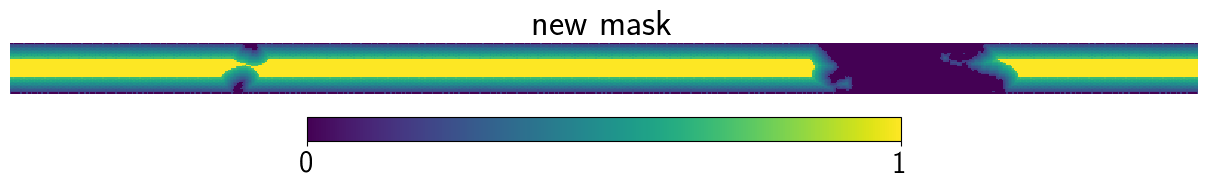

In [32]:
plt.figure(figsize=(12,3))

Dec_min = dec_min - 0.1
Dec_max = dec_max + 0.1
CMAP    = "viridis"
hp.cartview(mask , 
            norm="hist", unit=None,  
            latra=[Dec_min,Dec_max], 
            cmap=CMAP, title='new mask',
            sub=111)

In [16]:
output_info

{'type': 'mask',
 'nside': 256,
 'dec': {'min': -25.48, 'max': -10.17},
 'foreground_cut': True,
 'foreground_dirpath': '/media/BINGODATA1/ComponentSeparation/MAPS/PAPER/PSM_Components',
 'perc_foreground_cut': 0.2,
 'apodization': True,
 'apod_scale': 5,
 'apod_type': 'C2',
 'output_dir': None}

In [17]:
".".join(("_".join((output_info['type'], str(output_info['nside']) )) ,'fits'))

'mask_256.fits'

In [19]:
def return_new_FITSfilename_mask(output_info=None):
    #'type':'mask'       #the formatting will follow the mask new formatting name scheme
    #'add_name': None    #None or string name: If None, it'll add in the end nothing. If Str name, the name will be added before '.fits' term
    #'nside': 256        #healpix map resolution  
    #'dec':{'min': -25.48, 'max': -10.17} #declination region does not masked 
    #'galactic_cut':True #If there is some galactic region cutted
    #'foreground_dirpath': "/media/BINGODATA1/ComponentSeparation/MAPS/PAPER/PSM_Components"  #the path to the directory where there are the foreground emission maps 
    #'perc_galactic_cut': 0.2, #Percentage of Foregorund intensity emission to be cutted # It'll be got the first channel because it is higher in intensity medium value
    #'apodization':True,       #True or False: True to apply NaMaster apodization
    #'apod_scale':5,           #Apodization degrees  on the boundary to be applied by NaMaster
    #'apod_type':'C2',         #Type of apodization
    #output_info['apod_scale_unit'] = 'deg'
    if output_info['type'].lower()=='mask':
        output_info['type'] = output_info['type'].lower()
        filename  = "_".join((output_info['type'], str(output_info['nside']) ))
        if output_info['apodization']:
            apod_part = "".join((str(output_info['apod_scale']), 'deg', output_info['apod_type'], 'apod'))
            filename = "_".join((filename, apod_part))
        if output_info['foreground_cut']:
            gal_part = "".join(( str(int(100*output_info['perc_foreground_cut'])),'fgcut' ))
            filename = "_".join((filename, gal_part))
        if (output_info['add_name']!=None)*(type(output_info['add_name'])==str):    
            filename = "_".join((filename, output_info['add_name']))
        return ".".join((filename,'fits'))
    else:
        raise ValueError('output_file type does not accept')

In [20]:
output_info = {'type':'mask',
               'nside': 256,
               'dec':{'min': -25.48, 'max': -10.17},
               'foreground_cut':True, 'perc_foreground_cut': 0.2,
               'apodization' :True, 'apod_scale':5,'apod_type':'C2',
               'foreground_dirpath': "/media/BINGODATA1/ComponentSeparation/MAPS/PAPER/PSM_Components",
               'output_dir':None,
               'add_name': None
              }

mname = return_new_FITSfilename_mask(output_info)

print(mname,"\n")

part_mname = mname.split('.fits')[0]
keyword = 'apod'
if len(part_mname.split(keyword))>1:
    part_ = part_mname.split(keyword)[0].split("_")[-1]
    print(part_)
    
keyword = 'fgcut'
if len(part_mname.split(keyword))>1:
    part_ = part_mname.split(keyword)[0].split("_")[-1]
    print(part_)    

mask_256_5degC2apod_20fgcut.fits 

5degC2
20


In [21]:
mname = return_new_FITSfilename_mask(output_info)

In [22]:
output_info = {'type':'mask',
               'nside': 256,
               'dec':{'min': -25.48, 'max': -10.17},
               'foreground_cut':True, 'perc_foreground_cut': 0.2,
               'apodization' :True, 'apod_scale':5,'apod_type':'C2',
               'foreground_dirpath': "/media/BINGODATA1/ComponentSeparation/MAPS/PAPER/PSM_Components",
               'output_dir':None,
               'add_name': None,
               'project': 'BINGO'
              }

In [23]:
def creating_primary_FITSheader_mask():
    hdr = fits.Header()
    hdr['COMMENT']="THIS FILE HAS A SKY MASK."
    return hdr

def creating_mask_FITSheader(output_info=None):
    import datetime
    hdr = fits.Header()
    hdr['COMMENT'] = "THIS IS A NEW NAME FORMAT FOR THE BINGO PROJECT FITS FILES."
    hdr['COMMENT'] = "ALL THESE FILES ARE USED FOR COMPONENT SEPARATION CODE CALLED --CHISEL--"
    hdr['COMMENT'] = "https://github.com/multinverse/CHISEL---signals-from-LIM"
    hdr['COMMENT'] = "THIS IS THE NEW FORMAT FOR MASKS."
    hdr['COMMENT'] = "CREATED IN: {}".format(str(datetime.datetime.now()).split(".")[0])
    for i,ikey in enumerate(output_info.keys()):
        ikey = ikey.lower()
        if ikey=="project":
            hdr[ikey] = output_info[ikey]
            #hdr.comments['field'] = "{}".format("...")
        if ikey=="nside":
            hdr[ikey] = output_info[ikey]
            #hdr.comments["stokes"] = "{}".format(stokes_unit)       
        if ikey=="dec":
            hdr["_".join((ikey,"min"))]=output_info[ikey]['min']
            hdr["_".join((ikey,"max"))]=output_info[ikey]['max']
            hdr.comments["_".join((ikey,"min"))]="in {}".format('deg')
            hdr.comments["_".join((ikey,"max"))]="in {}".format('deg')
        if ikey=="foreground_cut":
            hdr['fgcut'] = output_info[ikey]
            hdr.comments['fgcut']  = "remove part of foreground emission"
            if output_info[ikey]:
                hdr['perc_cut'] = 100*output_info['perc_foreground_cut']
                hdr.comments['perc_cut'] = "% higher foreground removed "
        if ikey=="apodization":
            hdr['apod'] = output_info[ikey]
            hdr.comments['apod'] = 'apply apodization'
            if output_info[ikey]:
                hdr['ap_scale'] = output_info['apod_scale']
                hdr.comments['ap_scale'] = 'apodization scale in deg'
                hdr['ap_type'] = output_info['apod_type']
                hdr.comments['ap_type'] = 'apodization type from NaMASTER'                
    return hdr

In [24]:
hdr1 = creating_mask_FITSheader(output_info)
hdr1

NSIDE   =                  256                                                  
DEC_MIN =               -25.48 / in deg                                         
DEC_MAX =               -10.17 / in deg                                         
FGCUT   =                    T / remove part of foreground emission             
PERC_CUT=                 20.0 / % higher foreground removed                    
APOD    =                    T / apply apodization                              
AP_SCALE=                    5 / apodization scale in deg                       
AP_TYPE = 'C2      '           / apodization type from NaMASTER                 
PROJECT = 'BINGO   '                                                            
COMMENT THIS IS A NEW NAME FORMAT FOR THE BINGO PROJECT FITS FILES.             
COMMENT ALL THESE FILES ARE USED FOR COMPONENT SEPARATION CODE CALLED --CHISEL--
COMMENT https://github.com/multinverse/CHISEL---signals-from-LIM                
COMMENT THIS IS THE NEW FORM

In [ ]:
mname = return_new_FITSfilename_mask(output_info)
#mask = building_mask(output_info)
hdr_hdu0  = creating_primary_FITSheader_mask()
vec_hdu1  = building_mask(output_info) #mask
hdr_hdu1  = creating_mask_FITSheader(output_info) #Header to be used 

hdu0 = fits.PrimaryHDU(header=hdr_hdu0)
hdu1 = fits.ImageHDU(header=hdr_hdu1,data=vec_hdu1, name="MASK")
hdul = fits.HDUList([hdu0,hdu1])
if output_info['output_dir']==None:
    filename = os.path.join(os.getcwd()              , mname)
else:
    filename = os.path.join(output_info['output_dir'], mname)
if output_info['output_dir']==None:
    hdata.file_verification(os.getcwd(),"","outputs")
    pathout = os.path.join(os.getcwd(),"outputs")
else:
    pathout = output_info['output_dir']    
hdul.writeto(filename)

### 

In [38]:
iname = mname
with fits.open(os.path.join(os.getcwd(),"",iname)) as h:
    hdul = dcopy(h)
hdul.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       5   ()      
  1  MASK          1 ImageHDU        21   (786432,)   float64   


In [39]:
hdul[1].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    1 / number of array dimensions                     
NAXIS1  =               786432                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
NSIDE   =                  256                                                  
DEC_MIN =               -25.48 / in deg                                         
DEC_MAX =               -10.17 / in deg                                         
FGCUT   =                    T / remove part of foreground emission             
PERC_CUT=                 20.0 / % higher foreground removed                    
APOD    =                    T / apply apodization                              
AP_SCALE=                   

In [ ]:
if output_info['output_dir']==None:
    file_verification(os.getcwd(),"","outputs")
    pathout = os.path.join(os.getcwd(),"outputs")
else:
    pathout = output_info['output_dir']